# SSVQE for BODIPY

August 2025
> **Molecule**: 4,4‑difluoro‑4‑bora‑3a,4a‑diaza‑s‑indacene (BODIPY)


### Calcul des énergies de la molecule de BODIPY sur un simulateur réel


In [55]:
pip install pennylane

In [56]:
pip install pyscf

In [57]:
pip install openfermion

In [58]:
pip install bluequbit

In [59]:
import bluequbit

In [60]:
# importation des packages
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import pyscf

In [61]:
# coordonnées xyz de la molecule
symbols, coordinates = qchem.read_structure('Bodipy.xyz')
molecule = qml.qchem.Molecule(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis_name='sto-3g')


In [62]:
# Hamiltonien moleculaire
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
    molecule,
    mapping='jordan_wigner',
    active_electrons=4,
    active_orbitals=4,
    method="pyscf"
)
print(f'Hamiltonian built with {qubits} qubits')
print(hamiltonian)

Hamiltonian built with 8 qubits
-589.0840495180878 * I([0, 1, 2, 3, 4, 5, 6, 7]) + 0.1400814640575614 * Z(0) + 0.0030267712471362127 * (Y(0) @ Z(1) @ Y(2)) + 0.0030267712471362127 * (X(0) @ Z(1) @ X(2)) + 0.007086501999210865 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + 0.007086501999210865 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + -0.0034844009363983273 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.0034844009363983273 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + 0.08071466204313539 * Z(2) + 0.04943157559698651 * (Z(0) @ Z(2)) + 0.0016451797379385923 * (Y(2) @ Z(3) @ Y(4)) + 0.0016451797379385923 * (X(2) @ Z(3) @ X(4)) + 0.0006768624333717656 * (Z(0) @ Y(2) @ Z(3) @ Y(4)) + 0.0006768624333717656 * (Z(0) @ X(2) @ Z(3) @ X(4)) + -0.038202296734557176 * (Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.038202296734557176 * (X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)) + -0.015257827587718405 * (Z(0) @ Y(2) @ Z(3) @ Z(4) @ Z(5) @ Y(6)) + -0.015257827587718405 * (Z(0) @ X(2) @ Z(3) @ Z(4) @ Z(5) @ X(6)

In [63]:
# definir l'Ansatz UCCSD
#Circuit Anstaz:
def ansatz(params, wires, s_wires, d_wires, hf_state):
    qml.UCCSD(params, wires, s_wires, d_wires, hf_state)
    #return qml.expval(hamiltonian)

In [64]:
# Params:
params = np.random.uniform(0, 2*np.pi, (8, qubits, 3))


# Define the initial values of the circuit parameters
#params = np.zeros(len(singles) + len(doubles))

In [65]:
def WEIGHTED_SSVQE(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=100, k=0, device_name='bluequbit.cpu'):
    """Weighted SSVQE compatible avec la limite de 5 jobs BlueQubit."""

    import pennylane as qml
    import numpy as np

    # Nombre de qubits et device
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits, shots=None, token="JVZIrLHOWVJmTGvyefXCVcnYWr6udxbD")
    wires = range(qubits)

    electrons = 4
    hf_state = qml.qchem.hf_state(electrons, qubits)
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    params = np.zeros(len(singles) + len(doubles))
    weights = np.random.random()  # Poids aléatoire pour l'état k

    # QNode pour un état donné
    def make_qnode(state_val):
        @qml.qnode(device)
        def cost_fn(params):
            # Prépare l'état de base
            for index, value in enumerate(np.binary_repr(state_val, qubits)):
                if value == '1':
                    qml.PauliX(index)
            ansatz(params, wires, s_wires, d_wires, hf_state)
            return qml.expval(hamiltonian)
        return cost_fn

    cost_functions = {i: make_qnode(i) for i in range(k+1)}

    # Nouvelle fonction total_cost avec exécution par sous-lots
    def total_cost(params):
        total = 0
        states_list = list(range(k+1))
        for i in range(0, len(states_list), 5):  # limite 5 jobs
            subset = states_list[i:i+5]
            for sv in subset:
                weight = weights if sv == k else 1
                total += weight * cost_functions[sv](params)
        return total

    # Optimisateurs
    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    optimizer = optimizers[opt_name]
    energies = []

    for _ in range(iterations):
        params = optimizer.step(total_cost, params)
        energies.append(cost_functions[k](params))

    return energies[-1], energies


In [68]:
def WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=100, k=[0], device_name='bluequbit.cpu'):
    import numpy as np
    import pennylane as qml

    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits, shots=None, token="JVZIrLHOWVJmTGvyefXCVcnYWr6udxbD")
    wires = range(qubits)

    electrons = 4  # actif electrons

    hf_state = qml.qchem.hf_state(electrons, qubits)
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)

    params = np.zeros(len(singles) + len(doubles))

    # S’assurer que k est une liste d’états entiers
    if isinstance(k, int):
        k = list(range(k+1))
    elif isinstance(k, (list, tuple, np.ndarray)):
        k = list(k)
    else:
        raise ValueError("k doit être un entier ou une liste d’entiers")

    if max(k) > 2**qubits - 1:
        raise ValueError(f"k doit être <= {2**qubits - 1}")

    weights = np.arange(len(k), 0, -1)  # poids décroissants

    def state_prep(state_value):
        for index, value in enumerate(np.binary_repr(state_value, qubits)):
            if value == '1':
                qml.PauliX(wires=index)

    @qml.qnode(device)
    def state_cost(params, state_value):
        state_prep(state_value)
        ansatz(params, wires, s_wires, d_wires, hf_state)
        return qml.expval(hamiltonian)

    def total_cost(params):
        cost = 0
        # Exécution SEQUENTIELLE des circuits pour éviter dépassement batch jobs
        for idx, state_value in enumerate(k):
            cost += weights[idx] * state_cost(params, state_value=state_value)
        return cost

    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    optimizer = optimizers[opt_name]
    energies = np.zeros((len(k), iterations))

    for itr in range(iterations):
        params = optimizer.step(total_cost, params)
        for idx, state_value in enumerate(k):
            energy = state_cost(params, state_value=state_value)
            energies[idx][itr] = energy

    Energies = []
    for energy in energies:
        Energies.append([energy[-1], energy])
    return Energies


In [70]:
def WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, opt_name='Adam', stepsize=0.05, iterations=100, k=[0], device_name='bluequbit.cpu'):
    """Weighted SSVQE adapté pour BlueQubit (limite 5 jobs en batch)."""

    import pennylane as qml
    import numpy as np

    # Nombre de qubits requis
    qubits = len(hamiltonian.wires)
    device = qml.device(device_name, wires=qubits, shots=None, token="JVZIrLHOWVJmTGvyefXCVcnYWr6udxbD")
    wires = range(qubits)

    electrons = 4
    hf_state = qml.qchem.hf_state(electrons, qubits)
    singles, doubles = qml.qchem.excitations(electrons, qubits)
    s_wires, d_wires = qml.qchem.excitations_to_wires(singles, doubles)
    params = np.zeros(len(singles) + len(doubles))

    weights = np.arange(max(k)+1, 0, -1)

    def state_prep(state_value):
        for index, value in enumerate(np.binary_repr(state_value, qubits)):
            if value == '1':
                qml.PauliX(index)

    @qml.qnode(device)
    def state_cost(params, state_value):
        state_prep(state_value)
        ansatz(params, wires, s_wires, d_wires, hf_state)
        return qml.expval(hamiltonian)

    # Nouvelle version : évalue par lots ≤ 5
    def total_cost(params):
        cost = 0
        state_values = list(range(max(k)+1))
        # découpages en sous-listes
        for i in range(0, len(state_values), 5):
            subset = state_values[i:i+5]
            for sv in subset:
                cost += weights[sv] * state_cost(params, state_value=sv)
        return cost

    optimizers = {
        'Adam': qml.AdamOptimizer(stepsize=stepsize),
        'Adagrad': qml.AdagradOptimizer(stepsize=stepsize),
        'GradientDescent': qml.GradientDescentOptimizer(stepsize=stepsize)
    }

    optimizer = optimizers[opt_name]
    energies = np.zeros((max(k)+1, iterations))

    for itr in range(iterations):
        params = optimizer.step(total_cost, params)
        for index in range(max(k)+1):
            if index in k:
                energies[index][itr] = state_cost(params, state_value=index)

    Energies = [[energy[-1], energy] for energy in energies]
    return Energies


In [71]:
# energies
# Weighted SSVQE:
energy_G_1, energies_G_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, stepsize=0.01, k=0)

[BQ-PYTHON-SDK][WARNING] - Beta version 0.16.0b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: p20uavSdBylgE1NG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: p20uavSdBylgE1NG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: p20uavSdBylgE1NG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:15 UTC, cost: $0.00, run time: 414 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8jiyQjt0VZ1Xgu1K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8jiyQjt0VZ1Xgu1K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8jiyQjt0VZ1Xgu1K, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:17 UTC, cost: $0.00, run time: 411 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hEkWr2E1Pu4RCfcc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hEkWr2E1Pu4RCfcc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hEkWr2E1Pu4RCfcc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:18 UTC, cost: $0.00, run time: 417 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OSRbq2h1CHguAn7U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OSRbq2h1CHguAn7U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OSRbq2h1CHguAn7U, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:20 UTC, cost: $0.00, run time: 414 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: y29RyGDV2AKE9kwH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: y29RyGDV2AKE9kwH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: y29RyGDV2AKE9kwH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:22 UTC, cost: $0.00, run time: 405 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7rBB88JRl4whTREu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7rBB88JRl4whTREu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7rBB88JRl4whTREu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:23 UTC, cost: $0.00, run time: 391 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mpowyCwMcCosU1dG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mpowyCwMcCosU1dG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mpowyCwMcCosU1dG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:25 UTC, cost: $0.00, run time: 437 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dm8pjt7GU1SFi8SK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dm8pjt7GU1SFi8SK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dm8pjt7GU1SFi8SK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:26 UTC, cost: $0.00, run time: 399 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Kz38GZFQ9IUCVosL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Kz38GZFQ9IUCVosL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Kz38GZFQ9IUCVosL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:28 UTC, cost: $0.00, run time: 426 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zLo4nsfJrQwDCUu9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zLo4nsfJrQwDCUu9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zLo4nsfJrQwDCUu9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:29 UTC, cost: $0.00, run time: 404 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wLQOk6bBrPGGIcSH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wLQOk6bBrPGGIcSH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wLQOk6bBrPGGIcSH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:31 UTC, cost: $0.00, run time: 390 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WP7CELNbtVagRB2E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WP7CELNbtVagRB2E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WP7CELNbtVagRB2E, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:32 UTC, cost: $0.00, run time: 394 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hgCnRhIgh1DPfmgG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hgCnRhIgh1DPfmgG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hgCnRhIgh1DPfmgG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:34 UTC, cost: $0.00, run time: 377 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9T61LQ2RdYuroDho, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9T61LQ2RdYuroDho, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9T61LQ2RdYuroDho, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:35 UTC, cost: $0.00, run time: 395 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BYZSVY4w7FzataOr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BYZSVY4w7FzataOr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BYZSVY4w7FzataOr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:37 UTC, cost: $0.00, run time: 389 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: keT7ViKpmyb5XsNU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: keT7ViKpmyb5XsNU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: keT7ViKpmyb5XsNU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:38 UTC, cost: $0.00, run time: 404 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8L6VzHGe6FqQqvdc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8L6VzHGe6FqQqvdc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8L6VzHGe6FqQqvdc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:40 UTC, cost: $0.00, run time: 380 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: StQVr2XeK55GDhum, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: StQVr2XeK55GDhum, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: StQVr2XeK55GDhum, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:41 UTC, cost: $0.00, run time: 390 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wAZowBcw1TM5xPqF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wAZowBcw1TM5xPqF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wAZowBcw1TM5xPqF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:43 UTC, cost: $0.00, run time: 396 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nXUlyxLMARlaWyrq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nXUlyxLMARlaWyrq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nXUlyxLMARlaWyrq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:45 UTC, cost: $0.00, run time: 388 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TE4rCP7BCJjULEmx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TE4rCP7BCJjULEmx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TE4rCP7BCJjULEmx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:46 UTC, cost: $0.00, run time: 374 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: psGPsL6pGoBPxEyb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: psGPsL6pGoBPxEyb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: psGPsL6pGoBPxEyb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:48 UTC, cost: $0.00, run time: 378 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0vXOAXY3nAaqyaaZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0vXOAXY3nAaqyaaZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0vXOAXY3nAaqyaaZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:50 UTC, cost: $0.00, run time: 396 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jvfJeCbqMYLK2tUb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jvfJeCbqMYLK2tUb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jvfJeCbqMYLK2tUb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:51 UTC, cost: $0.00, run time: 395 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DogkcBwosMHyAzGJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DogkcBwosMHyAzGJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DogkcBwosMHyAzGJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:53 UTC, cost: $0.00, run time: 734 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: apFw2EaFQ4cu1hBj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: apFw2EaFQ4cu1hBj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: apFw2EaFQ4cu1hBj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:55 UTC, cost: $0.00, run time: 389 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hllS1dikVcVXuveY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hllS1dikVcVXuveY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hllS1dikVcVXuveY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:57 UTC, cost: $0.00, run time: 373 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xNERHLXGUxI3gQd0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xNERHLXGUxI3gQd0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:17:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xNERHLXGUxI3gQd0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:17:58 UTC, cost: $0.00, run time: 400 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CqAQOWj1oqEd0WGF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CqAQOWj1oqEd0WGF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CqAQOWj1oqEd0WGF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:00 UTC, cost: $0.00, run time: 394 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l7KQEXD4ARJlwCqJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l7KQEXD4ARJlwCqJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l7KQEXD4ARJlwCqJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:01 UTC, cost: $0.00, run time: 395 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dQlA9PGIZs0DwhyN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dQlA9PGIZs0DwhyN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dQlA9PGIZs0DwhyN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:03 UTC, cost: $0.00, run time: 409 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xshWk6e39ivQNg3G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xshWk6e39ivQNg3G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xshWk6e39ivQNg3G, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:04 UTC, cost: $0.00, run time: 382 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: z65UV6EaLwAHC7J6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: z65UV6EaLwAHC7J6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: z65UV6EaLwAHC7J6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:06 UTC, cost: $0.00, run time: 386 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 337NS7251Uz9FMVD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 337NS7251Uz9FMVD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 337NS7251Uz9FMVD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:08 UTC, cost: $0.00, run time: 369 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QBPBETL1h7YiP3jt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QBPBETL1h7YiP3jt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QBPBETL1h7YiP3jt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:09 UTC, cost: $0.00, run time: 387 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: alPhaXowCmKplxJ6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: alPhaXowCmKplxJ6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: alPhaXowCmKplxJ6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:11 UTC, cost: $0.00, run time: 375 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kZ3BMtcEm5IxsWfY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kZ3BMtcEm5IxsWfY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kZ3BMtcEm5IxsWfY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:12 UTC, cost: $0.00, run time: 379 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F90vvirgtVdebzzh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: F90vvirgtVdebzzh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: F90vvirgtVdebzzh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:14 UTC, cost: $0.00, run time: 381 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P7d6BaBtF3IC6G4s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P7d6BaBtF3IC6G4s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P7d6BaBtF3IC6G4s, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:16 UTC, cost: $0.00, run time: 393 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: a5BmyFvOGJFQZWso, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: a5BmyFvOGJFQZWso, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: a5BmyFvOGJFQZWso, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:17 UTC, cost: $0.00, run time: 419 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rwVN3wiiKeG8U9qI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rwVN3wiiKeG8U9qI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rwVN3wiiKeG8U9qI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:19 UTC, cost: $0.00, run time: 375 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fkvuGWY5yhUtOaOj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fkvuGWY5yhUtOaOj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fkvuGWY5yhUtOaOj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:20 UTC, cost: $0.00, run time: 380 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ko8mvRtkroztr8NX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ko8mvRtkroztr8NX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ko8mvRtkroztr8NX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:22 UTC, cost: $0.00, run time: 386 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KXQSKu7CLzO6mKD6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KXQSKu7CLzO6mKD6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KXQSKu7CLzO6mKD6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:24 UTC, cost: $0.00, run time: 390 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Wo0YTWEKQ3d7ZSvC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Wo0YTWEKQ3d7ZSvC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Wo0YTWEKQ3d7ZSvC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:26 UTC, cost: $0.00, run time: 372 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mcOL7Ykd9ujFy3Qw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mcOL7Ykd9ujFy3Qw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mcOL7Ykd9ujFy3Qw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:27 UTC, cost: $0.00, run time: 383 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oW1pvFqvLRjLhtMU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oW1pvFqvLRjLhtMU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oW1pvFqvLRjLhtMU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:29 UTC, cost: $0.00, run time: 359 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jKbsDQwjkj3L1jP4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jKbsDQwjkj3L1jP4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jKbsDQwjkj3L1jP4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:30 UTC, cost: $0.00, run time: 393 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: D3PbXfErCi6CiyMk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: D3PbXfErCi6CiyMk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: D3PbXfErCi6CiyMk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:32 UTC, cost: $0.00, run time: 375 ms, queue time: 170 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OtGZcFeheQ8HZpYg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OtGZcFeheQ8HZpYg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OtGZcFeheQ8HZpYg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:33 UTC, cost: $0.00, run time: 395 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3YQbTNVs3IpM0mO8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3YQbTNVs3IpM0mO8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3YQbTNVs3IpM0mO8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:35 UTC, cost: $0.00, run time: 380 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VPAVFz640gR62lBU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VPAVFz640gR62lBU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VPAVFz640gR62lBU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:37 UTC, cost: $0.00, run time: 383 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yh40yKF5wNr4rlmW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yh40yKF5wNr4rlmW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yh40yKF5wNr4rlmW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:38 UTC, cost: $0.00, run time: 370 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E7qYwvE1nnH472lc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E7qYwvE1nnH472lc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E7qYwvE1nnH472lc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:40 UTC, cost: $0.00, run time: 357 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FcNe6s5E3C3u8OMV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FcNe6s5E3C3u8OMV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FcNe6s5E3C3u8OMV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:41 UTC, cost: $0.00, run time: 370 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: M0KejqmVcoOjHaXS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: M0KejqmVcoOjHaXS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: M0KejqmVcoOjHaXS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:43 UTC, cost: $0.00, run time: 366 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YGnBIuuv5peNlrN1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YGnBIuuv5peNlrN1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YGnBIuuv5peNlrN1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:44 UTC, cost: $0.00, run time: 394 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: z9qx8YEhd487iuOP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: z9qx8YEhd487iuOP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: z9qx8YEhd487iuOP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:46 UTC, cost: $0.00, run time: 381 ms, queue time: 173 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JYSwErTwcqkBVEiL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JYSwErTwcqkBVEiL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JYSwErTwcqkBVEiL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:48 UTC, cost: $0.00, run time: 386 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ur1y4EPX6u8feU8D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ur1y4EPX6u8feU8D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ur1y4EPX6u8feU8D, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:50 UTC, cost: $0.00, run time: 354 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 99m6Gnh33ql9yoh2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 99m6Gnh33ql9yoh2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 99m6Gnh33ql9yoh2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:51 UTC, cost: $0.00, run time: 355 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kYMQpnHG0hhRizYh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kYMQpnHG0hhRizYh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kYMQpnHG0hhRizYh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:53 UTC, cost: $0.00, run time: 341 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ace2AnEzAVNO6ylf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ace2AnEzAVNO6ylf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ace2AnEzAVNO6ylf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:54 UTC, cost: $0.00, run time: 339 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XCRmoyjZGXmgXuAN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XCRmoyjZGXmgXuAN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XCRmoyjZGXmgXuAN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:56 UTC, cost: $0.00, run time: 367 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ftXDfZoOhvbMuQfE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ftXDfZoOhvbMuQfE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ftXDfZoOhvbMuQfE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:57 UTC, cost: $0.00, run time: 357 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XdDh7cx5raTDxL9M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XdDh7cx5raTDxL9M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:18:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XdDh7cx5raTDxL9M, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:18:59 UTC, cost: $0.00, run time: 388 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OF4o9gXHPt4HWN7X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OF4o9gXHPt4HWN7X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OF4o9gXHPt4HWN7X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:01 UTC, cost: $0.00, run time: 381 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Nv2OeqSMQjvNhILo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Nv2OeqSMQjvNhILo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Nv2OeqSMQjvNhILo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:03 UTC, cost: $0.00, run time: 378 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XJlGjLdjjqQb2IQU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XJlGjLdjjqQb2IQU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XJlGjLdjjqQb2IQU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:04 UTC, cost: $0.00, run time: 372 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SrDx3ouQ1W2tzc9X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SrDx3ouQ1W2tzc9X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SrDx3ouQ1W2tzc9X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:06 UTC, cost: $0.00, run time: 375 ms, queue time: 173 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9D0d2xNrIKlzgPcL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9D0d2xNrIKlzgPcL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9D0d2xNrIKlzgPcL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:08 UTC, cost: $0.00, run time: 371 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 76xoRaOhRcdXdNsi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 76xoRaOhRcdXdNsi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 76xoRaOhRcdXdNsi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:09 UTC, cost: $0.00, run time: 358 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NL3heQreox3rC55N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NL3heQreox3rC55N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NL3heQreox3rC55N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:11 UTC, cost: $0.00, run time: 353 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LohFRM7ySJkW1WEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LohFRM7ySJkW1WEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LohFRM7ySJkW1WEw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:12 UTC, cost: $0.00, run time: 379 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NAaCoFE8S5FtG0xl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NAaCoFE8S5FtG0xl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NAaCoFE8S5FtG0xl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:14 UTC, cost: $0.00, run time: 410 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NwESK7mCcShktDjA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NwESK7mCcShktDjA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NwESK7mCcShktDjA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:15 UTC, cost: $0.00, run time: 403 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jp3VKylQSle0bSzO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jp3VKylQSle0bSzO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jp3VKylQSle0bSzO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:17 UTC, cost: $0.00, run time: 371 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: H9A0xEOi1KjyoeKV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: H9A0xEOi1KjyoeKV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: H9A0xEOi1KjyoeKV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:19 UTC, cost: $0.00, run time: 407 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mtth7PbjWOpho6uZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mtth7PbjWOpho6uZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mtth7PbjWOpho6uZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:20 UTC, cost: $0.00, run time: 368 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uddLq85brYhLRrhA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uddLq85brYhLRrhA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uddLq85brYhLRrhA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:22 UTC, cost: $0.00, run time: 341 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OVB578g8HYCY4yjR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OVB578g8HYCY4yjR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OVB578g8HYCY4yjR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:23 UTC, cost: $0.00, run time: 380 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tc3UkGCGoNUAzV4a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Tc3UkGCGoNUAzV4a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Tc3UkGCGoNUAzV4a, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:25 UTC, cost: $0.00, run time: 385 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: alYlRG2BWJvYVhfD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: alYlRG2BWJvYVhfD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: alYlRG2BWJvYVhfD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:26 UTC, cost: $0.00, run time: 395 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5QBBfZitR7aXAID5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5QBBfZitR7aXAID5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5QBBfZitR7aXAID5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:28 UTC, cost: $0.00, run time: 393 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8x9gSvkKJjqCFsdl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8x9gSvkKJjqCFsdl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8x9gSvkKJjqCFsdl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:29 UTC, cost: $0.00, run time: 421 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: c4paVA6tFYPF42hU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: c4paVA6tFYPF42hU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: c4paVA6tFYPF42hU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:31 UTC, cost: $0.00, run time: 395 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SQCDbpUDggCpWz3b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SQCDbpUDggCpWz3b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SQCDbpUDggCpWz3b, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:33 UTC, cost: $0.00, run time: 380 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qkjBfQXcMr3a40ew, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qkjBfQXcMr3a40ew, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qkjBfQXcMr3a40ew, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:35 UTC, cost: $0.00, run time: 378 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kIrN9GuOhYDW6SQQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kIrN9GuOhYDW6SQQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kIrN9GuOhYDW6SQQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:36 UTC, cost: $0.00, run time: 409 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bjqF0V7XCyAtnYwF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bjqF0V7XCyAtnYwF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bjqF0V7XCyAtnYwF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:38 UTC, cost: $0.00, run time: 396 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rIe4UBjg4XylmTi6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rIe4UBjg4XylmTi6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rIe4UBjg4XylmTi6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:39 UTC, cost: $0.00, run time: 390 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lrbitNUXM9PIDniK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lrbitNUXM9PIDniK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lrbitNUXM9PIDniK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:41 UTC, cost: $0.00, run time: 384 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YCiK43YzW5HcWix9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YCiK43YzW5HcWix9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YCiK43YzW5HcWix9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:42 UTC, cost: $0.00, run time: 386 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sMVpD897SreTw2ZH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sMVpD897SreTw2ZH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sMVpD897SreTw2ZH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:44 UTC, cost: $0.00, run time: 396 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EiQDBHp6YB1FzCCJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EiQDBHp6YB1FzCCJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EiQDBHp6YB1FzCCJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:46 UTC, cost: $0.00, run time: 389 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cg2lLtvIn4XjEEt9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cg2lLtvIn4XjEEt9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cg2lLtvIn4XjEEt9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:47 UTC, cost: $0.00, run time: 423 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dERItUWF8rrusys1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dERItUWF8rrusys1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dERItUWF8rrusys1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:49 UTC, cost: $0.00, run time: 390 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2xJiNnHveONswyjh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2xJiNnHveONswyjh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2xJiNnHveONswyjh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:50 UTC, cost: $0.00, run time: 403 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8YIqLkSiaeVBQiny, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8YIqLkSiaeVBQiny, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8YIqLkSiaeVBQiny, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:52 UTC, cost: $0.00, run time: 375 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: f2ms33RgGLkaKsH7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: f2ms33RgGLkaKsH7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: f2ms33RgGLkaKsH7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:53 UTC, cost: $0.00, run time: 409 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ioD3vQnUHADRyVLu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ioD3vQnUHADRyVLu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ioD3vQnUHADRyVLu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:55 UTC, cost: $0.00, run time: 360 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lb1S9KbRoLbUZJ5l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lb1S9KbRoLbUZJ5l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lb1S9KbRoLbUZJ5l, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:56 UTC, cost: $0.00, run time: 367 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OaaB8sUNNBjxbx79, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OaaB8sUNNBjxbx79, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OaaB8sUNNBjxbx79, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:58 UTC, cost: $0.00, run time: 380 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BU8LxRs7sGj7lfNr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BU8LxRs7sGj7lfNr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:19:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BU8LxRs7sGj7lfNr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:19:59 UTC, cost: $0.00, run time: 388 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qPSSWkaNlwWCI8P3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qPSSWkaNlwWCI8P3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qPSSWkaNlwWCI8P3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:01 UTC, cost: $0.00, run time: 412 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OqxfTqkthtgo2zOg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OqxfTqkthtgo2zOg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OqxfTqkthtgo2zOg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:02 UTC, cost: $0.00, run time: 390 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4UmAYnj6FqDPGldb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4UmAYnj6FqDPGldb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4UmAYnj6FqDPGldb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:04 UTC, cost: $0.00, run time: 393 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xntJLlpzconFEzFS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xntJLlpzconFEzFS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xntJLlpzconFEzFS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:06 UTC, cost: $0.00, run time: 375 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WIqsIym0XyWe31jB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WIqsIym0XyWe31jB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WIqsIym0XyWe31jB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:07 UTC, cost: $0.00, run time: 380 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ixpHCkBltVwswp1F, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ixpHCkBltVwswp1F, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ixpHCkBltVwswp1F, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:09 UTC, cost: $0.00, run time: 384 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kRFjBBXVMqbM9zgH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kRFjBBXVMqbM9zgH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kRFjBBXVMqbM9zgH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:10 UTC, cost: $0.00, run time: 384 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1aJ9SKkF5IEhTQqU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1aJ9SKkF5IEhTQqU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1aJ9SKkF5IEhTQqU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:12 UTC, cost: $0.00, run time: 356 ms, queue time: 201 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QIHV6cbG05EM5mOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QIHV6cbG05EM5mOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QIHV6cbG05EM5mOU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:13 UTC, cost: $0.00, run time: 375 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: X0LLWASJv2bmRLtf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: X0LLWASJv2bmRLtf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: X0LLWASJv2bmRLtf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:15 UTC, cost: $0.00, run time: 370 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hoRepzmRcI8tfmaT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hoRepzmRcI8tfmaT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hoRepzmRcI8tfmaT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:17 UTC, cost: $0.00, run time: 370 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ds4tCUj9teQTJU2X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ds4tCUj9teQTJU2X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ds4tCUj9teQTJU2X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:18 UTC, cost: $0.00, run time: 387 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0uplhYGRrOCunuKf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0uplhYGRrOCunuKf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0uplhYGRrOCunuKf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:20 UTC, cost: $0.00, run time: 370 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dHTwQcSQHCX27rmE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dHTwQcSQHCX27rmE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dHTwQcSQHCX27rmE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:22 UTC, cost: $0.00, run time: 379 ms, queue time: 170 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KfrvEO9VH4nNTBGX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KfrvEO9VH4nNTBGX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KfrvEO9VH4nNTBGX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:23 UTC, cost: $0.00, run time: 388 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4jA9gzfZHlk1L7Kq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4jA9gzfZHlk1L7Kq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4jA9gzfZHlk1L7Kq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:25 UTC, cost: $0.00, run time: 363 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mHQinnceAcBDVXJp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mHQinnceAcBDVXJp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mHQinnceAcBDVXJp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:27 UTC, cost: $0.00, run time: 374 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Rn6I7Dm5O5h8Vb1I, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Rn6I7Dm5O5h8Vb1I, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Rn6I7Dm5O5h8Vb1I, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:28 UTC, cost: $0.00, run time: 376 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RoId4G8dJ8noKnhj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RoId4G8dJ8noKnhj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RoId4G8dJ8noKnhj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:30 UTC, cost: $0.00, run time: 406 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pOmVsJAiaWX6zSoY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pOmVsJAiaWX6zSoY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pOmVsJAiaWX6zSoY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:31 UTC, cost: $0.00, run time: 376 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oSsE0E4vEak76Gqu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oSsE0E4vEak76Gqu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oSsE0E4vEak76Gqu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:33 UTC, cost: $0.00, run time: 389 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i2cTFXBDhTy1SNT8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i2cTFXBDhTy1SNT8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i2cTFXBDhTy1SNT8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:35 UTC, cost: $0.00, run time: 357 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: z5K23FySyxaNp0hO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: z5K23FySyxaNp0hO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: z5K23FySyxaNp0hO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:36 UTC, cost: $0.00, run time: 375 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eXQxZwiYVDzjaNp7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eXQxZwiYVDzjaNp7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eXQxZwiYVDzjaNp7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:38 UTC, cost: $0.00, run time: 384 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0eLqhgHDEurk5j8N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0eLqhgHDEurk5j8N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0eLqhgHDEurk5j8N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:40 UTC, cost: $0.00, run time: 374 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0ZPOaYicfaFTnBcs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0ZPOaYicfaFTnBcs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0ZPOaYicfaFTnBcs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:42 UTC, cost: $0.00, run time: 346 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Kq3xX8K1dXNla9AR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Kq3xX8K1dXNla9AR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Kq3xX8K1dXNla9AR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:43 UTC, cost: $0.00, run time: 357 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lLk5aS3NI1OdCN4t, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lLk5aS3NI1OdCN4t, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lLk5aS3NI1OdCN4t, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:45 UTC, cost: $0.00, run time: 371 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b03HjpvHWgWEhdrd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b03HjpvHWgWEhdrd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b03HjpvHWgWEhdrd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:46 UTC, cost: $0.00, run time: 391 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tmHepQ1hmFAfutjf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tmHepQ1hmFAfutjf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tmHepQ1hmFAfutjf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:48 UTC, cost: $0.00, run time: 393 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rUenyEkb62ihVZIA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rUenyEkb62ihVZIA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rUenyEkb62ihVZIA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:50 UTC, cost: $0.00, run time: 381 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QBIfu9TRC3Cd7vAK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QBIfu9TRC3Cd7vAK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QBIfu9TRC3Cd7vAK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:51 UTC, cost: $0.00, run time: 345 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5EoHEPc5i4QuOK57, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5EoHEPc5i4QuOK57, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5EoHEPc5i4QuOK57, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:53 UTC, cost: $0.00, run time: 339 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bBLJVx1btjIv7fAS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bBLJVx1btjIv7fAS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bBLJVx1btjIv7fAS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:54 UTC, cost: $0.00, run time: 349 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: a8dZeDaWmL4LCJhW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: a8dZeDaWmL4LCJhW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: a8dZeDaWmL4LCJhW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:56 UTC, cost: $0.00, run time: 357 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tKFDQEHUuDuTq6jm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tKFDQEHUuDuTq6jm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tKFDQEHUuDuTq6jm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:57 UTC, cost: $0.00, run time: 377 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E0RUbI93t5XELuiS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E0RUbI93t5XELuiS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:20:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E0RUbI93t5XELuiS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:20:59 UTC, cost: $0.00, run time: 388 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NpCgMQHoBWa9yaLV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NpCgMQHoBWa9yaLV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NpCgMQHoBWa9yaLV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:01 UTC, cost: $0.00, run time: 408 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WNTWYTjqIJ2dYcN9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WNTWYTjqIJ2dYcN9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WNTWYTjqIJ2dYcN9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:03 UTC, cost: $0.00, run time: 373 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fuqXvnC59BOcpdqf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fuqXvnC59BOcpdqf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fuqXvnC59BOcpdqf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:04 UTC, cost: $0.00, run time: 384 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: plkNfRaPqVlK3Qbs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: plkNfRaPqVlK3Qbs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: plkNfRaPqVlK3Qbs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:06 UTC, cost: $0.00, run time: 380 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Rt7wjX5bgXiFHdQg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Rt7wjX5bgXiFHdQg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Rt7wjX5bgXiFHdQg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:08 UTC, cost: $0.00, run time: 362 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iquI61yLLqp2JaEr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iquI61yLLqp2JaEr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iquI61yLLqp2JaEr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:09 UTC, cost: $0.00, run time: 367 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kTaOPFampFpRiamD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kTaOPFampFpRiamD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kTaOPFampFpRiamD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:11 UTC, cost: $0.00, run time: 377 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yWtG8tsZmPWRv7X7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yWtG8tsZmPWRv7X7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yWtG8tsZmPWRv7X7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:12 UTC, cost: $0.00, run time: 352 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wkb4nwtiWNdJJsEY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wkb4nwtiWNdJJsEY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wkb4nwtiWNdJJsEY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:14 UTC, cost: $0.00, run time: 366 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XAWwkqRIAT3o51eD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XAWwkqRIAT3o51eD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XAWwkqRIAT3o51eD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:16 UTC, cost: $0.00, run time: 364 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 38S5MuNopaZRAYvA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 38S5MuNopaZRAYvA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 38S5MuNopaZRAYvA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:17 UTC, cost: $0.00, run time: 378 ms, queue time: 1177 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: T7SKhOkFqBSdIpOa, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: T7SKhOkFqBSdIpOa, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: T7SKhOkFqBSdIpOa, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:20 UTC, cost: $0.00, run time: 351 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E6iJ7KZMZD5ZfTNt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E6iJ7KZMZD5ZfTNt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E6iJ7KZMZD5ZfTNt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:21 UTC, cost: $0.00, run time: 392 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eBHaLGAKWFL0Na8W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eBHaLGAKWFL0Na8W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eBHaLGAKWFL0Na8W, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:23 UTC, cost: $0.00, run time: 375 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EH4dp47wTbmHdn0w, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EH4dp47wTbmHdn0w, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EH4dp47wTbmHdn0w, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:24 UTC, cost: $0.00, run time: 411 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KYpB1EPrabL0pAPi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KYpB1EPrabL0pAPi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KYpB1EPrabL0pAPi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:26 UTC, cost: $0.00, run time: 338 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ocdO0DG5aKoEQmIy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ocdO0DG5aKoEQmIy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ocdO0DG5aKoEQmIy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:27 UTC, cost: $0.00, run time: 379 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vwdIxfaB3rL9iY2B, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vwdIxfaB3rL9iY2B, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vwdIxfaB3rL9iY2B, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:29 UTC, cost: $0.00, run time: 352 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: p9JBlnQiRNlyUpnZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: p9JBlnQiRNlyUpnZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: p9JBlnQiRNlyUpnZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:31 UTC, cost: $0.00, run time: 355 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LA3eQ7Z3XC8TCwCp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LA3eQ7Z3XC8TCwCp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LA3eQ7Z3XC8TCwCp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:32 UTC, cost: $0.00, run time: 392 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gIA2ZhOdTPcJpJky, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gIA2ZhOdTPcJpJky, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gIA2ZhOdTPcJpJky, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:34 UTC, cost: $0.00, run time: 357 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EdueQBGNimvRSwoo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EdueQBGNimvRSwoo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EdueQBGNimvRSwoo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:35 UTC, cost: $0.00, run time: 377 ms, queue time: 171 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bOvXh1pIaHAVuSXH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bOvXh1pIaHAVuSXH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bOvXh1pIaHAVuSXH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:37 UTC, cost: $0.00, run time: 372 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WMq8yROPN1GefizS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WMq8yROPN1GefizS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WMq8yROPN1GefizS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:38 UTC, cost: $0.00, run time: 365 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jPeAgSQs6AmLriqH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jPeAgSQs6AmLriqH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jPeAgSQs6AmLriqH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:40 UTC, cost: $0.00, run time: 363 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: n3y3UVLWvIs7nINr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: n3y3UVLWvIs7nINr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: n3y3UVLWvIs7nINr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:42 UTC, cost: $0.00, run time: 364 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dAol7jhqr10utAEW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dAol7jhqr10utAEW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dAol7jhqr10utAEW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:43 UTC, cost: $0.00, run time: 368 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fQlVm8kFm6hKDj9L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fQlVm8kFm6hKDj9L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fQlVm8kFm6hKDj9L, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:45 UTC, cost: $0.00, run time: 372 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ky7FxUzRoPbFTXCg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ky7FxUzRoPbFTXCg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ky7FxUzRoPbFTXCg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:46 UTC, cost: $0.00, run time: 390 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8fT5NvJ6QkHEboh2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8fT5NvJ6QkHEboh2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8fT5NvJ6QkHEboh2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:48 UTC, cost: $0.00, run time: 400 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 86YNVoxwYeHKOrjq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 86YNVoxwYeHKOrjq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 86YNVoxwYeHKOrjq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:49 UTC, cost: $0.00, run time: 388 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dRMJX1xQTtsjaXh1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dRMJX1xQTtsjaXh1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dRMJX1xQTtsjaXh1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:51 UTC, cost: $0.00, run time: 339 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VbdkdNbaY81eH1sl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VbdkdNbaY81eH1sl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VbdkdNbaY81eH1sl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:52 UTC, cost: $0.00, run time: 353 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oCYmThPBA4USNWwg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oCYmThPBA4USNWwg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oCYmThPBA4USNWwg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:54 UTC, cost: $0.00, run time: 340 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8B9CtlSdHkqP0KhG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8B9CtlSdHkqP0KhG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8B9CtlSdHkqP0KhG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:55 UTC, cost: $0.00, run time: 379 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ErTPUnNc4QsR83z8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ErTPUnNc4QsR83z8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ErTPUnNc4QsR83z8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:57 UTC, cost: $0.00, run time: 368 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VL9wVuEmTDDBmGkZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VL9wVuEmTDDBmGkZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:21:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VL9wVuEmTDDBmGkZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:21:59 UTC, cost: $0.00, run time: 370 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Wp1fqh2ucZt8ki4K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Wp1fqh2ucZt8ki4K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Wp1fqh2ucZt8ki4K, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:00 UTC, cost: $0.00, run time: 384 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3R411t53DePy7U00, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3R411t53DePy7U00, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3R411t53DePy7U00, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:02 UTC, cost: $0.00, run time: 384 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 09yk03k7WbvFajBI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 09yk03k7WbvFajBI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 09yk03k7WbvFajBI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:03 UTC, cost: $0.00, run time: 379 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NP3wEZFfwWaNGrrZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NP3wEZFfwWaNGrrZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NP3wEZFfwWaNGrrZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:04 UTC, cost: $0.00, run time: 365 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vNXCsL0AnPQ6ZpdB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vNXCsL0AnPQ6ZpdB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vNXCsL0AnPQ6ZpdB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:06 UTC, cost: $0.00, run time: 351 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dv4DFFDM9ACT6Htk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dv4DFFDM9ACT6Htk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dv4DFFDM9ACT6Htk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:08 UTC, cost: $0.00, run time: 369 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wcZJv6ryOYRpn92c, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wcZJv6ryOYRpn92c, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wcZJv6ryOYRpn92c, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:09 UTC, cost: $0.00, run time: 369 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lmsEvyICiHLkKazm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lmsEvyICiHLkKazm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lmsEvyICiHLkKazm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:11 UTC, cost: $0.00, run time: 390 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MNOaG6j7XN6xYNmi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MNOaG6j7XN6xYNmi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MNOaG6j7XN6xYNmi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:12 UTC, cost: $0.00, run time: 368 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kpUAZk6cLjOxlafN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kpUAZk6cLjOxlafN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kpUAZk6cLjOxlafN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:14 UTC, cost: $0.00, run time: 358 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iKlzskwOfvp3rWrF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iKlzskwOfvp3rWrF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iKlzskwOfvp3rWrF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:16 UTC, cost: $0.00, run time: 364 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AK5ALoaEFjUnNYyn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AK5ALoaEFjUnNYyn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AK5ALoaEFjUnNYyn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:17 UTC, cost: $0.00, run time: 372 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h19mC3GMmU38zwrU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h19mC3GMmU38zwrU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h19mC3GMmU38zwrU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:19 UTC, cost: $0.00, run time: 377 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Xp8h01bDjNhWAoF5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Xp8h01bDjNhWAoF5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Xp8h01bDjNhWAoF5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:20 UTC, cost: $0.00, run time: 369 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MKrR6ZwpGl6HIq3X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MKrR6ZwpGl6HIq3X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MKrR6ZwpGl6HIq3X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:21 UTC, cost: $0.00, run time: 363 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZWV1vYOTDI7etnhN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZWV1vYOTDI7etnhN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZWV1vYOTDI7etnhN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:23 UTC, cost: $0.00, run time: 348 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vUfEkszKC6oOiODK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vUfEkszKC6oOiODK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vUfEkszKC6oOiODK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:25 UTC, cost: $0.00, run time: 375 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9FIvxfuT5P1FmYIW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9FIvxfuT5P1FmYIW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9FIvxfuT5P1FmYIW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:26 UTC, cost: $0.00, run time: 351 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KAOeEi454je3MBza, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KAOeEi454je3MBza, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KAOeEi454je3MBza, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:28 UTC, cost: $0.00, run time: 338 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Jbpx7ZG48uWED649, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Jbpx7ZG48uWED649, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Jbpx7ZG48uWED649, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:29 UTC, cost: $0.00, run time: 357 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zZNQPN8Ex4ddEpZF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zZNQPN8Ex4ddEpZF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zZNQPN8Ex4ddEpZF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:31 UTC, cost: $0.00, run time: 356 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cLLlJMYlhl5MwFT7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cLLlJMYlhl5MwFT7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cLLlJMYlhl5MwFT7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:32 UTC, cost: $0.00, run time: 368 ms, queue time: 147 ms, num qubits: 8


In [72]:
energy_1_1, energies_1_1 = WEIGHTED_SSVQE(hamiltonian, ansatz, stepsize=0.01, k=1)

[BQ-PYTHON-SDK][WARNING] - Beta version 0.16.0b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9BEC7Qkq35EyxYVc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9BEC7Qkq35EyxYVc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9BEC7Qkq35EyxYVc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:36 UTC, cost: $0.00, run time: 368 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FrsJeosAU5qx6ukv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FrsJeosAU5qx6ukv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FrsJeosAU5qx6ukv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:37 UTC, cost: $0.00, run time: 911 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cNqdECLrQRDsWrJh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cNqdECLrQRDsWrJh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cNqdECLrQRDsWrJh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:40 UTC, cost: $0.00, run time: 930 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kGHRNhOxWj1VZny3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kGHRNhOxWj1VZny3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kGHRNhOxWj1VZny3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:43 UTC, cost: $0.00, run time: 338 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l8VTOlzWHBfCOYS5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l8VTOlzWHBfCOYS5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l8VTOlzWHBfCOYS5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:45 UTC, cost: $0.00, run time: 944 ms, queue time: 175 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XliC1VpLf6dVeCon, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XliC1VpLf6dVeCon, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XliC1VpLf6dVeCon, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:47 UTC, cost: $0.00, run time: 997 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: N36nLxc74xGKLv0d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: N36nLxc74xGKLv0d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: N36nLxc74xGKLv0d, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:50 UTC, cost: $0.00, run time: 360 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: s3MXhFvRJrwuqmOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: s3MXhFvRJrwuqmOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: s3MXhFvRJrwuqmOU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:51 UTC, cost: $0.00, run time: 917 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1XdAlkHWtNRz1e5Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1XdAlkHWtNRz1e5Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1XdAlkHWtNRz1e5Z, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:54 UTC, cost: $0.00, run time: 932 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aqPYasQOfEGhFikl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aqPYasQOfEGhFikl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aqPYasQOfEGhFikl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:56 UTC, cost: $0.00, run time: 370 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VADO6Jp61bVLJqZb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VADO6Jp61bVLJqZb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:22:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VADO6Jp61bVLJqZb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:22:58 UTC, cost: $0.00, run time: 888 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4TTI8OBOLmNRubw7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4TTI8OBOLmNRubw7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4TTI8OBOLmNRubw7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:00 UTC, cost: $0.00, run time: 987 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iGjInMMQlfxZkjHR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iGjInMMQlfxZkjHR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iGjInMMQlfxZkjHR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:03 UTC, cost: $0.00, run time: 366 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KE6eeJE1tfEVJC3v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KE6eeJE1tfEVJC3v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KE6eeJE1tfEVJC3v, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:05 UTC, cost: $0.00, run time: 940 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: j7Bo2Zbdu5zwdKJA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: j7Bo2Zbdu5zwdKJA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: j7Bo2Zbdu5zwdKJA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:08 UTC, cost: $0.00, run time: 929 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: p5BcUCqlA0nzuZus, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: p5BcUCqlA0nzuZus, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: p5BcUCqlA0nzuZus, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:11 UTC, cost: $0.00, run time: 379 ms, queue time: 171 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TSXP4Xh2W2HgYohp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TSXP4Xh2W2HgYohp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TSXP4Xh2W2HgYohp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:13 UTC, cost: $0.00, run time: 892 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wfQSvZ6O7jQDa3nd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wfQSvZ6O7jQDa3nd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wfQSvZ6O7jQDa3nd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:15 UTC, cost: $0.00, run time: 997 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZKFIc6YOoOT41oz9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZKFIc6YOoOT41oz9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZKFIc6YOoOT41oz9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:18 UTC, cost: $0.00, run time: 385 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: q6YmMpmw9RJQOFgo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: q6YmMpmw9RJQOFgo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: q6YmMpmw9RJQOFgo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:19 UTC, cost: $0.00, run time: 921 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hWpATVd7VnG6RAjV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hWpATVd7VnG6RAjV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hWpATVd7VnG6RAjV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:22 UTC, cost: $0.00, run time: 901 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 47bqRTDL3xONJyEk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 47bqRTDL3xONJyEk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 47bqRTDL3xONJyEk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:25 UTC, cost: $0.00, run time: 357 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ismlnek7ifXA14XZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ismlnek7ifXA14XZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ismlnek7ifXA14XZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:26 UTC, cost: $0.00, run time: 921 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0NFuM7FddKeL0EUN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0NFuM7FddKeL0EUN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0NFuM7FddKeL0EUN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:29 UTC, cost: $0.00, run time: 908 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: n0sUYIHvFNTA64j9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: n0sUYIHvFNTA64j9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: n0sUYIHvFNTA64j9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:32 UTC, cost: $0.00, run time: 347 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VKGabfHfOa779Qal, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VKGabfHfOa779Qal, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VKGabfHfOa779Qal, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:34 UTC, cost: $0.00, run time: 926 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zDA2qLN3I8yYbVWM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zDA2qLN3I8yYbVWM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zDA2qLN3I8yYbVWM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:36 UTC, cost: $0.00, run time: 971 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QLO2Un0QBtX1iv2P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QLO2Un0QBtX1iv2P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QLO2Un0QBtX1iv2P, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:39 UTC, cost: $0.00, run time: 367 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wxkXJYbfcj82DswJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wxkXJYbfcj82DswJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wxkXJYbfcj82DswJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:40 UTC, cost: $0.00, run time: 936 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 50pJ57qaGXmSftb6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 50pJ57qaGXmSftb6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 50pJ57qaGXmSftb6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:43 UTC, cost: $0.00, run time: 899 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: smbkont932MPdvYV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: smbkont932MPdvYV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: smbkont932MPdvYV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:46 UTC, cost: $0.00, run time: 373 ms, queue time: 184 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ucq7nwJXwuAdtQDL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ucq7nwJXwuAdtQDL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ucq7nwJXwuAdtQDL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:48 UTC, cost: $0.00, run time: 1024 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pOnHNBXSPoZN32Sy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pOnHNBXSPoZN32Sy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pOnHNBXSPoZN32Sy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:50 UTC, cost: $0.00, run time: 917 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b3qlADlpC4JAuuOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b3qlADlpC4JAuuOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b3qlADlpC4JAuuOL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:53 UTC, cost: $0.00, run time: 355 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OZL13Qi5ZaHWYRan, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OZL13Qi5ZaHWYRan, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OZL13Qi5ZaHWYRan, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:54 UTC, cost: $0.00, run time: 951 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aMSTaIGBpvJr6vDf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aMSTaIGBpvJr6vDf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:23:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aMSTaIGBpvJr6vDf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:23:57 UTC, cost: $0.00, run time: 925 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SjflQvK4hVDTSAas, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SjflQvK4hVDTSAas, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SjflQvK4hVDTSAas, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:00 UTC, cost: $0.00, run time: 399 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: g4gb3JOu4BurrcbL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: g4gb3JOu4BurrcbL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: g4gb3JOu4BurrcbL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:01 UTC, cost: $0.00, run time: 1007 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eo1Ty7cnUJzgViLb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eo1Ty7cnUJzgViLb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eo1Ty7cnUJzgViLb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:04 UTC, cost: $0.00, run time: 937 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ca6PW2dYsIpkJRBT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ca6PW2dYsIpkJRBT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ca6PW2dYsIpkJRBT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:06 UTC, cost: $0.00, run time: 370 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: V5MHjGovhxQtGlmA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: V5MHjGovhxQtGlmA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: V5MHjGovhxQtGlmA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:08 UTC, cost: $0.00, run time: 937 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5640fJy9kcefvNEi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5640fJy9kcefvNEi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5640fJy9kcefvNEi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:10 UTC, cost: $0.00, run time: 925 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8sk5xzsgbjoAIeNG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8sk5xzsgbjoAIeNG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8sk5xzsgbjoAIeNG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:13 UTC, cost: $0.00, run time: 363 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4NMbwWrYSeXra62r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4NMbwWrYSeXra62r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4NMbwWrYSeXra62r, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:14 UTC, cost: $0.00, run time: 914 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b3mIUhjgHOYPqq9Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b3mIUhjgHOYPqq9Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b3mIUhjgHOYPqq9Q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:17 UTC, cost: $0.00, run time: 941 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: L2YVUfPYQ4BMFGr1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: L2YVUfPYQ4BMFGr1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: L2YVUfPYQ4BMFGr1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:19 UTC, cost: $0.00, run time: 383 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: K56kjz3RwIKJOWMd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: K56kjz3RwIKJOWMd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: K56kjz3RwIKJOWMd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:21 UTC, cost: $0.00, run time: 949 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ygjcNWiVJ1eeFJlf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ygjcNWiVJ1eeFJlf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ygjcNWiVJ1eeFJlf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:24 UTC, cost: $0.00, run time: 946 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i1Z3H4XUTTxG67YA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i1Z3H4XUTTxG67YA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i1Z3H4XUTTxG67YA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:26 UTC, cost: $0.00, run time: 379 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kndCCDXdQpG2eD7X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kndCCDXdQpG2eD7X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kndCCDXdQpG2eD7X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:28 UTC, cost: $0.00, run time: 928 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HSdoMYxfuolezCPJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HSdoMYxfuolezCPJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HSdoMYxfuolezCPJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:30 UTC, cost: $0.00, run time: 947 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uAPP89VvfavkQr85, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uAPP89VvfavkQr85, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uAPP89VvfavkQr85, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:33 UTC, cost: $0.00, run time: 383 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 47xjjXG03QjYpjTr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 47xjjXG03QjYpjTr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 47xjjXG03QjYpjTr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:35 UTC, cost: $0.00, run time: 937 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 67SCj7ub1OgqKea5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 67SCj7ub1OgqKea5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 67SCj7ub1OgqKea5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:37 UTC, cost: $0.00, run time: 946 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zVjqcsQZWFom61Qy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zVjqcsQZWFom61Qy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zVjqcsQZWFom61Qy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:40 UTC, cost: $0.00, run time: 350 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TiGVkDRiTMkoOjiE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TiGVkDRiTMkoOjiE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TiGVkDRiTMkoOjiE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:41 UTC, cost: $0.00, run time: 912 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WI0Yg0aVHJKr0hf4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WI0Yg0aVHJKr0hf4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WI0Yg0aVHJKr0hf4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:44 UTC, cost: $0.00, run time: 926 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: m3pPV3aALZaMeqSl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: m3pPV3aALZaMeqSl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: m3pPV3aALZaMeqSl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:47 UTC, cost: $0.00, run time: 394 ms, queue time: 171 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O5Rglxh16L1aK0pd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: O5Rglxh16L1aK0pd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: O5Rglxh16L1aK0pd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:48 UTC, cost: $0.00, run time: 961 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wCs0wUK741HdATCR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wCs0wUK741HdATCR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wCs0wUK741HdATCR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:51 UTC, cost: $0.00, run time: 939 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 38STgKoGKoC081df, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 38STgKoGKoC081df, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 38STgKoGKoC081df, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:53 UTC, cost: $0.00, run time: 388 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GV1n0AOkFdeaO6rd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GV1n0AOkFdeaO6rd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GV1n0AOkFdeaO6rd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:55 UTC, cost: $0.00, run time: 920 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fVl7Tb1esqScxqa7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fVl7Tb1esqScxqa7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:24:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fVl7Tb1esqScxqa7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:24:57 UTC, cost: $0.00, run time: 939 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: flgtzDkjVVz4htMz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: flgtzDkjVVz4htMz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: flgtzDkjVVz4htMz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:00 UTC, cost: $0.00, run time: 394 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aRJWRCtLj7KIBVYn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aRJWRCtLj7KIBVYn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aRJWRCtLj7KIBVYn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:02 UTC, cost: $0.00, run time: 953 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XfNQeZfTxLTLVcI1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XfNQeZfTxLTLVcI1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XfNQeZfTxLTLVcI1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:04 UTC, cost: $0.00, run time: 924 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: C3phyGQfVtacMQQf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: C3phyGQfVtacMQQf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: C3phyGQfVtacMQQf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:07 UTC, cost: $0.00, run time: 357 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0ZM0prbpRYAxjqkv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0ZM0prbpRYAxjqkv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0ZM0prbpRYAxjqkv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:09 UTC, cost: $0.00, run time: 908 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BIMn1AxLeIkRVXC2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BIMn1AxLeIkRVXC2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BIMn1AxLeIkRVXC2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:11 UTC, cost: $0.00, run time: 911 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ezcYkNxhUb87EzaE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ezcYkNxhUb87EzaE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ezcYkNxhUb87EzaE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:13 UTC, cost: $0.00, run time: 350 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Mc2StjW2uBE2wAPL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Mc2StjW2uBE2wAPL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Mc2StjW2uBE2wAPL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:14 UTC, cost: $0.00, run time: 920 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9jkUELAJNIV9SMHL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9jkUELAJNIV9SMHL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9jkUELAJNIV9SMHL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:17 UTC, cost: $0.00, run time: 907 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bLSRu2At5KtYZG5x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bLSRu2At5KtYZG5x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bLSRu2At5KtYZG5x, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:20 UTC, cost: $0.00, run time: 331 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AWW97wSZCCoMChqS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AWW97wSZCCoMChqS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AWW97wSZCCoMChqS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:22 UTC, cost: $0.00, run time: 899 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kCTx9phEK4vnr2Y8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kCTx9phEK4vnr2Y8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kCTx9phEK4vnr2Y8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:25 UTC, cost: $0.00, run time: 986 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: y6AdLouLaDBjnJsY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: y6AdLouLaDBjnJsY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: y6AdLouLaDBjnJsY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:27 UTC, cost: $0.00, run time: 383 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: I0zOdP1ukLjfoGFx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: I0zOdP1ukLjfoGFx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: I0zOdP1ukLjfoGFx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:29 UTC, cost: $0.00, run time: 896 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 05tlMEFDyg6Y7qH1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 05tlMEFDyg6Y7qH1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 05tlMEFDyg6Y7qH1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:31 UTC, cost: $0.00, run time: 964 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fCkcHJzHxl0Crd0Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fCkcHJzHxl0Crd0Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fCkcHJzHxl0Crd0Y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:34 UTC, cost: $0.00, run time: 367 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: klcEDYvOMyViqNLc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: klcEDYvOMyViqNLc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: klcEDYvOMyViqNLc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:36 UTC, cost: $0.00, run time: 927 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RcV79HgesjHcP8Eh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RcV79HgesjHcP8Eh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RcV79HgesjHcP8Eh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:39 UTC, cost: $0.00, run time: 935 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gDR64yj6Qj2lZ3LC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gDR64yj6Qj2lZ3LC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gDR64yj6Qj2lZ3LC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:42 UTC, cost: $0.00, run time: 361 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gwvCZQewUAl2BUFh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gwvCZQewUAl2BUFh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gwvCZQewUAl2BUFh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:43 UTC, cost: $0.00, run time: 920 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rkaTBiONYBW5HZMq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rkaTBiONYBW5HZMq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rkaTBiONYBW5HZMq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:46 UTC, cost: $0.00, run time: 911 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: A9ReNkJtdSAmhx6I, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: A9ReNkJtdSAmhx6I, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: A9ReNkJtdSAmhx6I, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:49 UTC, cost: $0.00, run time: 402 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bHejhcnEFM469SVX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bHejhcnEFM469SVX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bHejhcnEFM469SVX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:50 UTC, cost: $0.00, run time: 929 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zmfJowJUkspv2AqF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zmfJowJUkspv2AqF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zmfJowJUkspv2AqF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:53 UTC, cost: $0.00, run time: 944 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KqGnLm1Zc0A99Dzb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KqGnLm1Zc0A99Dzb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KqGnLm1Zc0A99Dzb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:55 UTC, cost: $0.00, run time: 346 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2iWSIHxO13YqAvk7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2iWSIHxO13YqAvk7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2iWSIHxO13YqAvk7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:57 UTC, cost: $0.00, run time: 929 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uLiy3PCaoaQDm6Te, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uLiy3PCaoaQDm6Te, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:25:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uLiy3PCaoaQDm6Te, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:25:59 UTC, cost: $0.00, run time: 975 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eYWKIOSnJRT3hqZr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eYWKIOSnJRT3hqZr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eYWKIOSnJRT3hqZr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:02 UTC, cost: $0.00, run time: 373 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gZvfedsf3J2q5IRV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gZvfedsf3J2q5IRV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gZvfedsf3J2q5IRV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:03 UTC, cost: $0.00, run time: 962 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: srOvuMjcTpGNsmhe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: srOvuMjcTpGNsmhe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: srOvuMjcTpGNsmhe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:06 UTC, cost: $0.00, run time: 955 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: G7Y0B95OfoBtD10y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: G7Y0B95OfoBtD10y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: G7Y0B95OfoBtD10y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:09 UTC, cost: $0.00, run time: 372 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CE4AAX4ODKWXQBMw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CE4AAX4ODKWXQBMw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CE4AAX4ODKWXQBMw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:11 UTC, cost: $0.00, run time: 923 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZtiDWPYj2zApCN1c, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZtiDWPYj2zApCN1c, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZtiDWPYj2zApCN1c, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:13 UTC, cost: $0.00, run time: 926 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vsSXS0FIIxKGXsJn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vsSXS0FIIxKGXsJn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vsSXS0FIIxKGXsJn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:16 UTC, cost: $0.00, run time: 331 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hidDhCxIeX4iHczl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hidDhCxIeX4iHczl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hidDhCxIeX4iHczl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:17 UTC, cost: $0.00, run time: 959 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Mq147XChpPvdObEL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Mq147XChpPvdObEL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Mq147XChpPvdObEL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:20 UTC, cost: $0.00, run time: 908 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bNoG31wRKrYjtEk9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bNoG31wRKrYjtEk9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bNoG31wRKrYjtEk9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:23 UTC, cost: $0.00, run time: 347 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UCJ4d5cRNe7X282W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UCJ4d5cRNe7X282W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UCJ4d5cRNe7X282W, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:24 UTC, cost: $0.00, run time: 935 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Rmsf9RiuI1RvxRC2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Rmsf9RiuI1RvxRC2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Rmsf9RiuI1RvxRC2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:27 UTC, cost: $0.00, run time: 909 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HOx0CkyrgaWchUH7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HOx0CkyrgaWchUH7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HOx0CkyrgaWchUH7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:29 UTC, cost: $0.00, run time: 383 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EPrr7Dk048oSzns4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EPrr7Dk048oSzns4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EPrr7Dk048oSzns4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:31 UTC, cost: $0.00, run time: 928 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: S0G2OL8XIwQifKLl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: S0G2OL8XIwQifKLl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: S0G2OL8XIwQifKLl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:33 UTC, cost: $0.00, run time: 949 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tNE8YRM3TR5rJ3lb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tNE8YRM3TR5rJ3lb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tNE8YRM3TR5rJ3lb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:36 UTC, cost: $0.00, run time: 377 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tuiTbsv29gH9YHas, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tuiTbsv29gH9YHas, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tuiTbsv29gH9YHas, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:38 UTC, cost: $0.00, run time: 963 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LLsWhE7Ta9zdf5Tb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LLsWhE7Ta9zdf5Tb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LLsWhE7Ta9zdf5Tb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:40 UTC, cost: $0.00, run time: 946 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0T63r9lygujoOy5K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0T63r9lygujoOy5K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0T63r9lygujoOy5K, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:43 UTC, cost: $0.00, run time: 344 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: athaadyvshEJrcBq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: athaadyvshEJrcBq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: athaadyvshEJrcBq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:44 UTC, cost: $0.00, run time: 937 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: k5AnCH7WEBEmidVE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: k5AnCH7WEBEmidVE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: k5AnCH7WEBEmidVE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:47 UTC, cost: $0.00, run time: 955 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qII4rdWu8m69Nt1Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qII4rdWu8m69Nt1Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qII4rdWu8m69Nt1Q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:50 UTC, cost: $0.00, run time: 365 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ofwu2pMtcpF0qWES, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ofwu2pMtcpF0qWES, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ofwu2pMtcpF0qWES, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:52 UTC, cost: $0.00, run time: 916 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oQlbeW4OgH9GrDbN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oQlbeW4OgH9GrDbN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oQlbeW4OgH9GrDbN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:54 UTC, cost: $0.00, run time: 935 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NfySeBLYtyvLjb7d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NfySeBLYtyvLjb7d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NfySeBLYtyvLjb7d, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:57 UTC, cost: $0.00, run time: 357 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AmjW8x2Ip6ChZrW8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AmjW8x2Ip6ChZrW8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:26:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AmjW8x2Ip6ChZrW8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:26:58 UTC, cost: $0.00, run time: 938 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HVzs9EZz58YnmviT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HVzs9EZz58YnmviT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HVzs9EZz58YnmviT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:01 UTC, cost: $0.00, run time: 910 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jpKa8tLHPzvB9FPW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jpKa8tLHPzvB9FPW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jpKa8tLHPzvB9FPW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:04 UTC, cost: $0.00, run time: 376 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZBDapZB7NomiIAoW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZBDapZB7NomiIAoW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZBDapZB7NomiIAoW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:05 UTC, cost: $0.00, run time: 960 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4okHQoGqgm36p48q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4okHQoGqgm36p48q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4okHQoGqgm36p48q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:09 UTC, cost: $0.00, run time: 930 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uLkw96UySZBFDBpi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uLkw96UySZBFDBpi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uLkw96UySZBFDBpi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:11 UTC, cost: $0.00, run time: 355 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qPCJekC4cItatsdH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qPCJekC4cItatsdH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qPCJekC4cItatsdH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:13 UTC, cost: $0.00, run time: 939 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lekUm2FOEeaflSbQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lekUm2FOEeaflSbQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lekUm2FOEeaflSbQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:15 UTC, cost: $0.00, run time: 912 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CvhVOQ9mT5cqFFo7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CvhVOQ9mT5cqFFo7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CvhVOQ9mT5cqFFo7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:18 UTC, cost: $0.00, run time: 364 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: w3pr6DjJuqf5Bj8P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: w3pr6DjJuqf5Bj8P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: w3pr6DjJuqf5Bj8P, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:19 UTC, cost: $0.00, run time: 928 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tq6pFIbTyLfmsamb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Tq6pFIbTyLfmsamb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Tq6pFIbTyLfmsamb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:22 UTC, cost: $0.00, run time: 928 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lhBlizi9xFdTu2HQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lhBlizi9xFdTu2HQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lhBlizi9xFdTu2HQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:25 UTC, cost: $0.00, run time: 371 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FCw4EeDejD8CvCmu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FCw4EeDejD8CvCmu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FCw4EeDejD8CvCmu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:27 UTC, cost: $0.00, run time: 927 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 440Qa7EdqDHDHUsZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 440Qa7EdqDHDHUsZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 440Qa7EdqDHDHUsZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:30 UTC, cost: $0.00, run time: 961 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QOGgqNDGOyXPusvI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QOGgqNDGOyXPusvI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QOGgqNDGOyXPusvI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:32 UTC, cost: $0.00, run time: 368 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vGOtoCx4Xa4tCDQv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vGOtoCx4Xa4tCDQv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vGOtoCx4Xa4tCDQv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:34 UTC, cost: $0.00, run time: 968 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wQU4ETQz7VbKrW6P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wQU4ETQz7VbKrW6P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wQU4ETQz7VbKrW6P, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:37 UTC, cost: $0.00, run time: 931 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i7MK3VxF5MbwOAcj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i7MK3VxF5MbwOAcj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i7MK3VxF5MbwOAcj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:39 UTC, cost: $0.00, run time: 359 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: H1QwGLUVA8q8H3l2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: H1QwGLUVA8q8H3l2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: H1QwGLUVA8q8H3l2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:41 UTC, cost: $0.00, run time: 944 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Uz7i4UCcn9IXhQ3m, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Uz7i4UCcn9IXhQ3m, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Uz7i4UCcn9IXhQ3m, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:43 UTC, cost: $0.00, run time: 915 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VDoeefi9U3cybS8y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VDoeefi9U3cybS8y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VDoeefi9U3cybS8y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:46 UTC, cost: $0.00, run time: 408 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bFy7nPy26HpOUy5U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bFy7nPy26HpOUy5U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bFy7nPy26HpOUy5U, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:48 UTC, cost: $0.00, run time: 1000 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: esIIJlaurRGCX1bb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: esIIJlaurRGCX1bb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: esIIJlaurRGCX1bb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:51 UTC, cost: $0.00, run time: 957 ms, queue time: 180 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RLY8ewu2rIOUzRQh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RLY8ewu2rIOUzRQh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RLY8ewu2rIOUzRQh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:53 UTC, cost: $0.00, run time: 370 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sTTAxxJLgcEN4urq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sTTAxxJLgcEN4urq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sTTAxxJLgcEN4urq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:55 UTC, cost: $0.00, run time: 959 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 927dXv4MAs5Tnof4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 927dXv4MAs5Tnof4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:27:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 927dXv4MAs5Tnof4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:27:57 UTC, cost: $0.00, run time: 969 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b3blRuk3E4fGLHO9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b3blRuk3E4fGLHO9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b3blRuk3E4fGLHO9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:00 UTC, cost: $0.00, run time: 415 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wRfPz3kkdLw0cFrd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wRfPz3kkdLw0cFrd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wRfPz3kkdLw0cFrd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:02 UTC, cost: $0.00, run time: 976 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h8Md5lxErFogeKdg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h8Md5lxErFogeKdg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h8Md5lxErFogeKdg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:05 UTC, cost: $0.00, run time: 949 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QCe2XHZnaVyA8P8v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QCe2XHZnaVyA8P8v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QCe2XHZnaVyA8P8v, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:07 UTC, cost: $0.00, run time: 393 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0trwYjR0uxgjGGEB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0trwYjR0uxgjGGEB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0trwYjR0uxgjGGEB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:09 UTC, cost: $0.00, run time: 909 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RBJuHj8o7FIJ5DHM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RBJuHj8o7FIJ5DHM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RBJuHj8o7FIJ5DHM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:11 UTC, cost: $0.00, run time: 903 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: j8psVR0v1G0OaFQr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: j8psVR0v1G0OaFQr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: j8psVR0v1G0OaFQr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:14 UTC, cost: $0.00, run time: 346 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bUaBL5Ql3hlfBp9U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bUaBL5Ql3hlfBp9U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bUaBL5Ql3hlfBp9U, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:15 UTC, cost: $0.00, run time: 931 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OyuChNZZ1cOuMP7R, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OyuChNZZ1cOuMP7R, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OyuChNZZ1cOuMP7R, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:18 UTC, cost: $0.00, run time: 966 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FsBCdToFO0wQ4vPl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FsBCdToFO0wQ4vPl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FsBCdToFO0wQ4vPl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:21 UTC, cost: $0.00, run time: 352 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qmC8kzCRHGjDJVZo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qmC8kzCRHGjDJVZo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qmC8kzCRHGjDJVZo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:22 UTC, cost: $0.00, run time: 958 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: t1Cl1Q3znxFF9cYp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: t1Cl1Q3znxFF9cYp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: t1Cl1Q3znxFF9cYp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:25 UTC, cost: $0.00, run time: 968 ms, queue time: 174 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hReKSbXusmUJzLtZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hReKSbXusmUJzLtZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hReKSbXusmUJzLtZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:28 UTC, cost: $0.00, run time: 351 ms, queue time: 178 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: trzoOYsmkFMtvytx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: trzoOYsmkFMtvytx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: trzoOYsmkFMtvytx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:29 UTC, cost: $0.00, run time: 934 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: szTqy3QFHtdhkjHY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: szTqy3QFHtdhkjHY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: szTqy3QFHtdhkjHY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:33 UTC, cost: $0.00, run time: 937 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2lxFRopA6jLXOHaC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2lxFRopA6jLXOHaC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2lxFRopA6jLXOHaC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:35 UTC, cost: $0.00, run time: 357 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: w0FmU4rk1JovqNCX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: w0FmU4rk1JovqNCX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: w0FmU4rk1JovqNCX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:37 UTC, cost: $0.00, run time: 997 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: clgyqkH7MWF9BMh6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: clgyqkH7MWF9BMh6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: clgyqkH7MWF9BMh6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:39 UTC, cost: $0.00, run time: 941 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: s1qwdUUFb9qCx4Yk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: s1qwdUUFb9qCx4Yk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: s1qwdUUFb9qCx4Yk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:42 UTC, cost: $0.00, run time: 353 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SSomNANIPsz1wdVo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SSomNANIPsz1wdVo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SSomNANIPsz1wdVo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:43 UTC, cost: $0.00, run time: 910 ms, queue time: 173 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: deRB8WtplNbi2haR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: deRB8WtplNbi2haR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: deRB8WtplNbi2haR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:46 UTC, cost: $0.00, run time: 399 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Eo82FU5eOmRJYPy6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Eo82FU5eOmRJYPy6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Eo82FU5eOmRJYPy6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:47 UTC, cost: $0.00, run time: 396 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: p3WJfRPCsoQWjBKA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: p3WJfRPCsoQWjBKA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: p3WJfRPCsoQWjBKA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:49 UTC, cost: $0.00, run time: 441 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sup0HOTulwWwJd8j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sup0HOTulwWwJd8j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sup0HOTulwWwJd8j, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:51 UTC, cost: $0.00, run time: 452 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5Q4Pyk8h9ss2kpUs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5Q4Pyk8h9ss2kpUs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5Q4Pyk8h9ss2kpUs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:52 UTC, cost: $0.00, run time: 367 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eREWrH4AJdkfZR7S, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eREWrH4AJdkfZR7S, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eREWrH4AJdkfZR7S, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:54 UTC, cost: $0.00, run time: 427 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PvhZI7LMNI02THJg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PvhZI7LMNI02THJg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PvhZI7LMNI02THJg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:55 UTC, cost: $0.00, run time: 431 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TyHrEIXnVozDrtls, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TyHrEIXnVozDrtls, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TyHrEIXnVozDrtls, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:57 UTC, cost: $0.00, run time: 365 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2rkhH3YyV2twJmib, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2rkhH3YyV2twJmib, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:28:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2rkhH3YyV2twJmib, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:28:59 UTC, cost: $0.00, run time: 416 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tgOhMY9LbPyXBftt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tgOhMY9LbPyXBftt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tgOhMY9LbPyXBftt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:00 UTC, cost: $0.00, run time: 402 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oLXS9aOcIASrcmZm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oLXS9aOcIASrcmZm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oLXS9aOcIASrcmZm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:02 UTC, cost: $0.00, run time: 364 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dV9qrY6OtFXtSAXm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dV9qrY6OtFXtSAXm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dV9qrY6OtFXtSAXm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:03 UTC, cost: $0.00, run time: 429 ms, queue time: 174 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: U5igpMEHSTLQibH4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: U5igpMEHSTLQibH4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: U5igpMEHSTLQibH4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:05 UTC, cost: $0.00, run time: 408 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JZ8Vy8BTJLSCNgOw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JZ8Vy8BTJLSCNgOw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JZ8Vy8BTJLSCNgOw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:07 UTC, cost: $0.00, run time: 354 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EyeBFUs0ajYTSg2v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EyeBFUs0ajYTSg2v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EyeBFUs0ajYTSg2v, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:08 UTC, cost: $0.00, run time: 413 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oAq3mpLVeKd4xnqW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oAq3mpLVeKd4xnqW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oAq3mpLVeKd4xnqW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:10 UTC, cost: $0.00, run time: 403 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bpYn480AukkG5Ll5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bpYn480AukkG5Ll5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bpYn480AukkG5Ll5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:12 UTC, cost: $0.00, run time: 350 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: G7wTZeGR4dGFPb7M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: G7wTZeGR4dGFPb7M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: G7wTZeGR4dGFPb7M, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:13 UTC, cost: $0.00, run time: 436 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1xmjLeiDzS5PNCbA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1xmjLeiDzS5PNCbA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1xmjLeiDzS5PNCbA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:15 UTC, cost: $0.00, run time: 397 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: G85pJywfsezuALne, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: G85pJywfsezuALne, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: G85pJywfsezuALne, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:17 UTC, cost: $0.00, run time: 369 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mwLEbypgxXxwxajv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mwLEbypgxXxwxajv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mwLEbypgxXxwxajv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:18 UTC, cost: $0.00, run time: 419 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Rm6hJzpWKdqBJEtK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Rm6hJzpWKdqBJEtK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Rm6hJzpWKdqBJEtK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:20 UTC, cost: $0.00, run time: 428 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4oTyDaMoUXKO1ZlM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4oTyDaMoUXKO1ZlM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4oTyDaMoUXKO1ZlM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:22 UTC, cost: $0.00, run time: 352 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5pm7TS9umrdWJxRA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5pm7TS9umrdWJxRA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5pm7TS9umrdWJxRA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:24 UTC, cost: $0.00, run time: 407 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ML5cvRGSe1Vvxzto, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ML5cvRGSe1Vvxzto, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ML5cvRGSe1Vvxzto, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:25 UTC, cost: $0.00, run time: 437 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: r4D80hrke1GjRwk7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: r4D80hrke1GjRwk7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: r4D80hrke1GjRwk7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:27 UTC, cost: $0.00, run time: 350 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CYz1Ey2cPMezLTXr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CYz1Ey2cPMezLTXr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CYz1Ey2cPMezLTXr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:28 UTC, cost: $0.00, run time: 433 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YVyYyUJjs830el9Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YVyYyUJjs830el9Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YVyYyUJjs830el9Q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:30 UTC, cost: $0.00, run time: 419 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SHlAqwcLmjiX8gIl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SHlAqwcLmjiX8gIl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SHlAqwcLmjiX8gIl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:31 UTC, cost: $0.00, run time: 392 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2zuqeZQsPlsopc0E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2zuqeZQsPlsopc0E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2zuqeZQsPlsopc0E, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:33 UTC, cost: $0.00, run time: 427 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xO8oWUw2M5kUonSC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xO8oWUw2M5kUonSC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xO8oWUw2M5kUonSC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:35 UTC, cost: $0.00, run time: 421 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SqCfmCOpYcWhmUwM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SqCfmCOpYcWhmUwM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SqCfmCOpYcWhmUwM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:36 UTC, cost: $0.00, run time: 350 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1iWWnj3UtaBOrcsC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1iWWnj3UtaBOrcsC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1iWWnj3UtaBOrcsC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:38 UTC, cost: $0.00, run time: 409 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xHZ3zkli9pNiKC3p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xHZ3zkli9pNiKC3p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xHZ3zkli9pNiKC3p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:39 UTC, cost: $0.00, run time: 410 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ekJTjVGdC4IaHMyx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ekJTjVGdC4IaHMyx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ekJTjVGdC4IaHMyx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:41 UTC, cost: $0.00, run time: 360 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HSIw9DG9IYIxBYRl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HSIw9DG9IYIxBYRl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HSIw9DG9IYIxBYRl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:42 UTC, cost: $0.00, run time: 398 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dnvdikouwnXhPNPO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dnvdikouwnXhPNPO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dnvdikouwnXhPNPO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:44 UTC, cost: $0.00, run time: 383 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tk48ShYVn1GcEfuq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Tk48ShYVn1GcEfuq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Tk48ShYVn1GcEfuq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:45 UTC, cost: $0.00, run time: 370 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ljQruRKOkE56778m, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ljQruRKOkE56778m, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ljQruRKOkE56778m, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:47 UTC, cost: $0.00, run time: 451 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sXstx7ZHmo7Bg0vZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sXstx7ZHmo7Bg0vZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sXstx7ZHmo7Bg0vZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:49 UTC, cost: $0.00, run time: 420 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Q3yW5yDKb8eoE8db, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Q3yW5yDKb8eoE8db, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Q3yW5yDKb8eoE8db, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:50 UTC, cost: $0.00, run time: 364 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dvw6TSNkKcNaOwaB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dvw6TSNkKcNaOwaB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dvw6TSNkKcNaOwaB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:52 UTC, cost: $0.00, run time: 370 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2vHPC72rnWafncxd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2vHPC72rnWafncxd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2vHPC72rnWafncxd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:53 UTC, cost: $0.00, run time: 391 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: g2GW3vmqNJCIEL8K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: g2GW3vmqNJCIEL8K, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: g2GW3vmqNJCIEL8K, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:55 UTC, cost: $0.00, run time: 366 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: feEpAuLOvMcErnHZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: feEpAuLOvMcErnHZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: feEpAuLOvMcErnHZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:57 UTC, cost: $0.00, run time: 403 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: A7IFZnNTLlCVkoEZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: A7IFZnNTLlCVkoEZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:29:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: A7IFZnNTLlCVkoEZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:29:59 UTC, cost: $0.00, run time: 430 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cwVcXSJ7wA2dpCoQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cwVcXSJ7wA2dpCoQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cwVcXSJ7wA2dpCoQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:00 UTC, cost: $0.00, run time: 406 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bYe7cG8qw16Krj8e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bYe7cG8qw16Krj8e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bYe7cG8qw16Krj8e, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:02 UTC, cost: $0.00, run time: 1260 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ByVJJM2sr8VYjYpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ByVJJM2sr8VYjYpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ByVJJM2sr8VYjYpj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:04 UTC, cost: $0.00, run time: 477 ms, queue time: 177 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YvQKKUfVc7OdxsCb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YvQKKUfVc7OdxsCb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YvQKKUfVc7OdxsCb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:06 UTC, cost: $0.00, run time: 398 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mkl0JbUtB0rsUtpk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mkl0JbUtB0rsUtpk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mkl0JbUtB0rsUtpk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:08 UTC, cost: $0.00, run time: 441 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZO8vHtYEUxpL9ceC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZO8vHtYEUxpL9ceC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZO8vHtYEUxpL9ceC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:09 UTC, cost: $0.00, run time: 505 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CNNTIoJL3Fbge19p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CNNTIoJL3Fbge19p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CNNTIoJL3Fbge19p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:11 UTC, cost: $0.00, run time: 394 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ukwWT9weKZYXgqo6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ukwWT9weKZYXgqo6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ukwWT9weKZYXgqo6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:12 UTC, cost: $0.00, run time: 415 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4Lnrlf8baHKmxnli, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4Lnrlf8baHKmxnli, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4Lnrlf8baHKmxnli, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:13 UTC, cost: $0.00, run time: 416 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: D7H9YNjaGPFnIhw4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: D7H9YNjaGPFnIhw4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: D7H9YNjaGPFnIhw4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:15 UTC, cost: $0.00, run time: 383 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ykQGGMRFDdVjkjnC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ykQGGMRFDdVjkjnC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ykQGGMRFDdVjkjnC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:17 UTC, cost: $0.00, run time: 407 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JoNRmZ55ILclJ3qt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JoNRmZ55ILclJ3qt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JoNRmZ55ILclJ3qt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:18 UTC, cost: $0.00, run time: 397 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jYXW6mih6mj6CtsV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jYXW6mih6mj6CtsV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jYXW6mih6mj6CtsV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:20 UTC, cost: $0.00, run time: 386 ms, queue time: 175 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l4WJdvewFPt7OXY4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l4WJdvewFPt7OXY4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l4WJdvewFPt7OXY4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:21 UTC, cost: $0.00, run time: 406 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QGiXWSo5MPKdS0BK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QGiXWSo5MPKdS0BK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QGiXWSo5MPKdS0BK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:23 UTC, cost: $0.00, run time: 409 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: snwS5b8lJbbYllcp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: snwS5b8lJbbYllcp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: snwS5b8lJbbYllcp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:24 UTC, cost: $0.00, run time: 396 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2DF2IMCcJebri0TZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2DF2IMCcJebri0TZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2DF2IMCcJebri0TZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:26 UTC, cost: $0.00, run time: 380 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iPE2cAyIDmwdLodq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iPE2cAyIDmwdLodq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iPE2cAyIDmwdLodq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:28 UTC, cost: $0.00, run time: 380 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DKEDwrUn3xKjjEFK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DKEDwrUn3xKjjEFK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DKEDwrUn3xKjjEFK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:30 UTC, cost: $0.00, run time: 357 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lipzSusCqiBp4Ep2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lipzSusCqiBp4Ep2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lipzSusCqiBp4Ep2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:32 UTC, cost: $0.00, run time: 425 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IWQRF2TeWhqOKjuC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IWQRF2TeWhqOKjuC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IWQRF2TeWhqOKjuC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:33 UTC, cost: $0.00, run time: 432 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dIrzUNQbP3KKnmgI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dIrzUNQbP3KKnmgI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dIrzUNQbP3KKnmgI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:35 UTC, cost: $0.00, run time: 388 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 89724xgIqYiO0whk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 89724xgIqYiO0whk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 89724xgIqYiO0whk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:36 UTC, cost: $0.00, run time: 455 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tatDmLbpoxsc8PIC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tatDmLbpoxsc8PIC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tatDmLbpoxsc8PIC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:38 UTC, cost: $0.00, run time: 412 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: roQpFL4YVGb472uv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: roQpFL4YVGb472uv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: roQpFL4YVGb472uv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:40 UTC, cost: $0.00, run time: 372 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QJjSJ35UwBgvFxkL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QJjSJ35UwBgvFxkL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QJjSJ35UwBgvFxkL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:41 UTC, cost: $0.00, run time: 418 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pwqi1ALf8JHM0XwB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pwqi1ALf8JHM0XwB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pwqi1ALf8JHM0XwB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:43 UTC, cost: $0.00, run time: 395 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QsWNieut3Zhh0aWW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QsWNieut3Zhh0aWW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QsWNieut3Zhh0aWW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:44 UTC, cost: $0.00, run time: 364 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZoPdneCg3lpcXfuS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZoPdneCg3lpcXfuS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZoPdneCg3lpcXfuS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:46 UTC, cost: $0.00, run time: 401 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F6Re9lOTwyyjQPuK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: F6Re9lOTwyyjQPuK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: F6Re9lOTwyyjQPuK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:48 UTC, cost: $0.00, run time: 448 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xT69QSCqPuNK6A0h, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xT69QSCqPuNK6A0h, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xT69QSCqPuNK6A0h, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:50 UTC, cost: $0.00, run time: 358 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yBjyo1ydQgPHZ3so, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yBjyo1ydQgPHZ3so, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yBjyo1ydQgPHZ3so, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:52 UTC, cost: $0.00, run time: 405 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i6xZofB2EB3T4TUj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i6xZofB2EB3T4TUj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i6xZofB2EB3T4TUj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:55 UTC, cost: $0.00, run time: 422 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QHxwBFLjt7hSG9xu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QHxwBFLjt7hSG9xu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QHxwBFLjt7hSG9xu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:56 UTC, cost: $0.00, run time: 380 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SH3pbTO5csLQflsJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SH3pbTO5csLQflsJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:30:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SH3pbTO5csLQflsJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:30:58 UTC, cost: $0.00, run time: 435 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TC7qQsfITWwkunRZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TC7qQsfITWwkunRZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TC7qQsfITWwkunRZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:00 UTC, cost: $0.00, run time: 409 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 56QWSM6dRSNYcVH8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 56QWSM6dRSNYcVH8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 56QWSM6dRSNYcVH8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:01 UTC, cost: $0.00, run time: 378 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FTORl5qcPkTF3BsT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FTORl5qcPkTF3BsT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FTORl5qcPkTF3BsT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:03 UTC, cost: $0.00, run time: 415 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bFLOChlg7TWqz00q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bFLOChlg7TWqz00q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bFLOChlg7TWqz00q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:04 UTC, cost: $0.00, run time: 403 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tphctE7i0nNR1jjn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tphctE7i0nNR1jjn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tphctE7i0nNR1jjn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:06 UTC, cost: $0.00, run time: 362 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ViAGwyXKAwtEg8Oy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ViAGwyXKAwtEg8Oy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ViAGwyXKAwtEg8Oy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:07 UTC, cost: $0.00, run time: 403 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SYoH0Fw3uf9U7ldZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SYoH0Fw3uf9U7ldZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SYoH0Fw3uf9U7ldZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:09 UTC, cost: $0.00, run time: 418 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TgiLblIOewcNTZJ0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TgiLblIOewcNTZJ0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TgiLblIOewcNTZJ0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:10 UTC, cost: $0.00, run time: 366 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3DTWhWuz28qgM1OY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3DTWhWuz28qgM1OY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3DTWhWuz28qgM1OY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:12 UTC, cost: $0.00, run time: 386 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xvDNNJtWkOjiyBSW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xvDNNJtWkOjiyBSW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xvDNNJtWkOjiyBSW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:13 UTC, cost: $0.00, run time: 408 ms, queue time: 176 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9QToZxNunbRAuBwR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9QToZxNunbRAuBwR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9QToZxNunbRAuBwR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:15 UTC, cost: $0.00, run time: 371 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cd1NbFiG3TdA24nd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cd1NbFiG3TdA24nd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cd1NbFiG3TdA24nd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:17 UTC, cost: $0.00, run time: 397 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8DAld01s7BLUL5ei, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8DAld01s7BLUL5ei, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8DAld01s7BLUL5ei, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:18 UTC, cost: $0.00, run time: 394 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: agNP4yED0JB3yjza, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: agNP4yED0JB3yjza, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: agNP4yED0JB3yjza, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:20 UTC, cost: $0.00, run time: 379 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GlZm6hN8mofpZAPG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GlZm6hN8mofpZAPG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GlZm6hN8mofpZAPG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:21 UTC, cost: $0.00, run time: 405 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1cbhXXVe09a0ejb5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1cbhXXVe09a0ejb5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1cbhXXVe09a0ejb5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:23 UTC, cost: $0.00, run time: 382 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6mHoLpEP60yAycst, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6mHoLpEP60yAycst, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6mHoLpEP60yAycst, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:24 UTC, cost: $0.00, run time: 370 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: B45XlPPcSMrALsVI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: B45XlPPcSMrALsVI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: B45XlPPcSMrALsVI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:27 UTC, cost: $0.00, run time: 438 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BKdnJjR4JmvUFSGo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BKdnJjR4JmvUFSGo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BKdnJjR4JmvUFSGo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:28 UTC, cost: $0.00, run time: 446 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YW5unXnzm1O4g2Yy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YW5unXnzm1O4g2Yy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YW5unXnzm1O4g2Yy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:30 UTC, cost: $0.00, run time: 366 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AFO0dWRonmXh4ih7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AFO0dWRonmXh4ih7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AFO0dWRonmXh4ih7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:31 UTC, cost: $0.00, run time: 441 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EGY6udPLaEYdeNy5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EGY6udPLaEYdeNy5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EGY6udPLaEYdeNy5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:34 UTC, cost: $0.00, run time: 438 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KO8FRz6NIdpFxANE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KO8FRz6NIdpFxANE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KO8FRz6NIdpFxANE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:35 UTC, cost: $0.00, run time: 387 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: e3yeGP5ca3ZzHmVZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: e3yeGP5ca3ZzHmVZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: e3yeGP5ca3ZzHmVZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:37 UTC, cost: $0.00, run time: 420 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4LDBxpaWXFOPBrzz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4LDBxpaWXFOPBrzz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4LDBxpaWXFOPBrzz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:39 UTC, cost: $0.00, run time: 428 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Hzew1FFDyvtgiZyF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Hzew1FFDyvtgiZyF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Hzew1FFDyvtgiZyF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:40 UTC, cost: $0.00, run time: 410 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xlXPYhyDRs3hTQzn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xlXPYhyDRs3hTQzn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xlXPYhyDRs3hTQzn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:42 UTC, cost: $0.00, run time: 449 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FDsrEvQrijlydYab, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FDsrEvQrijlydYab, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FDsrEvQrijlydYab, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:43 UTC, cost: $0.00, run time: 419 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6EmUMSP6gXzYw1RX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6EmUMSP6gXzYw1RX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6EmUMSP6gXzYw1RX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:45 UTC, cost: $0.00, run time: 361 ms, queue time: 171 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: g4HwMxWIHStQBsq8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: g4HwMxWIHStQBsq8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: g4HwMxWIHStQBsq8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:47 UTC, cost: $0.00, run time: 397 ms, queue time: 259 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ekpgfENmAWinRnGn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ekpgfENmAWinRnGn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ekpgfENmAWinRnGn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:48 UTC, cost: $0.00, run time: 454 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jeSJjKXScl1TzeJn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jeSJjKXScl1TzeJn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jeSJjKXScl1TzeJn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:50 UTC, cost: $0.00, run time: 370 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9NSHM0Zarqc9tYOv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9NSHM0Zarqc9tYOv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9NSHM0Zarqc9tYOv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:52 UTC, cost: $0.00, run time: 431 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5Wm9Vna6yKTPitct, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5Wm9Vna6yKTPitct, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5Wm9Vna6yKTPitct, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:54 UTC, cost: $0.00, run time: 404 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LQd4WuANMD11mEeR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LQd4WuANMD11mEeR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LQd4WuANMD11mEeR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:56 UTC, cost: $0.00, run time: 371 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: V23GcCFeb5rB5QOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: V23GcCFeb5rB5QOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:31:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: V23GcCFeb5rB5QOU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:31:57 UTC, cost: $0.00, run time: 942 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JxPm1E2ISbGr0bfV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JxPm1E2ISbGr0bfV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JxPm1E2ISbGr0bfV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:00 UTC, cost: $0.00, run time: 978 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DPZDRnzD7A5Qt3RB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DPZDRnzD7A5Qt3RB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DPZDRnzD7A5Qt3RB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:03 UTC, cost: $0.00, run time: 366 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oevmhJAI96kDMKzp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oevmhJAI96kDMKzp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oevmhJAI96kDMKzp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:04 UTC, cost: $0.00, run time: 925 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: g6jdZpZQgnQoDFmb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: g6jdZpZQgnQoDFmb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: g6jdZpZQgnQoDFmb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:07 UTC, cost: $0.00, run time: 933 ms, queue time: 187 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mOZiRy6ZZftwW1dt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mOZiRy6ZZftwW1dt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mOZiRy6ZZftwW1dt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:10 UTC, cost: $0.00, run time: 379 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OYX34bAmYVVKtEuk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OYX34bAmYVVKtEuk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OYX34bAmYVVKtEuk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:12 UTC, cost: $0.00, run time: 911 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 54UPKOqYaa6MW3nv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 54UPKOqYaa6MW3nv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 54UPKOqYaa6MW3nv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:14 UTC, cost: $0.00, run time: 948 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Mj4xGpn7xYxx789d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Mj4xGpn7xYxx789d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Mj4xGpn7xYxx789d, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:17 UTC, cost: $0.00, run time: 384 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BP7tkNrYEYULkFg3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BP7tkNrYEYULkFg3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BP7tkNrYEYULkFg3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:18 UTC, cost: $0.00, run time: 962 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JtDwEeeJ5heg6EW4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JtDwEeeJ5heg6EW4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JtDwEeeJ5heg6EW4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:21 UTC, cost: $0.00, run time: 940 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UwAkwHsph82yL5Iv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UwAkwHsph82yL5Iv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UwAkwHsph82yL5Iv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:24 UTC, cost: $0.00, run time: 351 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9mB2kwSWeTrzd6NF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9mB2kwSWeTrzd6NF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9mB2kwSWeTrzd6NF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:25 UTC, cost: $0.00, run time: 959 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: L2HdoZMQLH7tZLai, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: L2HdoZMQLH7tZLai, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: L2HdoZMQLH7tZLai, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:28 UTC, cost: $0.00, run time: 934 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GyLpnWfx0D9P4FB6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GyLpnWfx0D9P4FB6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GyLpnWfx0D9P4FB6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:30 UTC, cost: $0.00, run time: 378 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sVBSCQY4eajpSsEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sVBSCQY4eajpSsEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sVBSCQY4eajpSsEw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:32 UTC, cost: $0.00, run time: 969 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wibTfSnayMVVY6eV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wibTfSnayMVVY6eV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wibTfSnayMVVY6eV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:35 UTC, cost: $0.00, run time: 988 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wq1pZ1HODr7kTQf4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wq1pZ1HODr7kTQf4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wq1pZ1HODr7kTQf4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:37 UTC, cost: $0.00, run time: 379 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JbtXyDWLcYPtYeth, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JbtXyDWLcYPtYeth, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JbtXyDWLcYPtYeth, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:39 UTC, cost: $0.00, run time: 924 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: A4fdtcI4m9wz6KN0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: A4fdtcI4m9wz6KN0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: A4fdtcI4m9wz6KN0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:41 UTC, cost: $0.00, run time: 947 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ew0v5TXxENlNuDbC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ew0v5TXxENlNuDbC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ew0v5TXxENlNuDbC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:44 UTC, cost: $0.00, run time: 362 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: f5aKwm1Woij2cfOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: f5aKwm1Woij2cfOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: f5aKwm1Woij2cfOU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:46 UTC, cost: $0.00, run time: 917 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MyvoreYdEBNxqaTg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MyvoreYdEBNxqaTg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MyvoreYdEBNxqaTg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:48 UTC, cost: $0.00, run time: 998 ms, queue time: 166 ms, num qubits: 8


In [73]:
# Weighted SSVQE All:
energies_all = WEIGHTED_SSVQE_ALL(hamiltonian, ansatz, stepsize=0.01, k=1)

[BQ-PYTHON-SDK][WARNING] - Beta version 0.16.0b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: u4ogqUAceuh7bIiJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: u4ogqUAceuh7bIiJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: u4ogqUAceuh7bIiJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:52 UTC, cost: $0.00, run time: 359 ms, queue time: 174 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hdiOhARLqReKYbzX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hdiOhARLqReKYbzX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hdiOhARLqReKYbzX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:54 UTC, cost: $0.00, run time: 957 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jR5n5x05sQ9MJX6a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jR5n5x05sQ9MJX6a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jR5n5x05sQ9MJX6a, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:57 UTC, cost: $0.00, run time: 363 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9daeInM8wIuvMHAH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9daeInM8wIuvMHAH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:32:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9daeInM8wIuvMHAH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:32:59 UTC, cost: $0.00, run time: 927 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2Ak9f2zAu52DplP9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2Ak9f2zAu52DplP9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2Ak9f2zAu52DplP9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:01 UTC, cost: $0.00, run time: 381 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: r8kQV9TIKIMbH5nb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: r8kQV9TIKIMbH5nb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: r8kQV9TIKIMbH5nb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:03 UTC, cost: $0.00, run time: 948 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6ZEwQoNUjGgjEZ9p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6ZEwQoNUjGgjEZ9p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6ZEwQoNUjGgjEZ9p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:05 UTC, cost: $0.00, run time: 349 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zcPQGoWGkNXmJNGu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zcPQGoWGkNXmJNGu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zcPQGoWGkNXmJNGu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:07 UTC, cost: $0.00, run time: 939 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DlRosaHluuZl7WI7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DlRosaHluuZl7WI7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DlRosaHluuZl7WI7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:09 UTC, cost: $0.00, run time: 381 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DCUVFSgWyWjaz5kf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DCUVFSgWyWjaz5kf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DCUVFSgWyWjaz5kf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:11 UTC, cost: $0.00, run time: 897 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BuOHlwy2RjUIxQ1e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BuOHlwy2RjUIxQ1e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BuOHlwy2RjUIxQ1e, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:14 UTC, cost: $0.00, run time: 396 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: R4wbvmOVY9KEg4CI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: R4wbvmOVY9KEg4CI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: R4wbvmOVY9KEg4CI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:15 UTC, cost: $0.00, run time: 970 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1iohIK4qmEW7XNI7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1iohIK4qmEW7XNI7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1iohIK4qmEW7XNI7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:18 UTC, cost: $0.00, run time: 387 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gOlDPGD2rRYttc7n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gOlDPGD2rRYttc7n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gOlDPGD2rRYttc7n, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:19 UTC, cost: $0.00, run time: 961 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Vua0E7gHNoATaMEM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Vua0E7gHNoATaMEM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Vua0E7gHNoATaMEM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:22 UTC, cost: $0.00, run time: 379 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NeUDy8fhR2F19V79, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NeUDy8fhR2F19V79, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NeUDy8fhR2F19V79, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:24 UTC, cost: $0.00, run time: 951 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AGyfcSY7nCXm4OYo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AGyfcSY7nCXm4OYo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AGyfcSY7nCXm4OYo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:26 UTC, cost: $0.00, run time: 379 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MENPLXIjM503dMqW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MENPLXIjM503dMqW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MENPLXIjM503dMqW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:28 UTC, cost: $0.00, run time: 936 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HFbckKfHhh5Fwokk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HFbckKfHhh5Fwokk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HFbckKfHhh5Fwokk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:31 UTC, cost: $0.00, run time: 363 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kPwEuYunZMFEUzd2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kPwEuYunZMFEUzd2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kPwEuYunZMFEUzd2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:32 UTC, cost: $0.00, run time: 933 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yS2FP8TTQHl6hUJX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yS2FP8TTQHl6hUJX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yS2FP8TTQHl6hUJX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:35 UTC, cost: $0.00, run time: 385 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EfLmq6E2Z0qjFEWu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EfLmq6E2Z0qjFEWu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EfLmq6E2Z0qjFEWu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:37 UTC, cost: $0.00, run time: 952 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EVT5rfBLLSWK0EB2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EVT5rfBLLSWK0EB2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EVT5rfBLLSWK0EB2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:40 UTC, cost: $0.00, run time: 394 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DwFPeknvHMSP9Jc4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DwFPeknvHMSP9Jc4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DwFPeknvHMSP9Jc4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:42 UTC, cost: $0.00, run time: 987 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LHPPzhnpMTNxAlPN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LHPPzhnpMTNxAlPN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LHPPzhnpMTNxAlPN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:44 UTC, cost: $0.00, run time: 394 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IIFxindj5LFY47qX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IIFxindj5LFY47qX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IIFxindj5LFY47qX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:46 UTC, cost: $0.00, run time: 927 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jGDhNLHSpP2rFMCo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jGDhNLHSpP2rFMCo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jGDhNLHSpP2rFMCo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:48 UTC, cost: $0.00, run time: 375 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lEfmlkGE2mcIsUlj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lEfmlkGE2mcIsUlj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lEfmlkGE2mcIsUlj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:50 UTC, cost: $0.00, run time: 955 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VvDlyOBkpkkHW7qv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VvDlyOBkpkkHW7qv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VvDlyOBkpkkHW7qv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:52 UTC, cost: $0.00, run time: 396 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3wjI5e40h9yiW9to, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3wjI5e40h9yiW9to, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3wjI5e40h9yiW9to, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:54 UTC, cost: $0.00, run time: 930 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: poNZSqlsXFAG71b6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: poNZSqlsXFAG71b6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: poNZSqlsXFAG71b6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:56 UTC, cost: $0.00, run time: 374 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dPs6YoIlTv24TSET, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dPs6YoIlTv24TSET, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:33:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dPs6YoIlTv24TSET, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:33:58 UTC, cost: $0.00, run time: 945 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9cLSJRGMBW2G92eQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9cLSJRGMBW2G92eQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9cLSJRGMBW2G92eQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:01 UTC, cost: $0.00, run time: 374 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rLkW21KazJx6BT7b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rLkW21KazJx6BT7b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rLkW21KazJx6BT7b, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:02 UTC, cost: $0.00, run time: 944 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RClScBLWremRKKLg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RClScBLWremRKKLg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RClScBLWremRKKLg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:06 UTC, cost: $0.00, run time: 358 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lhfoVejyczlifAKM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lhfoVejyczlifAKM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lhfoVejyczlifAKM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:07 UTC, cost: $0.00, run time: 946 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bcguG3gdhNzugW6l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bcguG3gdhNzugW6l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bcguG3gdhNzugW6l, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:10 UTC, cost: $0.00, run time: 388 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RlYuDDgt4g9F2XI9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RlYuDDgt4g9F2XI9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RlYuDDgt4g9F2XI9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:11 UTC, cost: $0.00, run time: 941 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tlJ3CDJ2htHbghOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tlJ3CDJ2htHbghOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tlJ3CDJ2htHbghOU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:14 UTC, cost: $0.00, run time: 392 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ORMsD5a4ZSw9iZTM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ORMsD5a4ZSw9iZTM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ORMsD5a4ZSw9iZTM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:15 UTC, cost: $0.00, run time: 985 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BDcz2alxxOWkfqUr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BDcz2alxxOWkfqUr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BDcz2alxxOWkfqUr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:18 UTC, cost: $0.00, run time: 359 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YIwoHCtpvWGVfIft, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YIwoHCtpvWGVfIft, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YIwoHCtpvWGVfIft, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:19 UTC, cost: $0.00, run time: 949 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qZj193sUhZPsPmZ2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qZj193sUhZPsPmZ2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qZj193sUhZPsPmZ2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:22 UTC, cost: $0.00, run time: 338 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aF8ZWgY0AWf0hhrJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aF8ZWgY0AWf0hhrJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aF8ZWgY0AWf0hhrJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:23 UTC, cost: $0.00, run time: 918 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GnAcUdvOPbzIRibv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GnAcUdvOPbzIRibv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GnAcUdvOPbzIRibv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:26 UTC, cost: $0.00, run time: 364 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IXIzg66Eg0sokk88, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IXIzg66Eg0sokk88, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IXIzg66Eg0sokk88, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:28 UTC, cost: $0.00, run time: 929 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pDiY8rg36tHFgtpe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pDiY8rg36tHFgtpe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pDiY8rg36tHFgtpe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:31 UTC, cost: $0.00, run time: 389 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: meuTFAAVW0OJcs4v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: meuTFAAVW0OJcs4v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: meuTFAAVW0OJcs4v, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:33 UTC, cost: $0.00, run time: 940 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Q1nUyNiIjAngMKOQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Q1nUyNiIjAngMKOQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Q1nUyNiIjAngMKOQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:35 UTC, cost: $0.00, run time: 394 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4QAiEgV50DMmYrjy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4QAiEgV50DMmYrjy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4QAiEgV50DMmYrjy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:37 UTC, cost: $0.00, run time: 955 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iDe9fNzZ8v91a4Xp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iDe9fNzZ8v91a4Xp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iDe9fNzZ8v91a4Xp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:40 UTC, cost: $0.00, run time: 350 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZR5rF3TuUUobyDYV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZR5rF3TuUUobyDYV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZR5rF3TuUUobyDYV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:41 UTC, cost: $0.00, run time: 925 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zCR4JAncDdvFFDr2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zCR4JAncDdvFFDr2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zCR4JAncDdvFFDr2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:44 UTC, cost: $0.00, run time: 362 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mkm2u34U9jxvRyqo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mkm2u34U9jxvRyqo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mkm2u34U9jxvRyqo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:45 UTC, cost: $0.00, run time: 913 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Wef8YaZ8J5UhMvoi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Wef8YaZ8J5UhMvoi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Wef8YaZ8J5UhMvoi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:47 UTC, cost: $0.00, run time: 374 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HCwqIXpqAJyHrIvV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HCwqIXpqAJyHrIvV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HCwqIXpqAJyHrIvV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:49 UTC, cost: $0.00, run time: 968 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 012Y8jKrcDe5EMOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 012Y8jKrcDe5EMOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 012Y8jKrcDe5EMOL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:52 UTC, cost: $0.00, run time: 370 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wvo08D5z463tfGX2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wvo08D5z463tfGX2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wvo08D5z463tfGX2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:53 UTC, cost: $0.00, run time: 920 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: m8NLpJFjkqQKqRx8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: m8NLpJFjkqQKqRx8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: m8NLpJFjkqQKqRx8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:56 UTC, cost: $0.00, run time: 351 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Kau21sLWVR6nTCg7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Kau21sLWVR6nTCg7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:34:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Kau21sLWVR6nTCg7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:34:57 UTC, cost: $0.00, run time: 902 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Wl1Wqkh8U312lvMz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Wl1Wqkh8U312lvMz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Wl1Wqkh8U312lvMz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:00 UTC, cost: $0.00, run time: 404 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: d0bB7J8EhWCywWxW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: d0bB7J8EhWCywWxW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: d0bB7J8EhWCywWxW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:01 UTC, cost: $0.00, run time: 988 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BcHS2OADMQslihyM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BcHS2OADMQslihyM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BcHS2OADMQslihyM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:04 UTC, cost: $0.00, run time: 361 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: L1laD2oRqZYUDj9G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: L1laD2oRqZYUDj9G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: L1laD2oRqZYUDj9G, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:05 UTC, cost: $0.00, run time: 946 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3NImlkDILa5fpuj1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3NImlkDILa5fpuj1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3NImlkDILa5fpuj1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:08 UTC, cost: $0.00, run time: 372 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IxoRnjkxYpOELHSB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IxoRnjkxYpOELHSB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IxoRnjkxYpOELHSB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:09 UTC, cost: $0.00, run time: 955 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7KK4KFFttRvcTrvO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7KK4KFFttRvcTrvO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7KK4KFFttRvcTrvO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:12 UTC, cost: $0.00, run time: 357 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: I1OG8xMUKu5UKrJu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: I1OG8xMUKu5UKrJu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: I1OG8xMUKu5UKrJu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:14 UTC, cost: $0.00, run time: 956 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Uw46N3cNLeFz0Qtq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Uw46N3cNLeFz0Qtq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Uw46N3cNLeFz0Qtq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:17 UTC, cost: $0.00, run time: 389 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LLfrCDPemULP5mWM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LLfrCDPemULP5mWM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LLfrCDPemULP5mWM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:18 UTC, cost: $0.00, run time: 943 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yww3lfD0UzGkcQ17, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yww3lfD0UzGkcQ17, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yww3lfD0UzGkcQ17, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:21 UTC, cost: $0.00, run time: 373 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kSyxVz76yTEIZkWy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kSyxVz76yTEIZkWy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kSyxVz76yTEIZkWy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:23 UTC, cost: $0.00, run time: 937 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: V5mgrm0ICXzZdtPI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: V5mgrm0ICXzZdtPI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: V5mgrm0ICXzZdtPI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:25 UTC, cost: $0.00, run time: 385 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1wpxpgrgasssWp78, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1wpxpgrgasssWp78, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1wpxpgrgasssWp78, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:26 UTC, cost: $0.00, run time: 1013 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: swGqz3Km4FWC10N2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: swGqz3Km4FWC10N2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: swGqz3Km4FWC10N2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:29 UTC, cost: $0.00, run time: 350 ms, queue time: 176 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rTQGYDdgmgbWzMUN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rTQGYDdgmgbWzMUN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rTQGYDdgmgbWzMUN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:30 UTC, cost: $0.00, run time: 925 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cqZCG9bsRoZr6PAd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cqZCG9bsRoZr6PAd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cqZCG9bsRoZr6PAd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:33 UTC, cost: $0.00, run time: 380 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h0z9Kep9NuJG1dCP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h0z9Kep9NuJG1dCP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h0z9Kep9NuJG1dCP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:35 UTC, cost: $0.00, run time: 933 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IjaFPwGecfjYjttm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IjaFPwGecfjYjttm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IjaFPwGecfjYjttm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:38 UTC, cost: $0.00, run time: 342 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rPACAjEKSPsBWskj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rPACAjEKSPsBWskj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rPACAjEKSPsBWskj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:39 UTC, cost: $0.00, run time: 935 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: k3HVA16gpX2yinCV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: k3HVA16gpX2yinCV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: k3HVA16gpX2yinCV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:42 UTC, cost: $0.00, run time: 377 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8GxnfDuuQodIO9Dg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8GxnfDuuQodIO9Dg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8GxnfDuuQodIO9Dg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:44 UTC, cost: $0.00, run time: 926 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kKdu6pPDn62uSLYf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kKdu6pPDn62uSLYf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kKdu6pPDn62uSLYf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:47 UTC, cost: $0.00, run time: 371 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: X7oJO72cOCqHZTaw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: X7oJO72cOCqHZTaw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: X7oJO72cOCqHZTaw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:48 UTC, cost: $0.00, run time: 985 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2tnBFWjFkcyukPUy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2tnBFWjFkcyukPUy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2tnBFWjFkcyukPUy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:51 UTC, cost: $0.00, run time: 376 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: T4xAmG7bUmpUzwDw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: T4xAmG7bUmpUzwDw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: T4xAmG7bUmpUzwDw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:52 UTC, cost: $0.00, run time: 917 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nkSTyXqoNem1VYjE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nkSTyXqoNem1VYjE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nkSTyXqoNem1VYjE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:54 UTC, cost: $0.00, run time: 342 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gTp4CxT9xbbnnAqK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gTp4CxT9xbbnnAqK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gTp4CxT9xbbnnAqK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:56 UTC, cost: $0.00, run time: 937 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: U0kO2nRX7muYtfZx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: U0kO2nRX7muYtfZx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:35:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: U0kO2nRX7muYtfZx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:35:59 UTC, cost: $0.00, run time: 395 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZZqRudcfcwK8sXeN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZZqRudcfcwK8sXeN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZZqRudcfcwK8sXeN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:00 UTC, cost: $0.00, run time: 954 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ml4ey6Vb0VqApUwf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ml4ey6Vb0VqApUwf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ml4ey6Vb0VqApUwf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:03 UTC, cost: $0.00, run time: 379 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1fR9V0zwJZqwThPT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1fR9V0zwJZqwThPT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1fR9V0zwJZqwThPT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:05 UTC, cost: $0.00, run time: 951 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VnAA5q603Q4BF3wK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VnAA5q603Q4BF3wK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VnAA5q603Q4BF3wK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:07 UTC, cost: $0.00, run time: 366 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1gWFytERzqlygehL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1gWFytERzqlygehL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1gWFytERzqlygehL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:09 UTC, cost: $0.00, run time: 906 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wcFDfVgStiWGtqPU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wcFDfVgStiWGtqPU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wcFDfVgStiWGtqPU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:11 UTC, cost: $0.00, run time: 366 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l7fcNlDLAobmLeyv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l7fcNlDLAobmLeyv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l7fcNlDLAobmLeyv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:13 UTC, cost: $0.00, run time: 939 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rJF8Xwrnz1jWUMxY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rJF8Xwrnz1jWUMxY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rJF8Xwrnz1jWUMxY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:15 UTC, cost: $0.00, run time: 353 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zuZHgWw6mypVrB1M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zuZHgWw6mypVrB1M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zuZHgWw6mypVrB1M, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:17 UTC, cost: $0.00, run time: 945 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XuVMGdzdQTcK8Id6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XuVMGdzdQTcK8Id6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XuVMGdzdQTcK8Id6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:20 UTC, cost: $0.00, run time: 413 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5ett0QN9lL8IVlnf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5ett0QN9lL8IVlnf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5ett0QN9lL8IVlnf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:21 UTC, cost: $0.00, run time: 1006 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qqkkSdD8oEdCd1i5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qqkkSdD8oEdCd1i5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qqkkSdD8oEdCd1i5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:24 UTC, cost: $0.00, run time: 406 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: M9snrajrfBjDyMTs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: M9snrajrfBjDyMTs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: M9snrajrfBjDyMTs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:25 UTC, cost: $0.00, run time: 1038 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Rkfwv69JQmzGOHUn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Rkfwv69JQmzGOHUn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Rkfwv69JQmzGOHUn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:28 UTC, cost: $0.00, run time: 399 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jEjy5Yp03ton9UUJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jEjy5Yp03ton9UUJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jEjy5Yp03ton9UUJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:30 UTC, cost: $0.00, run time: 1032 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CWk1XeQMJabKowda, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CWk1XeQMJabKowda, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CWk1XeQMJabKowda, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:33 UTC, cost: $0.00, run time: 411 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wQLk3qBpGuSmN7wu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wQLk3qBpGuSmN7wu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wQLk3qBpGuSmN7wu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:35 UTC, cost: $0.00, run time: 995 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bxVXtEpEQfVqbTcy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bxVXtEpEQfVqbTcy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bxVXtEpEQfVqbTcy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:37 UTC, cost: $0.00, run time: 408 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lqNyEpdF1uFqua4A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lqNyEpdF1uFqua4A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lqNyEpdF1uFqua4A, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:39 UTC, cost: $0.00, run time: 977 ms, queue time: 174 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Oz7ex0HWIQZMUzhR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Oz7ex0HWIQZMUzhR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Oz7ex0HWIQZMUzhR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:41 UTC, cost: $0.00, run time: 400 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6cCB8ezLtpXBqlxX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6cCB8ezLtpXBqlxX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6cCB8ezLtpXBqlxX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:43 UTC, cost: $0.00, run time: 986 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QTA4m7mwM0pXoIBE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QTA4m7mwM0pXoIBE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QTA4m7mwM0pXoIBE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:46 UTC, cost: $0.00, run time: 392 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5q5qwNN10gA4i8Gf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5q5qwNN10gA4i8Gf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5q5qwNN10gA4i8Gf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:48 UTC, cost: $0.00, run time: 1016 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CjtN3H7LLjRBO57j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CjtN3H7LLjRBO57j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CjtN3H7LLjRBO57j, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:50 UTC, cost: $0.00, run time: 370 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SiIKOZVQNRcZiOPB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SiIKOZVQNRcZiOPB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SiIKOZVQNRcZiOPB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:52 UTC, cost: $0.00, run time: 943 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4VagfkE411McXcJW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4VagfkE411McXcJW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4VagfkE411McXcJW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:55 UTC, cost: $0.00, run time: 382 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vP4MTptP8GKL0cNc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vP4MTptP8GKL0cNc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vP4MTptP8GKL0cNc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:56 UTC, cost: $0.00, run time: 959 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5QvuNxDncrbm30Dt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5QvuNxDncrbm30Dt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:36:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5QvuNxDncrbm30Dt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:36:59 UTC, cost: $0.00, run time: 373 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oyLRsbO6UN2UFCcX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oyLRsbO6UN2UFCcX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oyLRsbO6UN2UFCcX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:01 UTC, cost: $0.00, run time: 979 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xSQdFfpNmf44krnM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xSQdFfpNmf44krnM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xSQdFfpNmf44krnM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:03 UTC, cost: $0.00, run time: 400 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9aksot9S0Mmxqf7e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9aksot9S0Mmxqf7e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9aksot9S0Mmxqf7e, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:05 UTC, cost: $0.00, run time: 1019 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mj9YAJjRe0fVVm0b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mj9YAJjRe0fVVm0b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mj9YAJjRe0fVVm0b, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:07 UTC, cost: $0.00, run time: 381 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XDNnn8QaF5dkzTxs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XDNnn8QaF5dkzTxs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XDNnn8QaF5dkzTxs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:09 UTC, cost: $0.00, run time: 1007 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KsHyM3BajexfB0Lm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KsHyM3BajexfB0Lm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KsHyM3BajexfB0Lm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:11 UTC, cost: $0.00, run time: 388 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1HQWfibTuZD3YAaZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1HQWfibTuZD3YAaZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1HQWfibTuZD3YAaZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:13 UTC, cost: $0.00, run time: 995 ms, queue time: 176 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Nz1CCatVbTpeGYNH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Nz1CCatVbTpeGYNH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Nz1CCatVbTpeGYNH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:15 UTC, cost: $0.00, run time: 377 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8UOlxe3WjvdY3yhw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8UOlxe3WjvdY3yhw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8UOlxe3WjvdY3yhw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:17 UTC, cost: $0.00, run time: 969 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: H6uE35JeVlvRLmx4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: H6uE35JeVlvRLmx4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: H6uE35JeVlvRLmx4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:20 UTC, cost: $0.00, run time: 355 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7DnBopvf8LaomX4D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7DnBopvf8LaomX4D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7DnBopvf8LaomX4D, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:21 UTC, cost: $0.00, run time: 975 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wj92BSFYnaD4B5EJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wj92BSFYnaD4B5EJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wj92BSFYnaD4B5EJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:24 UTC, cost: $0.00, run time: 364 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 52H6jX5fc0sTaGL4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 52H6jX5fc0sTaGL4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 52H6jX5fc0sTaGL4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:26 UTC, cost: $0.00, run time: 950 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xPbqC0U6D933TvFR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xPbqC0U6D933TvFR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xPbqC0U6D933TvFR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:29 UTC, cost: $0.00, run time: 380 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fezC4mtcAfwENqxp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fezC4mtcAfwENqxp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fezC4mtcAfwENqxp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:30 UTC, cost: $0.00, run time: 963 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WCP0YpIfh49pl2AG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WCP0YpIfh49pl2AG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WCP0YpIfh49pl2AG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:33 UTC, cost: $0.00, run time: 397 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6YnlbUMt4xyD62hq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6YnlbUMt4xyD62hq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6YnlbUMt4xyD62hq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:34 UTC, cost: $0.00, run time: 1051 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1zz3jRANbHKUhm4E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1zz3jRANbHKUhm4E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1zz3jRANbHKUhm4E, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:37 UTC, cost: $0.00, run time: 396 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AqvfwpXNJEShYgr5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AqvfwpXNJEShYgr5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AqvfwpXNJEShYgr5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:39 UTC, cost: $0.00, run time: 986 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2M4TvrDNxfASzeeM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2M4TvrDNxfASzeeM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2M4TvrDNxfASzeeM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:41 UTC, cost: $0.00, run time: 378 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: p0C45aATu2gu5jXq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: p0C45aATu2gu5jXq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: p0C45aATu2gu5jXq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:43 UTC, cost: $0.00, run time: 975 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: e300h9xqMphABKCW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: e300h9xqMphABKCW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: e300h9xqMphABKCW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:45 UTC, cost: $0.00, run time: 369 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O8CAfb7zHLwWaRzL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: O8CAfb7zHLwWaRzL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: O8CAfb7zHLwWaRzL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:47 UTC, cost: $0.00, run time: 930 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tn6wqqIVfaeSiL9E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Tn6wqqIVfaeSiL9E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Tn6wqqIVfaeSiL9E, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:50 UTC, cost: $0.00, run time: 375 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EJ99KjmRjz8rcRCM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EJ99KjmRjz8rcRCM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EJ99KjmRjz8rcRCM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:52 UTC, cost: $0.00, run time: 918 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0Ux7qgiP6PNDTAIq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0Ux7qgiP6PNDTAIq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0Ux7qgiP6PNDTAIq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:54 UTC, cost: $0.00, run time: 392 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VLn2Cu1W2FyV7VhN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VLn2Cu1W2FyV7VhN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VLn2Cu1W2FyV7VhN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:56 UTC, cost: $0.00, run time: 957 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: c18w4BbXoBsWT4oU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: c18w4BbXoBsWT4oU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:37:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: c18w4BbXoBsWT4oU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:37:58 UTC, cost: $0.00, run time: 364 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iyEQliH2obHbrr6u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iyEQliH2obHbrr6u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iyEQliH2obHbrr6u, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:00 UTC, cost: $0.00, run time: 963 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5ZMksJfgh6XXwz5u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5ZMksJfgh6XXwz5u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5ZMksJfgh6XXwz5u, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:02 UTC, cost: $0.00, run time: 394 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jsCFaj0lwQuhaVXO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jsCFaj0lwQuhaVXO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jsCFaj0lwQuhaVXO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:04 UTC, cost: $0.00, run time: 948 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9sSp1XTnXsVtgJTy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9sSp1XTnXsVtgJTy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9sSp1XTnXsVtgJTy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:06 UTC, cost: $0.00, run time: 388 ms, queue time: 204 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ypoqpaXDgFJAJ2ms, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ypoqpaXDgFJAJ2ms, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ypoqpaXDgFJAJ2ms, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:08 UTC, cost: $0.00, run time: 981 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4hHiWrezTNmiHZQh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4hHiWrezTNmiHZQh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4hHiWrezTNmiHZQh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:11 UTC, cost: $0.00, run time: 370 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b5oKGDr9FrGECAQk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b5oKGDr9FrGECAQk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b5oKGDr9FrGECAQk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:12 UTC, cost: $0.00, run time: 1005 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FZL95bUwjh04abAs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FZL95bUwjh04abAs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FZL95bUwjh04abAs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:15 UTC, cost: $0.00, run time: 357 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 78VB5R3unieIzSws, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 78VB5R3unieIzSws, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 78VB5R3unieIzSws, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:17 UTC, cost: $0.00, run time: 968 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4a4LBeyJcHI5rIKw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4a4LBeyJcHI5rIKw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4a4LBeyJcHI5rIKw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:19 UTC, cost: $0.00, run time: 393 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HVr4TDncMwQGevi5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HVr4TDncMwQGevi5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HVr4TDncMwQGevi5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:21 UTC, cost: $0.00, run time: 953 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h8Q4VzpRtWDlgoPi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h8Q4VzpRtWDlgoPi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h8Q4VzpRtWDlgoPi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:23 UTC, cost: $0.00, run time: 382 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jDouDgvFUfmy26Ze, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jDouDgvFUfmy26Ze, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jDouDgvFUfmy26Ze, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:26 UTC, cost: $0.00, run time: 903 ms, queue time: 177 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iOGz9OOcmsGv3e2n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iOGz9OOcmsGv3e2n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iOGz9OOcmsGv3e2n, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:27 UTC, cost: $0.00, run time: 381 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GU71ur9HxyCKKQCT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GU71ur9HxyCKKQCT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GU71ur9HxyCKKQCT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:29 UTC, cost: $0.00, run time: 960 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uV7xSSDd8mJz8nJJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uV7xSSDd8mJz8nJJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uV7xSSDd8mJz8nJJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:32 UTC, cost: $0.00, run time: 379 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eLz9vLGKmReP9iUp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eLz9vLGKmReP9iUp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eLz9vLGKmReP9iUp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:34 UTC, cost: $0.00, run time: 398 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ijzZ2d35oGhJDWLZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ijzZ2d35oGhJDWLZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ijzZ2d35oGhJDWLZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:36 UTC, cost: $0.00, run time: 350 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gIUqyxzhzsggOE45, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gIUqyxzhzsggOE45, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gIUqyxzhzsggOE45, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:37 UTC, cost: $0.00, run time: 423 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vCdOEBsjVJJNedPU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vCdOEBsjVJJNedPU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vCdOEBsjVJJNedPU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:39 UTC, cost: $0.00, run time: 358 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6xZYG9f9h1roIDca, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6xZYG9f9h1roIDca, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6xZYG9f9h1roIDca, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:40 UTC, cost: $0.00, run time: 402 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FlpOwooqNargeZYb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FlpOwooqNargeZYb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FlpOwooqNargeZYb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:42 UTC, cost: $0.00, run time: 369 ms, queue time: 170 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eMAY3cHxJgrNXsZV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eMAY3cHxJgrNXsZV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eMAY3cHxJgrNXsZV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:43 UTC, cost: $0.00, run time: 403 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZA3j5qkpfPjmKy3H, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZA3j5qkpfPjmKy3H, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZA3j5qkpfPjmKy3H, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:45 UTC, cost: $0.00, run time: 381 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kjuYdTPtTQfk6AEV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kjuYdTPtTQfk6AEV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kjuYdTPtTQfk6AEV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:47 UTC, cost: $0.00, run time: 415 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vgRKndXqakZXzNlZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vgRKndXqakZXzNlZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vgRKndXqakZXzNlZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:49 UTC, cost: $0.00, run time: 398 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5VpoLsgHNcfkZazf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5VpoLsgHNcfkZazf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5VpoLsgHNcfkZazf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:50 UTC, cost: $0.00, run time: 397 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fdTemAIgHBcGjpzU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fdTemAIgHBcGjpzU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fdTemAIgHBcGjpzU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:52 UTC, cost: $0.00, run time: 383 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nIMkEDkRvtlDlJbM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nIMkEDkRvtlDlJbM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nIMkEDkRvtlDlJbM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:53 UTC, cost: $0.00, run time: 418 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h5crXjGo9x7dgcwX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h5crXjGo9x7dgcwX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h5crXjGo9x7dgcwX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:55 UTC, cost: $0.00, run time: 370 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5Kl9ppenu85cEKd8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5Kl9ppenu85cEKd8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5Kl9ppenu85cEKd8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:56 UTC, cost: $0.00, run time: 402 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vjuqmO7yiP75noPf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vjuqmO7yiP75noPf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vjuqmO7yiP75noPf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:58 UTC, cost: $0.00, run time: 353 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mwBujQhn7r0jJR99, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mwBujQhn7r0jJR99, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:38:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mwBujQhn7r0jJR99, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:38:59 UTC, cost: $0.00, run time: 435 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VjwBGGVfpZjEQAps, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VjwBGGVfpZjEQAps, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VjwBGGVfpZjEQAps, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:01 UTC, cost: $0.00, run time: 352 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yJi1ZrbxlaloWc55, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yJi1ZrbxlaloWc55, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yJi1ZrbxlaloWc55, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:02 UTC, cost: $0.00, run time: 405 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Q6d8VQiVALitZryZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Q6d8VQiVALitZryZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Q6d8VQiVALitZryZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:04 UTC, cost: $0.00, run time: 358 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fOggxUNHpIgS8Poh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fOggxUNHpIgS8Poh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fOggxUNHpIgS8Poh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:05 UTC, cost: $0.00, run time: 412 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HmohnFN7XD6FNV5X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HmohnFN7XD6FNV5X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HmohnFN7XD6FNV5X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:07 UTC, cost: $0.00, run time: 366 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0yEqhWHiOU4hRSxU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0yEqhWHiOU4hRSxU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0yEqhWHiOU4hRSxU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:09 UTC, cost: $0.00, run time: 397 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AVMvR5CkjOVLNabm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AVMvR5CkjOVLNabm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AVMvR5CkjOVLNabm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:11 UTC, cost: $0.00, run time: 383 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bdUsnr5cvV2Kr3cj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bdUsnr5cvV2Kr3cj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bdUsnr5cvV2Kr3cj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:12 UTC, cost: $0.00, run time: 421 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8J04lSqibLgA2qDn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8J04lSqibLgA2qDn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8J04lSqibLgA2qDn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:14 UTC, cost: $0.00, run time: 358 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JsrxHcMIlIsXeOr4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JsrxHcMIlIsXeOr4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JsrxHcMIlIsXeOr4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:16 UTC, cost: $0.00, run time: 375 ms, queue time: 176 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pZCd7WuWXPAnoOB3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pZCd7WuWXPAnoOB3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pZCd7WuWXPAnoOB3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:17 UTC, cost: $0.00, run time: 363 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yxNx5ByOaA0gY8Lh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yxNx5ByOaA0gY8Lh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yxNx5ByOaA0gY8Lh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:19 UTC, cost: $0.00, run time: 416 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0rVfDlrVV1JfGXdt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0rVfDlrVV1JfGXdt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0rVfDlrVV1JfGXdt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:20 UTC, cost: $0.00, run time: 378 ms, queue time: 170 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zRkZTeJytity5Wn5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zRkZTeJytity5Wn5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zRkZTeJytity5Wn5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:22 UTC, cost: $0.00, run time: 400 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jwYpSkeILyUUmarP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jwYpSkeILyUUmarP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jwYpSkeILyUUmarP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:23 UTC, cost: $0.00, run time: 380 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CKDzXzuFt3MdPmGO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CKDzXzuFt3MdPmGO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CKDzXzuFt3MdPmGO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:25 UTC, cost: $0.00, run time: 401 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: syDVEJUgv39ZcqM0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: syDVEJUgv39ZcqM0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: syDVEJUgv39ZcqM0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:26 UTC, cost: $0.00, run time: 391 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hoegTnCFD2uBdS9G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hoegTnCFD2uBdS9G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hoegTnCFD2uBdS9G, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:28 UTC, cost: $0.00, run time: 369 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ID9RbQNGaC3xKKPO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ID9RbQNGaC3xKKPO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ID9RbQNGaC3xKKPO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:29 UTC, cost: $0.00, run time: 402 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nJN4ZG0Yypt8wI0n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nJN4ZG0Yypt8wI0n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nJN4ZG0Yypt8wI0n, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:31 UTC, cost: $0.00, run time: 403 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tVgt2D0UZETGMQfp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tVgt2D0UZETGMQfp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tVgt2D0UZETGMQfp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:33 UTC, cost: $0.00, run time: 358 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5888SmpTMLnf9HPd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5888SmpTMLnf9HPd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5888SmpTMLnf9HPd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:34 UTC, cost: $0.00, run time: 399 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3BspQbmO1v4oRjb3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3BspQbmO1v4oRjb3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3BspQbmO1v4oRjb3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:36 UTC, cost: $0.00, run time: 361 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: j1taqRvPJIL7cwIw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: j1taqRvPJIL7cwIw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: j1taqRvPJIL7cwIw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:37 UTC, cost: $0.00, run time: 419 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UL2qKj73EObeyezJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UL2qKj73EObeyezJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UL2qKj73EObeyezJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:39 UTC, cost: $0.00, run time: 343 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: f4X16BCK1eE2Tojv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: f4X16BCK1eE2Tojv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: f4X16BCK1eE2Tojv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:40 UTC, cost: $0.00, run time: 415 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Pm2cb6TtjYUdy2pl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Pm2cb6TtjYUdy2pl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Pm2cb6TtjYUdy2pl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:42 UTC, cost: $0.00, run time: 349 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: quJuuAPtCT9lhJOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: quJuuAPtCT9lhJOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: quJuuAPtCT9lhJOL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:44 UTC, cost: $0.00, run time: 391 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2CsEzkmJI7uZ9oAz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2CsEzkmJI7uZ9oAz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2CsEzkmJI7uZ9oAz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:45 UTC, cost: $0.00, run time: 391 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 842GUXt8kNfCHSHY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 842GUXt8kNfCHSHY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 842GUXt8kNfCHSHY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:47 UTC, cost: $0.00, run time: 405 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WTYQJnjX1mIMtKLP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WTYQJnjX1mIMtKLP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WTYQJnjX1mIMtKLP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:49 UTC, cost: $0.00, run time: 377 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZO0mvMVw2r5dTOoL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZO0mvMVw2r5dTOoL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZO0mvMVw2r5dTOoL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:51 UTC, cost: $0.00, run time: 398 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JZi5Ow3Yg5sVPd38, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JZi5Ow3Yg5sVPd38, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JZi5Ow3Yg5sVPd38, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:52 UTC, cost: $0.00, run time: 344 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8GZ7fwMjGWA3RzMh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8GZ7fwMjGWA3RzMh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8GZ7fwMjGWA3RzMh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:54 UTC, cost: $0.00, run time: 399 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: w3dyHankx8tpyVy0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: w3dyHankx8tpyVy0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: w3dyHankx8tpyVy0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:55 UTC, cost: $0.00, run time: 380 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AWJnYABbkscNZOjH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AWJnYABbkscNZOjH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AWJnYABbkscNZOjH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:57 UTC, cost: $0.00, run time: 380 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uSkUHxu57OO2N1Xj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uSkUHxu57OO2N1Xj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:39:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uSkUHxu57OO2N1Xj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:39:58 UTC, cost: $0.00, run time: 374 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0YdDuHQcOscH3n2s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0YdDuHQcOscH3n2s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0YdDuHQcOscH3n2s, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:00 UTC, cost: $0.00, run time: 420 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AtvewWSIUJlwXnAE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AtvewWSIUJlwXnAE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AtvewWSIUJlwXnAE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:02 UTC, cost: $0.00, run time: 396 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: raSzT1lSeLwMigEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: raSzT1lSeLwMigEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: raSzT1lSeLwMigEw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:04 UTC, cost: $0.00, run time: 439 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QaTHpek2HOGmA9wD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QaTHpek2HOGmA9wD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QaTHpek2HOGmA9wD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:05 UTC, cost: $0.00, run time: 455 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IZZda9T8eEK0SE4C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IZZda9T8eEK0SE4C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IZZda9T8eEK0SE4C, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:07 UTC, cost: $0.00, run time: 409 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9TVv7nmGQU5bmCd7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9TVv7nmGQU5bmCd7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9TVv7nmGQU5bmCd7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:08 UTC, cost: $0.00, run time: 370 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dMI69S3ttIlsMusX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dMI69S3ttIlsMusX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dMI69S3ttIlsMusX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:10 UTC, cost: $0.00, run time: 424 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YpigjF9bI92xXOny, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YpigjF9bI92xXOny, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YpigjF9bI92xXOny, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:11 UTC, cost: $0.00, run time: 369 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ERnLrphehhhcpjaW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ERnLrphehhhcpjaW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ERnLrphehhhcpjaW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:13 UTC, cost: $0.00, run time: 417 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZqNjJ5VCJCmBofXc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZqNjJ5VCJCmBofXc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZqNjJ5VCJCmBofXc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:15 UTC, cost: $0.00, run time: 350 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Qin5MEPTj3UnD8Ry, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Qin5MEPTj3UnD8Ry, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Qin5MEPTj3UnD8Ry, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:16 UTC, cost: $0.00, run time: 399 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EUEzAt6k64NphYDi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EUEzAt6k64NphYDi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EUEzAt6k64NphYDi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:18 UTC, cost: $0.00, run time: 360 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x1V6oYqyDUE8sXJi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x1V6oYqyDUE8sXJi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x1V6oYqyDUE8sXJi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:20 UTC, cost: $0.00, run time: 434 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8OiG3lFKUCJoxgN5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8OiG3lFKUCJoxgN5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8OiG3lFKUCJoxgN5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:21 UTC, cost: $0.00, run time: 373 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ep9dtuq6aThjzCvF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ep9dtuq6aThjzCvF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ep9dtuq6aThjzCvF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:23 UTC, cost: $0.00, run time: 398 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fS8v28e4oO07dGSP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fS8v28e4oO07dGSP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fS8v28e4oO07dGSP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:25 UTC, cost: $0.00, run time: 400 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8353I3aCJkiLgQaZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8353I3aCJkiLgQaZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8353I3aCJkiLgQaZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:26 UTC, cost: $0.00, run time: 421 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jaHvVpBNpvcZjXF5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jaHvVpBNpvcZjXF5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jaHvVpBNpvcZjXF5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:28 UTC, cost: $0.00, run time: 357 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: urffPvVF53CFa5hC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: urffPvVF53CFa5hC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: urffPvVF53CFa5hC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:30 UTC, cost: $0.00, run time: 423 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TdL3T8bqJrC8jvJp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TdL3T8bqJrC8jvJp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TdL3T8bqJrC8jvJp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:31 UTC, cost: $0.00, run time: 373 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ttDmFAz5DCmVhOY9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ttDmFAz5DCmVhOY9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ttDmFAz5DCmVhOY9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:33 UTC, cost: $0.00, run time: 434 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zA6xra38YUxmhakU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zA6xra38YUxmhakU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zA6xra38YUxmhakU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:34 UTC, cost: $0.00, run time: 392 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Hl47SH5I9OELXkZ6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Hl47SH5I9OELXkZ6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Hl47SH5I9OELXkZ6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:36 UTC, cost: $0.00, run time: 415 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: USQuLHUritJKzKQ0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: USQuLHUritJKzKQ0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: USQuLHUritJKzKQ0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:37 UTC, cost: $0.00, run time: 378 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: R8Gx86OP1IUDaNVi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: R8Gx86OP1IUDaNVi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: R8Gx86OP1IUDaNVi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:39 UTC, cost: $0.00, run time: 397 ms, queue time: 202 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZpyhuWyl7wsm1vim, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZpyhuWyl7wsm1vim, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZpyhuWyl7wsm1vim, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:41 UTC, cost: $0.00, run time: 411 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zbchA4LDUPx5UF1D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zbchA4LDUPx5UF1D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zbchA4LDUPx5UF1D, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:42 UTC, cost: $0.00, run time: 419 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: N00XIO46LNh1hkC6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: N00XIO46LNh1hkC6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: N00XIO46LNh1hkC6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:44 UTC, cost: $0.00, run time: 359 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jrlw5EKQR8Vt3AOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jrlw5EKQR8Vt3AOU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jrlw5EKQR8Vt3AOU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:45 UTC, cost: $0.00, run time: 468 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: X7UYz6UrCcvw2zzs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: X7UYz6UrCcvw2zzs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: X7UYz6UrCcvw2zzs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:47 UTC, cost: $0.00, run time: 377 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VFhrtFjSDzfdKoTB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VFhrtFjSDzfdKoTB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VFhrtFjSDzfdKoTB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:48 UTC, cost: $0.00, run time: 433 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xTx7ZiqzEZBuHYVU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xTx7ZiqzEZBuHYVU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xTx7ZiqzEZBuHYVU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:50 UTC, cost: $0.00, run time: 370 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7469RFOvqUlo8FlU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7469RFOvqUlo8FlU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7469RFOvqUlo8FlU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:52 UTC, cost: $0.00, run time: 399 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lqlILKQ6IV5tYgTC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lqlILKQ6IV5tYgTC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lqlILKQ6IV5tYgTC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:53 UTC, cost: $0.00, run time: 368 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3mREauuOoRFkCpOV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3mREauuOoRFkCpOV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3mREauuOoRFkCpOV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:55 UTC, cost: $0.00, run time: 405 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tSGxcEYHMknybKq7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tSGxcEYHMknybKq7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tSGxcEYHMknybKq7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:57 UTC, cost: $0.00, run time: 339 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lMRJDSNGBd6ASuD3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lMRJDSNGBd6ASuD3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:40:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lMRJDSNGBd6ASuD3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:40:58 UTC, cost: $0.00, run time: 382 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F0hOcWCvLC9SVkCi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: F0hOcWCvLC9SVkCi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: F0hOcWCvLC9SVkCi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:00 UTC, cost: $0.00, run time: 378 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0oY26bXg8nLY2wAB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0oY26bXg8nLY2wAB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0oY26bXg8nLY2wAB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:02 UTC, cost: $0.00, run time: 938 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pIF07Xfqn27XRP5o, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pIF07Xfqn27XRP5o, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pIF07Xfqn27XRP5o, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:04 UTC, cost: $0.00, run time: 382 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: swkUPaGkz2jlVLNx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: swkUPaGkz2jlVLNx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: swkUPaGkz2jlVLNx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:06 UTC, cost: $0.00, run time: 923 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fF1STWS3dEg1mGZ9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fF1STWS3dEg1mGZ9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fF1STWS3dEg1mGZ9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:08 UTC, cost: $0.00, run time: 379 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: osB4hKpONfCKpHTg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: osB4hKpONfCKpHTg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: osB4hKpONfCKpHTg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:10 UTC, cost: $0.00, run time: 995 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IfaRBySnV8wFtgOX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IfaRBySnV8wFtgOX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IfaRBySnV8wFtgOX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:13 UTC, cost: $0.00, run time: 377 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: r0apmLxJd5hqfAix, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: r0apmLxJd5hqfAix, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: r0apmLxJd5hqfAix, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:14 UTC, cost: $0.00, run time: 945 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RIIW3WU1oDolqZzq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RIIW3WU1oDolqZzq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RIIW3WU1oDolqZzq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:17 UTC, cost: $0.00, run time: 397 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DiGdOG99StXvJkob, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DiGdOG99StXvJkob, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DiGdOG99StXvJkob, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:19 UTC, cost: $0.00, run time: 962 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Dx33mFX2KOlSO9pB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Dx33mFX2KOlSO9pB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Dx33mFX2KOlSO9pB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:21 UTC, cost: $0.00, run time: 396 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YNnOWeEBgmzfFLDy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YNnOWeEBgmzfFLDy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YNnOWeEBgmzfFLDy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:23 UTC, cost: $0.00, run time: 960 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Tw4m9pDvnGypJFXb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Tw4m9pDvnGypJFXb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Tw4m9pDvnGypJFXb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:26 UTC, cost: $0.00, run time: 388 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NsLCmLsHbK1BKust, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NsLCmLsHbK1BKust, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NsLCmLsHbK1BKust, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:27 UTC, cost: $0.00, run time: 927 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: L6JNuZo9o8tuyCDc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: L6JNuZo9o8tuyCDc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: L6JNuZo9o8tuyCDc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:30 UTC, cost: $0.00, run time: 373 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IXXZR0Dpy3o9HvsV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IXXZR0Dpy3o9HvsV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IXXZR0Dpy3o9HvsV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:31 UTC, cost: $0.00, run time: 950 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nAqa6cYCFeJxPRFk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nAqa6cYCFeJxPRFk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nAqa6cYCFeJxPRFk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:34 UTC, cost: $0.00, run time: 393 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZLABWSjsqxzMwHJu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZLABWSjsqxzMwHJu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZLABWSjsqxzMwHJu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:35 UTC, cost: $0.00, run time: 996 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BmJWMGrSoqkR19d2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BmJWMGrSoqkR19d2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BmJWMGrSoqkR19d2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:38 UTC, cost: $0.00, run time: 383 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TEIwoWmlKXtJ8sY6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TEIwoWmlKXtJ8sY6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TEIwoWmlKXtJ8sY6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:39 UTC, cost: $0.00, run time: 945 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yyta7BYdiFbhlrr3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yyta7BYdiFbhlrr3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yyta7BYdiFbhlrr3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:42 UTC, cost: $0.00, run time: 362 ms, queue time: 219 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nF30vTPt0918Lfbh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nF30vTPt0918Lfbh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nF30vTPt0918Lfbh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:44 UTC, cost: $0.00, run time: 897 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ptYZIk46N9MbVWNs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ptYZIk46N9MbVWNs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ptYZIk46N9MbVWNs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:46 UTC, cost: $0.00, run time: 365 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6qUJ6WTxwGoVQ6jv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6qUJ6WTxwGoVQ6jv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6qUJ6WTxwGoVQ6jv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:48 UTC, cost: $0.00, run time: 991 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: g9ihg9Jc76ip12tv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: g9ihg9Jc76ip12tv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: g9ihg9Jc76ip12tv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:50 UTC, cost: $0.00, run time: 359 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: N2nZ2KNSyAAbSyT9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: N2nZ2KNSyAAbSyT9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: N2nZ2KNSyAAbSyT9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:53 UTC, cost: $0.00, run time: 989 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1bp4pZb74pTlJ3kV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1bp4pZb74pTlJ3kV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1bp4pZb74pTlJ3kV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:55 UTC, cost: $0.00, run time: 407 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OeYBO6TGWDYFuDkM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OeYBO6TGWDYFuDkM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:41:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OeYBO6TGWDYFuDkM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:41:57 UTC, cost: $0.00, run time: 1019 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1YpFkUb6rNbR1Ow7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1YpFkUb6rNbR1Ow7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1YpFkUb6rNbR1Ow7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:00 UTC, cost: $0.00, run time: 395 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8MtGWixtp3Gsx9XU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8MtGWixtp3Gsx9XU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8MtGWixtp3Gsx9XU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:01 UTC, cost: $0.00, run time: 1012 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ekakh6MBJBzzZyIO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ekakh6MBJBzzZyIO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ekakh6MBJBzzZyIO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:04 UTC, cost: $0.00, run time: 409 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WiuXGJDngdj5B6Jw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WiuXGJDngdj5B6Jw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WiuXGJDngdj5B6Jw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:06 UTC, cost: $0.00, run time: 951 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TzikcPtxASkHZL6O, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TzikcPtxASkHZL6O, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TzikcPtxASkHZL6O, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:08 UTC, cost: $0.00, run time: 411 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yYQVJUtIixv359qQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yYQVJUtIixv359qQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yYQVJUtIixv359qQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:10 UTC, cost: $0.00, run time: 979 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OiXchBd0dfyl0w9j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OiXchBd0dfyl0w9j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OiXchBd0dfyl0w9j, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:13 UTC, cost: $0.00, run time: 383 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kSf87r2nyxFoWC5G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kSf87r2nyxFoWC5G, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kSf87r2nyxFoWC5G, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:15 UTC, cost: $0.00, run time: 946 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tFhlxc6MggEXIT4r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tFhlxc6MggEXIT4r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tFhlxc6MggEXIT4r, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:17 UTC, cost: $0.00, run time: 400 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MH1e2PMf0mQBZx0v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MH1e2PMf0mQBZx0v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MH1e2PMf0mQBZx0v, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:19 UTC, cost: $0.00, run time: 982 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TlOsB21njYWDlqNI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TlOsB21njYWDlqNI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TlOsB21njYWDlqNI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:22 UTC, cost: $0.00, run time: 386 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RtnR5rbuPcGEngo5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RtnR5rbuPcGEngo5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RtnR5rbuPcGEngo5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:24 UTC, cost: $0.00, run time: 973 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Xrrjnd4phZHotdSN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Xrrjnd4phZHotdSN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Xrrjnd4phZHotdSN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:27 UTC, cost: $0.00, run time: 411 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gGibyg4k6IJERGDW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gGibyg4k6IJERGDW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gGibyg4k6IJERGDW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:28 UTC, cost: $0.00, run time: 985 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Z4eFUo4pMMdCavsO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Z4eFUo4pMMdCavsO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Z4eFUo4pMMdCavsO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:31 UTC, cost: $0.00, run time: 382 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XXj5HotjVsXWZLDU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XXj5HotjVsXWZLDU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XXj5HotjVsXWZLDU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:32 UTC, cost: $0.00, run time: 1015 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OmfxWBcZvp1Zz1vj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OmfxWBcZvp1Zz1vj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OmfxWBcZvp1Zz1vj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:35 UTC, cost: $0.00, run time: 369 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mQx6tCFDbjgdT9LP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mQx6tCFDbjgdT9LP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mQx6tCFDbjgdT9LP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:36 UTC, cost: $0.00, run time: 943 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 31Hag8Xw3w3xzzbo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 31Hag8Xw3w3xzzbo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 31Hag8Xw3w3xzzbo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:39 UTC, cost: $0.00, run time: 384 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jqBzbXZXjY6h4Mz7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jqBzbXZXjY6h4Mz7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jqBzbXZXjY6h4Mz7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:40 UTC, cost: $0.00, run time: 947 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5VTtzLpJwpO6tkbT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5VTtzLpJwpO6tkbT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5VTtzLpJwpO6tkbT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:43 UTC, cost: $0.00, run time: 378 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7FRxiVHZ7CF4kuRT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7FRxiVHZ7CF4kuRT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7FRxiVHZ7CF4kuRT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:45 UTC, cost: $0.00, run time: 962 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: w220Ept56RlWV7OB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: w220Ept56RlWV7OB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: w220Ept56RlWV7OB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:47 UTC, cost: $0.00, run time: 407 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CVOCn0OXKssapVP4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CVOCn0OXKssapVP4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CVOCn0OXKssapVP4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:49 UTC, cost: $0.00, run time: 1003 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RZqp2MqPiJXceHdt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RZqp2MqPiJXceHdt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RZqp2MqPiJXceHdt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:51 UTC, cost: $0.00, run time: 362 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KPQooKRMsoVBk5MN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KPQooKRMsoVBk5MN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KPQooKRMsoVBk5MN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:53 UTC, cost: $0.00, run time: 981 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QU7mvn9ZQFNp1DAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QU7mvn9ZQFNp1DAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QU7mvn9ZQFNp1DAJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:56 UTC, cost: $0.00, run time: 397 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0kwcYb1fdypPsIhD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0kwcYb1fdypPsIhD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:42:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0kwcYb1fdypPsIhD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:42:57 UTC, cost: $0.00, run time: 950 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: f4iwSHvbASfXCMHG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: f4iwSHvbASfXCMHG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: f4iwSHvbASfXCMHG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:00 UTC, cost: $0.00, run time: 388 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Dj2A0U5K3FktGDzV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Dj2A0U5K3FktGDzV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Dj2A0U5K3FktGDzV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:01 UTC, cost: $0.00, run time: 909 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Q6bONBnCpWfZ9PDv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Q6bONBnCpWfZ9PDv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Q6bONBnCpWfZ9PDv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:04 UTC, cost: $0.00, run time: 378 ms, queue time: 176 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YzY8UJGZrFPBeIAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YzY8UJGZrFPBeIAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YzY8UJGZrFPBeIAJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:05 UTC, cost: $0.00, run time: 922 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CwHfLd2B6IsKE0r5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CwHfLd2B6IsKE0r5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CwHfLd2B6IsKE0r5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:08 UTC, cost: $0.00, run time: 376 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O3fn7c5ztPMLwWfJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: O3fn7c5ztPMLwWfJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: O3fn7c5ztPMLwWfJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:09 UTC, cost: $0.00, run time: 950 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iiJxImS9udGVRxG1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iiJxImS9udGVRxG1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iiJxImS9udGVRxG1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:12 UTC, cost: $0.00, run time: 356 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: N5qdz1cfl9dHODcV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: N5qdz1cfl9dHODcV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: N5qdz1cfl9dHODcV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:14 UTC, cost: $0.00, run time: 937 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1dK2DsVVa9OcxICn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1dK2DsVVa9OcxICn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1dK2DsVVa9OcxICn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:16 UTC, cost: $0.00, run time: 369 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mHWcrJtpGMGGf9kK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mHWcrJtpGMGGf9kK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mHWcrJtpGMGGf9kK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:18 UTC, cost: $0.00, run time: 956 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9sGJ4hqZXdqi9cNo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9sGJ4hqZXdqi9cNo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9sGJ4hqZXdqi9cNo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:21 UTC, cost: $0.00, run time: 385 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FPOaHKrFj9fqyT2W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FPOaHKrFj9fqyT2W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FPOaHKrFj9fqyT2W, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:23 UTC, cost: $0.00, run time: 1012 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0SVNtxuxDBxUAK5C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0SVNtxuxDBxUAK5C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0SVNtxuxDBxUAK5C, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:25 UTC, cost: $0.00, run time: 387 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2EUTPBKjSFjm9TxW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2EUTPBKjSFjm9TxW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2EUTPBKjSFjm9TxW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:27 UTC, cost: $0.00, run time: 934 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qn9IOhAlFY81MqI8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qn9IOhAlFY81MqI8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qn9IOhAlFY81MqI8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:31 UTC, cost: $0.00, run time: 382 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FqyjkMcmlWQWgkAZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FqyjkMcmlWQWgkAZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FqyjkMcmlWQWgkAZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:32 UTC, cost: $0.00, run time: 962 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yYj9bn96EDZ9gIgA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yYj9bn96EDZ9gIgA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yYj9bn96EDZ9gIgA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:35 UTC, cost: $0.00, run time: 395 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AxglEAgplN7vd18L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AxglEAgplN7vd18L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AxglEAgplN7vd18L, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:36 UTC, cost: $0.00, run time: 913 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: foHcbmmSkhOIOVh0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: foHcbmmSkhOIOVh0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: foHcbmmSkhOIOVh0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:39 UTC, cost: $0.00, run time: 358 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iJolRQpDnfqOVMmx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iJolRQpDnfqOVMmx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iJolRQpDnfqOVMmx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:41 UTC, cost: $0.00, run time: 939 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hk5ipNU8cS5Ht4zG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hk5ipNU8cS5Ht4zG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hk5ipNU8cS5Ht4zG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:43 UTC, cost: $0.00, run time: 344 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 50pvMhd5Gle69mkk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 50pvMhd5Gle69mkk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 50pvMhd5Gle69mkk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:45 UTC, cost: $0.00, run time: 926 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5nBkdLaWa8uS45G1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5nBkdLaWa8uS45G1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5nBkdLaWa8uS45G1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:47 UTC, cost: $0.00, run time: 365 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: n5I3JWtpDwDt0jsE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: n5I3JWtpDwDt0jsE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: n5I3JWtpDwDt0jsE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:49 UTC, cost: $0.00, run time: 921 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GMoaLgaQUC2k7qXF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GMoaLgaQUC2k7qXF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GMoaLgaQUC2k7qXF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:51 UTC, cost: $0.00, run time: 372 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aV1wvqvAnSnVuWAj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aV1wvqvAnSnVuWAj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aV1wvqvAnSnVuWAj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:53 UTC, cost: $0.00, run time: 927 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: klQepjWP71lC3FG3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: klQepjWP71lC3FG3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: klQepjWP71lC3FG3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:56 UTC, cost: $0.00, run time: 398 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EG0Cgji5RGyeGTWl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EG0Cgji5RGyeGTWl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:43:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EG0Cgji5RGyeGTWl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:43:57 UTC, cost: $0.00, run time: 944 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BILWFFFRDCpuz1AR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BILWFFFRDCpuz1AR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BILWFFFRDCpuz1AR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:00 UTC, cost: $0.00, run time: 379 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4PnjEMfc18qTfKNM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4PnjEMfc18qTfKNM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4PnjEMfc18qTfKNM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:01 UTC, cost: $0.00, run time: 985 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NWnjneJjLpGa3Blc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NWnjneJjLpGa3Blc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NWnjneJjLpGa3Blc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:05 UTC, cost: $0.00, run time: 377 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 67AEAefOOkNlsEjf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 67AEAefOOkNlsEjf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 67AEAefOOkNlsEjf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:06 UTC, cost: $0.00, run time: 963 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DHJcYpYP8oIDbd0N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DHJcYpYP8oIDbd0N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DHJcYpYP8oIDbd0N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:09 UTC, cost: $0.00, run time: 366 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zbgJ8toV5xspKNID, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zbgJ8toV5xspKNID, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zbgJ8toV5xspKNID, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:11 UTC, cost: $0.00, run time: 942 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aV4U7i5VGmcI3rGy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aV4U7i5VGmcI3rGy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aV4U7i5VGmcI3rGy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:13 UTC, cost: $0.00, run time: 360 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: d2IzKXrLvE3ZFsgE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: d2IzKXrLvE3ZFsgE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: d2IzKXrLvE3ZFsgE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:15 UTC, cost: $0.00, run time: 929 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8KgjAdEgABYiWqQY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8KgjAdEgABYiWqQY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8KgjAdEgABYiWqQY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:18 UTC, cost: $0.00, run time: 355 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Cop2wrd5M1jpXxKs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Cop2wrd5M1jpXxKs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Cop2wrd5M1jpXxKs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:19 UTC, cost: $0.00, run time: 956 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: T83K94a0F8PpbPKH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: T83K94a0F8PpbPKH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: T83K94a0F8PpbPKH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:22 UTC, cost: $0.00, run time: 350 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: URWTUzxw15kw9gf1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: URWTUzxw15kw9gf1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: URWTUzxw15kw9gf1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:23 UTC, cost: $0.00, run time: 946 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: y6pIrSizO4Ev4clj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: y6pIrSizO4Ev4clj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: y6pIrSizO4Ev4clj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:26 UTC, cost: $0.00, run time: 458 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OW1b3PuqextNQGbI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OW1b3PuqextNQGbI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OW1b3PuqextNQGbI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:28 UTC, cost: $0.00, run time: 1013 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BdkeZZbrS0UZXhgB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BdkeZZbrS0UZXhgB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BdkeZZbrS0UZXhgB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:31 UTC, cost: $0.00, run time: 393 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lnsroChrWCNrXRxm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lnsroChrWCNrXRxm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lnsroChrWCNrXRxm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:32 UTC, cost: $0.00, run time: 1014 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DGqyf9CY84M3CMYS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DGqyf9CY84M3CMYS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DGqyf9CY84M3CMYS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:35 UTC, cost: $0.00, run time: 402 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: B2vvKVbduJx22W3C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: B2vvKVbduJx22W3C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: B2vvKVbduJx22W3C, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:37 UTC, cost: $0.00, run time: 931 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PeNrDvha9Ll2yWjo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PeNrDvha9Ll2yWjo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PeNrDvha9Ll2yWjo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:40 UTC, cost: $0.00, run time: 381 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EsSPnYhzgvBh1tzO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EsSPnYhzgvBh1tzO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EsSPnYhzgvBh1tzO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:41 UTC, cost: $0.00, run time: 934 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VhrEBhdpniAetZEQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VhrEBhdpniAetZEQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VhrEBhdpniAetZEQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:44 UTC, cost: $0.00, run time: 373 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EsyaOCntN0CR2vna, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EsyaOCntN0CR2vna, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EsyaOCntN0CR2vna, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:45 UTC, cost: $0.00, run time: 953 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mWT2DMpMXguWTNgp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mWT2DMpMXguWTNgp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mWT2DMpMXguWTNgp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:48 UTC, cost: $0.00, run time: 400 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bbJdN47jO2FhTA4O, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bbJdN47jO2FhTA4O, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bbJdN47jO2FhTA4O, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:50 UTC, cost: $0.00, run time: 955 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: R4IwA59BAxyaora1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: R4IwA59BAxyaora1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: R4IwA59BAxyaora1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:52 UTC, cost: $0.00, run time: 384 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lHe5CXW4buZp4unW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lHe5CXW4buZp4unW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lHe5CXW4buZp4unW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:54 UTC, cost: $0.00, run time: 960 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ormmyLQ2CY7JFc0P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ormmyLQ2CY7JFc0P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ormmyLQ2CY7JFc0P, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:57 UTC, cost: $0.00, run time: 392 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vxMxTORft5Ebla9Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vxMxTORft5Ebla9Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:44:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vxMxTORft5Ebla9Z, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:44:58 UTC, cost: $0.00, run time: 989 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fdLNatpQsvJYd4aT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fdLNatpQsvJYd4aT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fdLNatpQsvJYd4aT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:01 UTC, cost: $0.00, run time: 411 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jX3x84f8I7OP6hvw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jX3x84f8I7OP6hvw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jX3x84f8I7OP6hvw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:03 UTC, cost: $0.00, run time: 1010 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Imd3496d6FfzwkdG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Imd3496d6FfzwkdG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Imd3496d6FfzwkdG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:06 UTC, cost: $0.00, run time: 415 ms, queue time: 170 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3DURbkFQ2NsJvd52, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3DURbkFQ2NsJvd52, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3DURbkFQ2NsJvd52, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:07 UTC, cost: $0.00, run time: 1019 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qzHmCkYeeh18ccw5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qzHmCkYeeh18ccw5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qzHmCkYeeh18ccw5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:10 UTC, cost: $0.00, run time: 389 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: de3dF0pSf49uNmCq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: de3dF0pSf49uNmCq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: de3dF0pSf49uNmCq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:12 UTC, cost: $0.00, run time: 969 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fUpskjNjJdbKgO23, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fUpskjNjJdbKgO23, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fUpskjNjJdbKgO23, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:14 UTC, cost: $0.00, run time: 382 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3r2YnIdmGhxHOvoV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3r2YnIdmGhxHOvoV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3r2YnIdmGhxHOvoV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:16 UTC, cost: $0.00, run time: 954 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QycvNzUIiHxnOqA9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QycvNzUIiHxnOqA9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QycvNzUIiHxnOqA9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:19 UTC, cost: $0.00, run time: 388 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9dsXOEAeUEErxuLf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9dsXOEAeUEErxuLf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9dsXOEAeUEErxuLf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:20 UTC, cost: $0.00, run time: 978 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XNf0f7EWNCQWl7jS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XNf0f7EWNCQWl7jS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XNf0f7EWNCQWl7jS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:23 UTC, cost: $0.00, run time: 412 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pMLZrnhH7akx5Bxy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pMLZrnhH7akx5Bxy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pMLZrnhH7akx5Bxy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:24 UTC, cost: $0.00, run time: 1018 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WvdkFGRCfHIDP6DZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WvdkFGRCfHIDP6DZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WvdkFGRCfHIDP6DZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:27 UTC, cost: $0.00, run time: 391 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5mJhTG8uq3phSKTI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5mJhTG8uq3phSKTI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5mJhTG8uq3phSKTI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:28 UTC, cost: $0.00, run time: 989 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TnF5quYvbpQmsGEN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TnF5quYvbpQmsGEN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TnF5quYvbpQmsGEN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:31 UTC, cost: $0.00, run time: 363 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ztru7wjeRXQa6SXG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ztru7wjeRXQa6SXG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ztru7wjeRXQa6SXG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:32 UTC, cost: $0.00, run time: 937 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: a42np3WjIYfrbn5D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: a42np3WjIYfrbn5D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: a42np3WjIYfrbn5D, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:35 UTC, cost: $0.00, run time: 387 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: apaqNBZJyI6SgKaB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: apaqNBZJyI6SgKaB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: apaqNBZJyI6SgKaB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:37 UTC, cost: $0.00, run time: 966 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KB3MTdwCtBYjvUDW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KB3MTdwCtBYjvUDW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KB3MTdwCtBYjvUDW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:39 UTC, cost: $0.00, run time: 377 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IiuvbiaWna28SlYh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IiuvbiaWna28SlYh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IiuvbiaWna28SlYh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:41 UTC, cost: $0.00, run time: 918 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 70QIuHY2NBQ5xeVC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 70QIuHY2NBQ5xeVC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 70QIuHY2NBQ5xeVC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:44 UTC, cost: $0.00, run time: 373 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wK0f7OoAFX3BJuX4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wK0f7OoAFX3BJuX4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wK0f7OoAFX3BJuX4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:45 UTC, cost: $0.00, run time: 944 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DTYcmaJkVSOzOxyD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DTYcmaJkVSOzOxyD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DTYcmaJkVSOzOxyD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:48 UTC, cost: $0.00, run time: 393 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DW5wfJK1qaIToxh4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DW5wfJK1qaIToxh4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DW5wfJK1qaIToxh4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:49 UTC, cost: $0.00, run time: 963 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0mhwogIc01WWfVze, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0mhwogIc01WWfVze, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0mhwogIc01WWfVze, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:53 UTC, cost: $0.00, run time: 378 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GV6WfvnIEqqHSEhD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GV6WfvnIEqqHSEhD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GV6WfvnIEqqHSEhD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:54 UTC, cost: $0.00, run time: 988 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fpLiVcUzKDYJzneq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fpLiVcUzKDYJzneq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fpLiVcUzKDYJzneq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:57 UTC, cost: $0.00, run time: 391 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MbosyWGBLxpe2Nso, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MbosyWGBLxpe2Nso, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:45:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MbosyWGBLxpe2Nso, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:45:59 UTC, cost: $0.00, run time: 962 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gIDqkTrx9gc0tgYh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gIDqkTrx9gc0tgYh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gIDqkTrx9gc0tgYh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:02 UTC, cost: $0.00, run time: 392 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sMOVj1eoha7uXkad, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sMOVj1eoha7uXkad, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sMOVj1eoha7uXkad, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:03 UTC, cost: $0.00, run time: 958 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7WoBuFYfHKiE67ii, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7WoBuFYfHKiE67ii, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7WoBuFYfHKiE67ii, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:06 UTC, cost: $0.00, run time: 389 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gDknUBFUuG01XScA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gDknUBFUuG01XScA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gDknUBFUuG01XScA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:07 UTC, cost: $0.00, run time: 960 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: moXjFk3zj2GuOyXQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: moXjFk3zj2GuOyXQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: moXjFk3zj2GuOyXQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:10 UTC, cost: $0.00, run time: 411 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P3CfQotoGdDmRE95, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P3CfQotoGdDmRE95, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P3CfQotoGdDmRE95, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:12 UTC, cost: $0.00, run time: 954 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5aSgXsDecMZUjnKg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5aSgXsDecMZUjnKg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5aSgXsDecMZUjnKg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:14 UTC, cost: $0.00, run time: 386 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rgOoITcPCXldiynP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rgOoITcPCXldiynP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rgOoITcPCXldiynP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:16 UTC, cost: $0.00, run time: 972 ms, queue time: 151 ms, num qubits: 8


In [74]:
# Weighted SSVQE Custom:
energies_custom = WEIGHTED_SSVQE_CUSTOM(hamiltonian, ansatz, stepsize=0.01, k=[0,1,2,3])

[BQ-PYTHON-SDK][WARNING] - Beta version 0.16.0b1 of BlueQubit Python SDK is being used.


[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AEggSgE2lXece67T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AEggSgE2lXece67T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AEggSgE2lXece67T, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:20 UTC, cost: $0.00, run time: 360 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OdgIvupnahZXkYbF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OdgIvupnahZXkYbF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OdgIvupnahZXkYbF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:21 UTC, cost: $0.00, run time: 992 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MRtRqe9j9zOjaL1R, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MRtRqe9j9zOjaL1R, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MRtRqe9j9zOjaL1R, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:24 UTC, cost: $0.00, run time: 958 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P3McqB1cfBPjLI78, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P3McqB1cfBPjLI78, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P3McqB1cfBPjLI78, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:26 UTC, cost: $0.00, run time: 1014 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5wIj5bZmagLbEQqk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5wIj5bZmagLbEQqk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5wIj5bZmagLbEQqk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:29 UTC, cost: $0.00, run time: 400 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l1hsgsHgnC5jCOJo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l1hsgsHgnC5jCOJo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l1hsgsHgnC5jCOJo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:31 UTC, cost: $0.00, run time: 948 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zhYeS3fvAlSsr96S, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zhYeS3fvAlSsr96S, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zhYeS3fvAlSsr96S, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:34 UTC, cost: $0.00, run time: 951 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4TqXFcIRYzs9R3bd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4TqXFcIRYzs9R3bd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4TqXFcIRYzs9R3bd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:36 UTC, cost: $0.00, run time: 953 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ifYPTJ02s5shmlQj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ifYPTJ02s5shmlQj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ifYPTJ02s5shmlQj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:39 UTC, cost: $0.00, run time: 386 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9gu5nAPe0FBsWRWN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9gu5nAPe0FBsWRWN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9gu5nAPe0FBsWRWN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:41 UTC, cost: $0.00, run time: 960 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Fno7n4O4nYCg7Spm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Fno7n4O4nYCg7Spm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Fno7n4O4nYCg7Spm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:43 UTC, cost: $0.00, run time: 973 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LqfsgPbUL2SaZYmR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LqfsgPbUL2SaZYmR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LqfsgPbUL2SaZYmR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:46 UTC, cost: $0.00, run time: 912 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1WgEnz561z2DCwNV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1WgEnz561z2DCwNV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1WgEnz561z2DCwNV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:48 UTC, cost: $0.00, run time: 394 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eLhSNnNvIcEhibF7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eLhSNnNvIcEhibF7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eLhSNnNvIcEhibF7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:51 UTC, cost: $0.00, run time: 965 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: g4pr81CPionUcDOu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: g4pr81CPionUcDOu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: g4pr81CPionUcDOu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:53 UTC, cost: $0.00, run time: 944 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LQCe2srTKsc8kdca, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LQCe2srTKsc8kdca, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LQCe2srTKsc8kdca, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:56 UTC, cost: $0.00, run time: 967 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CEdb2uBTTwGU3m0n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CEdb2uBTTwGU3m0n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:46:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CEdb2uBTTwGU3m0n, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:46:59 UTC, cost: $0.00, run time: 394 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: B0C6eOteMZgfKnaM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: B0C6eOteMZgfKnaM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: B0C6eOteMZgfKnaM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:00 UTC, cost: $0.00, run time: 979 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XY7jfYCwhLPuiWqP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XY7jfYCwhLPuiWqP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XY7jfYCwhLPuiWqP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:03 UTC, cost: $0.00, run time: 979 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SLQHci9XROmv59op, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SLQHci9XROmv59op, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SLQHci9XROmv59op, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:05 UTC, cost: $0.00, run time: 948 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TdF74smzjvVWJkpq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TdF74smzjvVWJkpq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TdF74smzjvVWJkpq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:08 UTC, cost: $0.00, run time: 389 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: S4XK97VWms84lsus, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: S4XK97VWms84lsus, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: S4XK97VWms84lsus, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:09 UTC, cost: $0.00, run time: 966 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: R4RuAeFaWXryMUwb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: R4RuAeFaWXryMUwb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: R4RuAeFaWXryMUwb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:13 UTC, cost: $0.00, run time: 986 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: S9uqWNygB9MTAEFc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: S9uqWNygB9MTAEFc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: S9uqWNygB9MTAEFc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:15 UTC, cost: $0.00, run time: 967 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ALuOsEY9iTL6j3Qy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ALuOsEY9iTL6j3Qy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ALuOsEY9iTL6j3Qy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:18 UTC, cost: $0.00, run time: 379 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ieFMQlUflzTqS1sp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ieFMQlUflzTqS1sp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ieFMQlUflzTqS1sp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:19 UTC, cost: $0.00, run time: 957 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: z9lZjuwHkNOjrzMU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: z9lZjuwHkNOjrzMU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: z9lZjuwHkNOjrzMU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:22 UTC, cost: $0.00, run time: 928 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xsccRB9OQUq0Jhkj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xsccRB9OQUq0Jhkj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xsccRB9OQUq0Jhkj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:24 UTC, cost: $0.00, run time: 976 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9EvfWzWMLo3gOOkw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9EvfWzWMLo3gOOkw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9EvfWzWMLo3gOOkw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:27 UTC, cost: $0.00, run time: 367 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wapnCMmvESA4MiNu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wapnCMmvESA4MiNu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wapnCMmvESA4MiNu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:29 UTC, cost: $0.00, run time: 941 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VZRclOtkAcw6gwho, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VZRclOtkAcw6gwho, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VZRclOtkAcw6gwho, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:31 UTC, cost: $0.00, run time: 995 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6rhzTg3jicmDZipZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6rhzTg3jicmDZipZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6rhzTg3jicmDZipZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:34 UTC, cost: $0.00, run time: 969 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SouwhvfGIZemAl4y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SouwhvfGIZemAl4y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SouwhvfGIZemAl4y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:36 UTC, cost: $0.00, run time: 399 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hDGCyT8VM1co7ZOd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hDGCyT8VM1co7ZOd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hDGCyT8VM1co7ZOd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:38 UTC, cost: $0.00, run time: 959 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5lyScvuCY61fk7m6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5lyScvuCY61fk7m6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5lyScvuCY61fk7m6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:41 UTC, cost: $0.00, run time: 966 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EV6TtjkbHWBbdRyu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EV6TtjkbHWBbdRyu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EV6TtjkbHWBbdRyu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:43 UTC, cost: $0.00, run time: 988 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VtI8xUlgEvQ7KhN5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VtI8xUlgEvQ7KhN5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VtI8xUlgEvQ7KhN5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:46 UTC, cost: $0.00, run time: 372 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Y7zZlsU5O8jE8VBt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Y7zZlsU5O8jE8VBt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Y7zZlsU5O8jE8VBt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:48 UTC, cost: $0.00, run time: 439 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: c5KOZeSUxKMuqinD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: c5KOZeSUxKMuqinD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: c5KOZeSUxKMuqinD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:49 UTC, cost: $0.00, run time: 457 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: omApKkqeypD0UDAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: omApKkqeypD0UDAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: omApKkqeypD0UDAJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:51 UTC, cost: $0.00, run time: 458 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NO55kHmAcSWRzmUt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NO55kHmAcSWRzmUt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NO55kHmAcSWRzmUt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:53 UTC, cost: $0.00, run time: 388 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NvDPLGCVtnb4S2fN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NvDPLGCVtnb4S2fN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NvDPLGCVtnb4S2fN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:55 UTC, cost: $0.00, run time: 431 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ILW7QZZyp4Oai5KB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ILW7QZZyp4Oai5KB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ILW7QZZyp4Oai5KB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:56 UTC, cost: $0.00, run time: 423 ms, queue time: 187 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Q1A9VWOJpL7tss5r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Q1A9VWOJpL7tss5r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Q1A9VWOJpL7tss5r, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:58 UTC, cost: $0.00, run time: 427 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ISLN6hWgGiuyXvHB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ISLN6hWgGiuyXvHB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:47:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ISLN6hWgGiuyXvHB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:47:59 UTC, cost: $0.00, run time: 403 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QgRplQm6T7RDDI0X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QgRplQm6T7RDDI0X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QgRplQm6T7RDDI0X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:01 UTC, cost: $0.00, run time: 453 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l9qGd99Z5rVkdEWO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l9qGd99Z5rVkdEWO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l9qGd99Z5rVkdEWO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:03 UTC, cost: $0.00, run time: 450 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P8lG3nnefGGh8ffT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P8lG3nnefGGh8ffT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P8lG3nnefGGh8ffT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:04 UTC, cost: $0.00, run time: 454 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 77eytO3V8RiCg9An, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 77eytO3V8RiCg9An, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 77eytO3V8RiCg9An, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:06 UTC, cost: $0.00, run time: 393 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: G3J12NOnQo3WuuFq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: G3J12NOnQo3WuuFq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: G3J12NOnQo3WuuFq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:07 UTC, cost: $0.00, run time: 417 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3L01dPVDDyyWODDO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3L01dPVDDyyWODDO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3L01dPVDDyyWODDO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:09 UTC, cost: $0.00, run time: 448 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: z8YGhsPogLBmOc0T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: z8YGhsPogLBmOc0T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: z8YGhsPogLBmOc0T, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:11 UTC, cost: $0.00, run time: 456 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7b8qcgEZ0OGn8QBu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7b8qcgEZ0OGn8QBu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7b8qcgEZ0OGn8QBu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:12 UTC, cost: $0.00, run time: 386 ms, queue time: 173 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 81p0oAvldc4T0Q55, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 81p0oAvldc4T0Q55, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 81p0oAvldc4T0Q55, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:14 UTC, cost: $0.00, run time: 437 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XHSrynfFxffhCc8P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XHSrynfFxffhCc8P, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XHSrynfFxffhCc8P, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:15 UTC, cost: $0.00, run time: 488 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cwgiDykp2KQ5CANS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cwgiDykp2KQ5CANS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cwgiDykp2KQ5CANS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:17 UTC, cost: $0.00, run time: 461 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: H82CQJ6SE0FTkO67, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: H82CQJ6SE0FTkO67, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: H82CQJ6SE0FTkO67, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:18 UTC, cost: $0.00, run time: 379 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9PZ86N0w0Hjofb1V, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9PZ86N0w0Hjofb1V, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9PZ86N0w0Hjofb1V, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:20 UTC, cost: $0.00, run time: 410 ms, queue time: 178 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vpD501z7AapgmYh8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vpD501z7AapgmYh8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vpD501z7AapgmYh8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:21 UTC, cost: $0.00, run time: 427 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vMpSZYg681OkFbNG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vMpSZYg681OkFbNG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vMpSZYg681OkFbNG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:23 UTC, cost: $0.00, run time: 425 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Jqcct8ySf1EufvGl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Jqcct8ySf1EufvGl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Jqcct8ySf1EufvGl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:25 UTC, cost: $0.00, run time: 400 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x7BRUE9wNAAqipPB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x7BRUE9wNAAqipPB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x7BRUE9wNAAqipPB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:27 UTC, cost: $0.00, run time: 438 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: D39X7naAsK4FLl6e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: D39X7naAsK4FLl6e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: D39X7naAsK4FLl6e, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:28 UTC, cost: $0.00, run time: 435 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O4a2XYkrETDDk8Ew, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: O4a2XYkrETDDk8Ew, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: O4a2XYkrETDDk8Ew, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:30 UTC, cost: $0.00, run time: 449 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HZPO56fBsTv4DldP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HZPO56fBsTv4DldP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HZPO56fBsTv4DldP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:31 UTC, cost: $0.00, run time: 391 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4xTN129nmNLDhOgZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4xTN129nmNLDhOgZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4xTN129nmNLDhOgZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:33 UTC, cost: $0.00, run time: 438 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x367EPK7e0Sdqdvy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x367EPK7e0Sdqdvy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x367EPK7e0Sdqdvy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:34 UTC, cost: $0.00, run time: 428 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Pnlu8aF77dX7R6G9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Pnlu8aF77dX7R6G9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Pnlu8aF77dX7R6G9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:36 UTC, cost: $0.00, run time: 442 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7333XVOuEdgT4xdC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7333XVOuEdgT4xdC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7333XVOuEdgT4xdC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:37 UTC, cost: $0.00, run time: 380 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 65qKsPkOAKQqL5DM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 65qKsPkOAKQqL5DM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 65qKsPkOAKQqL5DM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:39 UTC, cost: $0.00, run time: 418 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tlqh1f13hRy2wunE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tlqh1f13hRy2wunE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tlqh1f13hRy2wunE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:40 UTC, cost: $0.00, run time: 460 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: npZBllFsN7uqC27s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: npZBllFsN7uqC27s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: npZBllFsN7uqC27s, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:42 UTC, cost: $0.00, run time: 417 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6kOmMVvaFJzBpPf3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6kOmMVvaFJzBpPf3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6kOmMVvaFJzBpPf3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:43 UTC, cost: $0.00, run time: 410 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jsIABOtvLqEgjQGA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jsIABOtvLqEgjQGA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jsIABOtvLqEgjQGA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:45 UTC, cost: $0.00, run time: 432 ms, queue time: 175 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9bzXZvkPRi7kWkTE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9bzXZvkPRi7kWkTE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9bzXZvkPRi7kWkTE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:47 UTC, cost: $0.00, run time: 436 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vKystrEesydOmqzs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vKystrEesydOmqzs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vKystrEesydOmqzs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:48 UTC, cost: $0.00, run time: 452 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0AXG4naDO2saUoyR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0AXG4naDO2saUoyR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0AXG4naDO2saUoyR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:50 UTC, cost: $0.00, run time: 383 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xQOXbmFxawZpshX1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xQOXbmFxawZpshX1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xQOXbmFxawZpshX1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:52 UTC, cost: $0.00, run time: 414 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eLg2ZNTrE7caqw1U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eLg2ZNTrE7caqw1U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eLg2ZNTrE7caqw1U, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:53 UTC, cost: $0.00, run time: 441 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5mqqskvBdSXPgl0p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5mqqskvBdSXPgl0p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5mqqskvBdSXPgl0p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:55 UTC, cost: $0.00, run time: 452 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LVtaMxkPBZLFIETA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LVtaMxkPBZLFIETA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LVtaMxkPBZLFIETA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:57 UTC, cost: $0.00, run time: 418 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E2Pku6NxZyGr0D4I, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E2Pku6NxZyGr0D4I, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:48:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E2Pku6NxZyGr0D4I, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:48:59 UTC, cost: $0.00, run time: 456 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xMssdFnXpfcKRacz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xMssdFnXpfcKRacz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xMssdFnXpfcKRacz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:00 UTC, cost: $0.00, run time: 445 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sgTIBdXzfAXCMW67, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sgTIBdXzfAXCMW67, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sgTIBdXzfAXCMW67, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:02 UTC, cost: $0.00, run time: 424 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1UPtqf2532BN07dO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1UPtqf2532BN07dO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1UPtqf2532BN07dO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:04 UTC, cost: $0.00, run time: 395 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: S3bNWAg0V4ZuGw0J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: S3bNWAg0V4ZuGw0J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: S3bNWAg0V4ZuGw0J, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:06 UTC, cost: $0.00, run time: 426 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iiIu5vmjFDolYlot, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iiIu5vmjFDolYlot, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iiIu5vmjFDolYlot, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:07 UTC, cost: $0.00, run time: 435 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ow4KoTbVcJh4Kawn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ow4KoTbVcJh4Kawn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ow4KoTbVcJh4Kawn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:09 UTC, cost: $0.00, run time: 405 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5ZDR1D8REO1nsHuR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5ZDR1D8REO1nsHuR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5ZDR1D8REO1nsHuR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:10 UTC, cost: $0.00, run time: 391 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nJt7XGdciyYaF99N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nJt7XGdciyYaF99N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nJt7XGdciyYaF99N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:12 UTC, cost: $0.00, run time: 452 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sC28TCsFewvy4FG5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sC28TCsFewvy4FG5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sC28TCsFewvy4FG5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:13 UTC, cost: $0.00, run time: 449 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dLkCA0v0Hu96kmRk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dLkCA0v0Hu96kmRk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dLkCA0v0Hu96kmRk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:15 UTC, cost: $0.00, run time: 437 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UVyKzOmpz55wTVyb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UVyKzOmpz55wTVyb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UVyKzOmpz55wTVyb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:16 UTC, cost: $0.00, run time: 397 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fWyznp1wC0GgRuQk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fWyznp1wC0GgRuQk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fWyznp1wC0GgRuQk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:18 UTC, cost: $0.00, run time: 425 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ap4z9CE2fm9fltxt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ap4z9CE2fm9fltxt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ap4z9CE2fm9fltxt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:19 UTC, cost: $0.00, run time: 441 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xaiAc05npJPnVZBc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xaiAc05npJPnVZBc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xaiAc05npJPnVZBc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:21 UTC, cost: $0.00, run time: 434 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FZo3r5EnA29UudRL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FZo3r5EnA29UudRL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FZo3r5EnA29UudRL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:23 UTC, cost: $0.00, run time: 384 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Gn52tLpz7kvqqvWO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Gn52tLpz7kvqqvWO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Gn52tLpz7kvqqvWO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:24 UTC, cost: $0.00, run time: 465 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9nttlVrxUKcyzfLh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9nttlVrxUKcyzfLh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9nttlVrxUKcyzfLh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:26 UTC, cost: $0.00, run time: 465 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 64GvaAOtrDE2ElwR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 64GvaAOtrDE2ElwR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 64GvaAOtrDE2ElwR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:28 UTC, cost: $0.00, run time: 442 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AA237kmgO44aWKDk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AA237kmgO44aWKDk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AA237kmgO44aWKDk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:29 UTC, cost: $0.00, run time: 410 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E7ArZRCR5cCZvIeU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E7ArZRCR5cCZvIeU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E7ArZRCR5cCZvIeU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:31 UTC, cost: $0.00, run time: 456 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ka4GKPYyOPSiHg8b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ka4GKPYyOPSiHg8b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ka4GKPYyOPSiHg8b, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:32 UTC, cost: $0.00, run time: 453 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VtRjKDTaIIXE35LP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VtRjKDTaIIXE35LP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VtRjKDTaIIXE35LP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:34 UTC, cost: $0.00, run time: 443 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: y7QP5frtQLX09ocQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: y7QP5frtQLX09ocQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: y7QP5frtQLX09ocQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:35 UTC, cost: $0.00, run time: 382 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2KtB9NvLNoKZ5mLx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2KtB9NvLNoKZ5mLx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2KtB9NvLNoKZ5mLx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:37 UTC, cost: $0.00, run time: 474 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eLr8JdFIlkD0ptAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eLr8JdFIlkD0ptAJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eLr8JdFIlkD0ptAJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:38 UTC, cost: $0.00, run time: 454 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OIzulJS2m97NHVZg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OIzulJS2m97NHVZg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OIzulJS2m97NHVZg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:40 UTC, cost: $0.00, run time: 461 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Rb5ZO62tFgTa27yK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Rb5ZO62tFgTa27yK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Rb5ZO62tFgTa27yK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:41 UTC, cost: $0.00, run time: 392 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HEHPpl1hGIifbCtX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HEHPpl1hGIifbCtX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HEHPpl1hGIifbCtX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:43 UTC, cost: $0.00, run time: 450 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Eb9FRBthqolo1hTh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Eb9FRBthqolo1hTh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Eb9FRBthqolo1hTh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:44 UTC, cost: $0.00, run time: 460 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cVp3pDh4uTc1IvOW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cVp3pDh4uTc1IvOW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cVp3pDh4uTc1IvOW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:46 UTC, cost: $0.00, run time: 434 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oCDJU2EZaiiCHGpU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oCDJU2EZaiiCHGpU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oCDJU2EZaiiCHGpU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:47 UTC, cost: $0.00, run time: 411 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dTJePNhWPxPCYkaX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dTJePNhWPxPCYkaX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dTJePNhWPxPCYkaX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:49 UTC, cost: $0.00, run time: 399 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lJTPXDDD8R0TcxCd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lJTPXDDD8R0TcxCd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lJTPXDDD8R0TcxCd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:52 UTC, cost: $0.00, run time: 944 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: shGIwe0w3UlTeBRM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: shGIwe0w3UlTeBRM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: shGIwe0w3UlTeBRM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:54 UTC, cost: $0.00, run time: 903 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1IQBJwIU7uGoGKB0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1IQBJwIU7uGoGKB0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1IQBJwIU7uGoGKB0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:57 UTC, cost: $0.00, run time: 907 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0urQlGC8yj6Gm8wo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0urQlGC8yj6Gm8wo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:49:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0urQlGC8yj6Gm8wo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:49:59 UTC, cost: $0.00, run time: 909 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 79KooOOSToUGvtrj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 79KooOOSToUGvtrj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 79KooOOSToUGvtrj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:02 UTC, cost: $0.00, run time: 895 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 59wJRQXUzX95uC0V, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 59wJRQXUzX95uC0V, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 59wJRQXUzX95uC0V, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:05 UTC, cost: $0.00, run time: 932 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PrDGIRYH6ylrvoWX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PrDGIRYH6ylrvoWX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PrDGIRYH6ylrvoWX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:08 UTC, cost: $0.00, run time: 839 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SxIwSRVBek7viukh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SxIwSRVBek7viukh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SxIwSRVBek7viukh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:09 UTC, cost: $0.00, run time: 903 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0uFEG5XamG91dR4Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0uFEG5XamG91dR4Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0uFEG5XamG91dR4Y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:12 UTC, cost: $0.00, run time: 878 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Bs7PjIOBqiaby9bK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Bs7PjIOBqiaby9bK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Bs7PjIOBqiaby9bK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:15 UTC, cost: $0.00, run time: 996 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0ojkWs24gJYGvYHX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0ojkWs24gJYGvYHX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0ojkWs24gJYGvYHX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:17 UTC, cost: $0.00, run time: 908 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Qw3rSED7R5Enf0FO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Qw3rSED7R5Enf0FO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Qw3rSED7R5Enf0FO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:20 UTC, cost: $0.00, run time: 888 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SzqsuVxqEj34kV8r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SzqsuVxqEj34kV8r, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SzqsuVxqEj34kV8r, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:22 UTC, cost: $0.00, run time: 929 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bU8kfjdIUJdGiiYd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bU8kfjdIUJdGiiYd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bU8kfjdIUJdGiiYd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:25 UTC, cost: $0.00, run time: 920 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FvnZ1u0cT8HHDdlZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FvnZ1u0cT8HHDdlZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FvnZ1u0cT8HHDdlZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:28 UTC, cost: $0.00, run time: 869 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: msLYVUynq7COIZKz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: msLYVUynq7COIZKz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: msLYVUynq7COIZKz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:31 UTC, cost: $0.00, run time: 940 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QLhIeZ0vzVKcOyuJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QLhIeZ0vzVKcOyuJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QLhIeZ0vzVKcOyuJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:33 UTC, cost: $0.00, run time: 986 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GhAg8HX8IObJRlPK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GhAg8HX8IObJRlPK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GhAg8HX8IObJRlPK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:36 UTC, cost: $0.00, run time: 891 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jFeFuiCSmKwDCVsf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jFeFuiCSmKwDCVsf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jFeFuiCSmKwDCVsf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:38 UTC, cost: $0.00, run time: 904 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DoXcGiiE4cWCiR0t, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DoXcGiiE4cWCiR0t, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DoXcGiiE4cWCiR0t, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:41 UTC, cost: $0.00, run time: 890 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VSYwFnKHYukJ52VB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VSYwFnKHYukJ52VB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VSYwFnKHYukJ52VB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:44 UTC, cost: $0.00, run time: 856 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E9K2ULBGTf8ENTQe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E9K2ULBGTf8ENTQe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E9K2ULBGTf8ENTQe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:46 UTC, cost: $0.00, run time: 894 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EtBhbPVul16O0to5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EtBhbPVul16O0to5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EtBhbPVul16O0to5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:49 UTC, cost: $0.00, run time: 916 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oOXQPeUNQdr7QwLU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oOXQPeUNQdr7QwLU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oOXQPeUNQdr7QwLU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:51 UTC, cost: $0.00, run time: 897 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0JJnPPQ9287iLDnh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0JJnPPQ9287iLDnh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0JJnPPQ9287iLDnh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:53 UTC, cost: $0.00, run time: 877 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PQZwqsFWxSBvhUC3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PQZwqsFWxSBvhUC3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PQZwqsFWxSBvhUC3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:55 UTC, cost: $0.00, run time: 948 ms, queue time: 185 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jAB80UD24UYNFIru, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jAB80UD24UYNFIru, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:50:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jAB80UD24UYNFIru, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:50:58 UTC, cost: $0.00, run time: 894 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yCh5amXNBonUPq0l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yCh5amXNBonUPq0l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yCh5amXNBonUPq0l, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:01 UTC, cost: $0.00, run time: 945 ms, queue time: 176 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zkg3YmADDrw4Z8gz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zkg3YmADDrw4Z8gz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zkg3YmADDrw4Z8gz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:03 UTC, cost: $0.00, run time: 897 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HBx139bCiEp9vSwU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HBx139bCiEp9vSwU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HBx139bCiEp9vSwU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:06 UTC, cost: $0.00, run time: 877 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CN77Luqh4rhCW3uF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CN77Luqh4rhCW3uF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CN77Luqh4rhCW3uF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:08 UTC, cost: $0.00, run time: 886 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l25G3lzyCbGrRXZ3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l25G3lzyCbGrRXZ3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l25G3lzyCbGrRXZ3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:11 UTC, cost: $0.00, run time: 899 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: U3Xlr47oJhQegQAW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: U3Xlr47oJhQegQAW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: U3Xlr47oJhQegQAW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:14 UTC, cost: $0.00, run time: 963 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Gf5KbitmSHL9BTSH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Gf5KbitmSHL9BTSH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Gf5KbitmSHL9BTSH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:16 UTC, cost: $0.00, run time: 964 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5UostENyR9myHKRn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5UostENyR9myHKRn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5UostENyR9myHKRn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:18 UTC, cost: $0.00, run time: 887 ms, queue time: 219 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: D8ENrCubNXXZQeSm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: D8ENrCubNXXZQeSm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: D8ENrCubNXXZQeSm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:21 UTC, cost: $0.00, run time: 923 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i4qDo7cRmIBNRlo3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i4qDo7cRmIBNRlo3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i4qDo7cRmIBNRlo3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:23 UTC, cost: $0.00, run time: 926 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8gkgLV0ElNzVDLUi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8gkgLV0ElNzVDLUi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8gkgLV0ElNzVDLUi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:26 UTC, cost: $0.00, run time: 956 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4KhDPYPEe4Yyo0A9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4KhDPYPEe4Yyo0A9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4KhDPYPEe4Yyo0A9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:29 UTC, cost: $0.00, run time: 867 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0B7af6CsJPddZusr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0B7af6CsJPddZusr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0B7af6CsJPddZusr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:31 UTC, cost: $0.00, run time: 931 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CBw0WT7Yw99hqch7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CBw0WT7Yw99hqch7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CBw0WT7Yw99hqch7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:34 UTC, cost: $0.00, run time: 914 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 28qPAxhpeEuF4y4d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 28qPAxhpeEuF4y4d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 28qPAxhpeEuF4y4d, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:37 UTC, cost: $0.00, run time: 959 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IGaLDEyHbGMtvmka, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IGaLDEyHbGMtvmka, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IGaLDEyHbGMtvmka, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:39 UTC, cost: $0.00, run time: 955 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KezUjt9H2lXuSePZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KezUjt9H2lXuSePZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KezUjt9H2lXuSePZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:42 UTC, cost: $0.00, run time: 948 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yPquH12JNswi8qhx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yPquH12JNswi8qhx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yPquH12JNswi8qhx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:44 UTC, cost: $0.00, run time: 888 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bOQ0wumvQTQz3WDD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bOQ0wumvQTQz3WDD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bOQ0wumvQTQz3WDD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:47 UTC, cost: $0.00, run time: 892 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mTbIBWhZ5dvTSsah, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mTbIBWhZ5dvTSsah, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mTbIBWhZ5dvTSsah, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:49 UTC, cost: $0.00, run time: 849 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yUDlqQfgXcQeLd8g, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yUDlqQfgXcQeLd8g, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yUDlqQfgXcQeLd8g, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:51 UTC, cost: $0.00, run time: 888 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WiS4gf4E38NOdPov, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WiS4gf4E38NOdPov, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WiS4gf4E38NOdPov, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:54 UTC, cost: $0.00, run time: 890 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TNYt7ZxQraHQIGG1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TNYt7ZxQraHQIGG1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TNYt7ZxQraHQIGG1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:57 UTC, cost: $0.00, run time: 960 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OjaoLuy6ivfVi33N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OjaoLuy6ivfVi33N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:51:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OjaoLuy6ivfVi33N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:51:59 UTC, cost: $0.00, run time: 907 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oHtXM4ONSIarXQba, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oHtXM4ONSIarXQba, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oHtXM4ONSIarXQba, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:02 UTC, cost: $0.00, run time: 964 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JYDCAk9N8lPyX5OI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JYDCAk9N8lPyX5OI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JYDCAk9N8lPyX5OI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:04 UTC, cost: $0.00, run time: 893 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mv8dm7qMaDrMyNd0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mv8dm7qMaDrMyNd0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mv8dm7qMaDrMyNd0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:08 UTC, cost: $0.00, run time: 944 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1b12YyVtsOZVhLaN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1b12YyVtsOZVhLaN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1b12YyVtsOZVhLaN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:10 UTC, cost: $0.00, run time: 849 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Doh7owWtlT1aUYgZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Doh7owWtlT1aUYgZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Doh7owWtlT1aUYgZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:12 UTC, cost: $0.00, run time: 889 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Raa7EYujQZutxFLn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Raa7EYujQZutxFLn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Raa7EYujQZutxFLn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:14 UTC, cost: $0.00, run time: 947 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JFHHGODYfVku5EGb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JFHHGODYfVku5EGb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JFHHGODYfVku5EGb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:17 UTC, cost: $0.00, run time: 937 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GWZ0Coe7f4QwiPzc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GWZ0Coe7f4QwiPzc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GWZ0Coe7f4QwiPzc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:19 UTC, cost: $0.00, run time: 831 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aPtg9G5dAkIh5Pq9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aPtg9G5dAkIh5Pq9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aPtg9G5dAkIh5Pq9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:21 UTC, cost: $0.00, run time: 885 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Z3pTa8OEsfhlxkuY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Z3pTa8OEsfhlxkuY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Z3pTa8OEsfhlxkuY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:24 UTC, cost: $0.00, run time: 893 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GRtJa9Nw1UrhqgjZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GRtJa9Nw1UrhqgjZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GRtJa9Nw1UrhqgjZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:26 UTC, cost: $0.00, run time: 942 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GB1HwVrgQrZUJcQv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GB1HwVrgQrZUJcQv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GB1HwVrgQrZUJcQv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:29 UTC, cost: $0.00, run time: 864 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PV6fSzvQynRkm3zT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PV6fSzvQynRkm3zT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PV6fSzvQynRkm3zT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:30 UTC, cost: $0.00, run time: 927 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Iisfgd9goOGek32q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Iisfgd9goOGek32q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Iisfgd9goOGek32q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:33 UTC, cost: $0.00, run time: 874 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bsoCmeiT17s7azoy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bsoCmeiT17s7azoy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bsoCmeiT17s7azoy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:36 UTC, cost: $0.00, run time: 964 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Y7TXiUvDaCz8Z3xm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Y7TXiUvDaCz8Z3xm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Y7TXiUvDaCz8Z3xm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:38 UTC, cost: $0.00, run time: 917 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LDrM3YJ30aVU4gBf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LDrM3YJ30aVU4gBf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LDrM3YJ30aVU4gBf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:41 UTC, cost: $0.00, run time: 974 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NyPFMWvLMcE7yZJF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NyPFMWvLMcE7yZJF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NyPFMWvLMcE7yZJF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:44 UTC, cost: $0.00, run time: 872 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: J1TRPOSnv1tajN7p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: J1TRPOSnv1tajN7p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: J1TRPOSnv1tajN7p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:47 UTC, cost: $0.00, run time: 909 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XL2W4yauVBC7mUGV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XL2W4yauVBC7mUGV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XL2W4yauVBC7mUGV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:49 UTC, cost: $0.00, run time: 890 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yh8kKQJGbmJ5ZzKp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yh8kKQJGbmJ5ZzKp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yh8kKQJGbmJ5ZzKp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:52 UTC, cost: $0.00, run time: 895 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gGRJfgrIvP8GRCjP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gGRJfgrIvP8GRCjP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gGRJfgrIvP8GRCjP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:55 UTC, cost: $0.00, run time: 933 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E0wX5dGQGKUHhMHX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E0wX5dGQGKUHhMHX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:52:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E0wX5dGQGKUHhMHX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:52:58 UTC, cost: $0.00, run time: 970 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JrJqbXDUZXmopsyF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JrJqbXDUZXmopsyF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JrJqbXDUZXmopsyF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:01 UTC, cost: $0.00, run time: 891 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3euB5l7vZDsAuwP1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3euB5l7vZDsAuwP1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3euB5l7vZDsAuwP1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:03 UTC, cost: $0.00, run time: 886 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nXJWDk2PFpLjlugB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nXJWDk2PFpLjlugB, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nXJWDk2PFpLjlugB, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:06 UTC, cost: $0.00, run time: 903 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Yqnw8brDHP9uKmvy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Yqnw8brDHP9uKmvy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Yqnw8brDHP9uKmvy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:08 UTC, cost: $0.00, run time: 894 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PkW7yI80tZztFbIW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PkW7yI80tZztFbIW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PkW7yI80tZztFbIW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:11 UTC, cost: $0.00, run time: 859 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: k7MTZs0NijMiMXrO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: k7MTZs0NijMiMXrO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: k7MTZs0NijMiMXrO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:12 UTC, cost: $0.00, run time: 890 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PLC58zjWvhpTx7Sy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PLC58zjWvhpTx7Sy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PLC58zjWvhpTx7Sy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:15 UTC, cost: $0.00, run time: 879 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2R9TVuVSkZAKed8J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2R9TVuVSkZAKed8J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2R9TVuVSkZAKed8J, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:17 UTC, cost: $0.00, run time: 867 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LGic5uXSZZmHAdy2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LGic5uXSZZmHAdy2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LGic5uXSZZmHAdy2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:18 UTC, cost: $0.00, run time: 827 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mz6i5QPWglJ2aeMX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mz6i5QPWglJ2aeMX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mz6i5QPWglJ2aeMX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:20 UTC, cost: $0.00, run time: 914 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fs2sFhZaSSNIkOpG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fs2sFhZaSSNIkOpG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fs2sFhZaSSNIkOpG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:23 UTC, cost: $0.00, run time: 898 ms, queue time: 181 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jdHOhL9lSU3gqTpr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jdHOhL9lSU3gqTpr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jdHOhL9lSU3gqTpr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:25 UTC, cost: $0.00, run time: 897 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EZ79qWLcvhxIBn5x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EZ79qWLcvhxIBn5x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EZ79qWLcvhxIBn5x, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:28 UTC, cost: $0.00, run time: 829 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4KWwEJGQ3S6mVnj4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4KWwEJGQ3S6mVnj4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4KWwEJGQ3S6mVnj4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:29 UTC, cost: $0.00, run time: 914 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: d9C3PETfCZJi501N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: d9C3PETfCZJi501N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: d9C3PETfCZJi501N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:32 UTC, cost: $0.00, run time: 879 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BvvKS7T6AzUzNzO6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BvvKS7T6AzUzNzO6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BvvKS7T6AzUzNzO6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:34 UTC, cost: $0.00, run time: 892 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HdzMtaGxIDnObkfq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HdzMtaGxIDnObkfq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HdzMtaGxIDnObkfq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:37 UTC, cost: $0.00, run time: 863 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: K1SnhJyFvLjDX9ma, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: K1SnhJyFvLjDX9ma, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: K1SnhJyFvLjDX9ma, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:40 UTC, cost: $0.00, run time: 911 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: W9KXSWfHYJ50HSki, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: W9KXSWfHYJ50HSki, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: W9KXSWfHYJ50HSki, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:42 UTC, cost: $0.00, run time: 891 ms, queue time: 166 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1SUifFBPBRlLebB0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1SUifFBPBRlLebB0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1SUifFBPBRlLebB0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:44 UTC, cost: $0.00, run time: 890 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eVGyZwQmFtqrdljQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eVGyZwQmFtqrdljQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eVGyZwQmFtqrdljQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:47 UTC, cost: $0.00, run time: 953 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6ek6sQwtB2WK10El, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6ek6sQwtB2WK10El, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6ek6sQwtB2WK10El, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:49 UTC, cost: $0.00, run time: 943 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cFAXDC6cdhUQoPyi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cFAXDC6cdhUQoPyi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cFAXDC6cdhUQoPyi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:52 UTC, cost: $0.00, run time: 921 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qRQGEQONrzEJvIoi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qRQGEQONrzEJvIoi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qRQGEQONrzEJvIoi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:55 UTC, cost: $0.00, run time: 921 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GwrG1VmcWdEUYWNp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GwrG1VmcWdEUYWNp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:53:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GwrG1VmcWdEUYWNp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:53:57 UTC, cost: $0.00, run time: 906 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sKdKcCSZ7pT7GdPn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sKdKcCSZ7pT7GdPn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sKdKcCSZ7pT7GdPn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:00 UTC, cost: $0.00, run time: 870 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iIIpJcgC39GWSGJ1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iIIpJcgC39GWSGJ1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iIIpJcgC39GWSGJ1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:02 UTC, cost: $0.00, run time: 939 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: s4wzxplg5Lqw6DLV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: s4wzxplg5Lqw6DLV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: s4wzxplg5Lqw6DLV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:05 UTC, cost: $0.00, run time: 885 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bJ0NVwf4vMUxwVkt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bJ0NVwf4vMUxwVkt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bJ0NVwf4vMUxwVkt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:07 UTC, cost: $0.00, run time: 835 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: es9dohNEEq8QvWEd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: es9dohNEEq8QvWEd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: es9dohNEEq8QvWEd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:10 UTC, cost: $0.00, run time: 901 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: icPYq1Vagn4p324D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: icPYq1Vagn4p324D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: icPYq1Vagn4p324D, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:12 UTC, cost: $0.00, run time: 935 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PATo0x84Gir3TzGY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PATo0x84Gir3TzGY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PATo0x84Gir3TzGY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:15 UTC, cost: $0.00, run time: 952 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sJWYCV7XYF6dMayr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sJWYCV7XYF6dMayr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sJWYCV7XYF6dMayr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:18 UTC, cost: $0.00, run time: 831 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZrFXxfQkSb9c5Y6g, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZrFXxfQkSb9c5Y6g, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZrFXxfQkSb9c5Y6g, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:20 UTC, cost: $0.00, run time: 898 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BYI5fHIipdn8w5zP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BYI5fHIipdn8w5zP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BYI5fHIipdn8w5zP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:23 UTC, cost: $0.00, run time: 905 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AfWauW9Gd8L5L6xy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AfWauW9Gd8L5L6xy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AfWauW9Gd8L5L6xy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:25 UTC, cost: $0.00, run time: 923 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mMkhoUZ0IpUbQiLl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mMkhoUZ0IpUbQiLl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mMkhoUZ0IpUbQiLl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:28 UTC, cost: $0.00, run time: 885 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OGtaPEdiqXYYQCLE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OGtaPEdiqXYYQCLE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OGtaPEdiqXYYQCLE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:30 UTC, cost: $0.00, run time: 965 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: f3t7TmqrBM01bQfw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: f3t7TmqrBM01bQfw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: f3t7TmqrBM01bQfw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:33 UTC, cost: $0.00, run time: 917 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4qK3755P032RgkXQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4qK3755P032RgkXQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4qK3755P032RgkXQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:36 UTC, cost: $0.00, run time: 904 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eQbSy7ZmhWCv00bM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eQbSy7ZmhWCv00bM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eQbSy7ZmhWCv00bM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:37 UTC, cost: $0.00, run time: 850 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SCegl5p1BAC0RpDm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SCegl5p1BAC0RpDm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SCegl5p1BAC0RpDm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:40 UTC, cost: $0.00, run time: 944 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7Ri2lqCWSjjfDNpk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7Ri2lqCWSjjfDNpk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7Ri2lqCWSjjfDNpk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:42 UTC, cost: $0.00, run time: 952 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TVaSXox2SbIytXcg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TVaSXox2SbIytXcg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TVaSXox2SbIytXcg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:45 UTC, cost: $0.00, run time: 879 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xq02vWl1nZexG81Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xq02vWl1nZexG81Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xq02vWl1nZexG81Z, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:48 UTC, cost: $0.00, run time: 871 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x5W5YEPEnQFzmkpN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x5W5YEPEnQFzmkpN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x5W5YEPEnQFzmkpN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:50 UTC, cost: $0.00, run time: 952 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pDQI0pgusopa52uk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pDQI0pgusopa52uk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pDQI0pgusopa52uk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:53 UTC, cost: $0.00, run time: 953 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x0ri6vAKjQluozgg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x0ri6vAKjQluozgg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x0ri6vAKjQluozgg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:55 UTC, cost: $0.00, run time: 892 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KhIQVDdzQBS0L519, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KhIQVDdzQBS0L519, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KhIQVDdzQBS0L519, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:58 UTC, cost: $0.00, run time: 854 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kIujLOQ6WHYhmSAM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kIujLOQ6WHYhmSAM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:54:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kIujLOQ6WHYhmSAM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:54:59 UTC, cost: $0.00, run time: 889 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LS4ij9ML7fYACpPM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LS4ij9ML7fYACpPM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LS4ij9ML7fYACpPM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:02 UTC, cost: $0.00, run time: 886 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bsuy2e2pW1HbkGrK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bsuy2e2pW1HbkGrK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bsuy2e2pW1HbkGrK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:05 UTC, cost: $0.00, run time: 961 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: G9EYplRF2bx9k5nC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: G9EYplRF2bx9k5nC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: G9EYplRF2bx9k5nC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:08 UTC, cost: $0.00, run time: 889 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: niLKhNahtCaOXwdk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: niLKhNahtCaOXwdk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: niLKhNahtCaOXwdk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:10 UTC, cost: $0.00, run time: 882 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PZ7rsU1crKBZ1UdJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PZ7rsU1crKBZ1UdJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PZ7rsU1crKBZ1UdJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:13 UTC, cost: $0.00, run time: 936 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i2IjiQgxXcNqkxCF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i2IjiQgxXcNqkxCF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i2IjiQgxXcNqkxCF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:16 UTC, cost: $0.00, run time: 963 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: k0qZjXps2MJ8EfXT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: k0qZjXps2MJ8EfXT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: k0qZjXps2MJ8EfXT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:18 UTC, cost: $0.00, run time: 916 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KCcdcqtLripr5UBd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KCcdcqtLripr5UBd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KCcdcqtLripr5UBd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:21 UTC, cost: $0.00, run time: 973 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l9AV4QsTT2tFNZH8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l9AV4QsTT2tFNZH8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l9AV4QsTT2tFNZH8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:23 UTC, cost: $0.00, run time: 901 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iHpoci4qD5Btmvlq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iHpoci4qD5Btmvlq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iHpoci4qD5Btmvlq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:26 UTC, cost: $0.00, run time: 968 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: umpRkIjATUhxlVCb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: umpRkIjATUhxlVCb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: umpRkIjATUhxlVCb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:29 UTC, cost: $0.00, run time: 901 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 592ajPInGirCKO0V, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 592ajPInGirCKO0V, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 592ajPInGirCKO0V, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:31 UTC, cost: $0.00, run time: 999 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eh0r68clX0Egsg4N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eh0r68clX0Egsg4N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eh0r68clX0Egsg4N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:33 UTC, cost: $0.00, run time: 977 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qAlSTz2voodC7G49, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qAlSTz2voodC7G49, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qAlSTz2voodC7G49, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:36 UTC, cost: $0.00, run time: 892 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ALUgGLiJED7vCukT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ALUgGLiJED7vCukT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ALUgGLiJED7vCukT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:39 UTC, cost: $0.00, run time: 829 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PzR3hD4PqQ4cfRhm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PzR3hD4PqQ4cfRhm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PzR3hD4PqQ4cfRhm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:41 UTC, cost: $0.00, run time: 885 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x8LafjYSJ8qHgS7J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x8LafjYSJ8qHgS7J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x8LafjYSJ8qHgS7J, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:44 UTC, cost: $0.00, run time: 944 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BZ4RLFFzjAGlcXyY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BZ4RLFFzjAGlcXyY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BZ4RLFFzjAGlcXyY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:46 UTC, cost: $0.00, run time: 951 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: VOpq6gcEDwCATKgd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: VOpq6gcEDwCATKgd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: VOpq6gcEDwCATKgd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:49 UTC, cost: $0.00, run time: 824 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jo9ipwYfQ8O4R326, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jo9ipwYfQ8O4R326, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jo9ipwYfQ8O4R326, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:50 UTC, cost: $0.00, run time: 858 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hhMAkIH5hVaWpVVQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hhMAkIH5hVaWpVVQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hhMAkIH5hVaWpVVQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:52 UTC, cost: $0.00, run time: 978 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NFq2IqlInVrgv6kc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NFq2IqlInVrgv6kc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NFq2IqlInVrgv6kc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:55 UTC, cost: $0.00, run time: 969 ms, queue time: 193 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NiyQyfgCVeWnIDjK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NiyQyfgCVeWnIDjK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:55:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NiyQyfgCVeWnIDjK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:55:57 UTC, cost: $0.00, run time: 917 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P4g2M4tbW5MR8sKc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P4g2M4tbW5MR8sKc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P4g2M4tbW5MR8sKc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:00 UTC, cost: $0.00, run time: 979 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7o3LqBLilQRMtwCD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7o3LqBLilQRMtwCD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7o3LqBLilQRMtwCD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:03 UTC, cost: $0.00, run time: 945 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GcUnNszyFSWW5HbU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GcUnNszyFSWW5HbU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GcUnNszyFSWW5HbU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:05 UTC, cost: $0.00, run time: 913 ms, queue time: 173 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mKYJBVCTC9KFNXSn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mKYJBVCTC9KFNXSn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mKYJBVCTC9KFNXSn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:07 UTC, cost: $0.00, run time: 872 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Mlh6zKhDxgX4hHxD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Mlh6zKhDxgX4hHxD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Mlh6zKhDxgX4hHxD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:09 UTC, cost: $0.00, run time: 874 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E19KiR87yb7EnaZ3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E19KiR87yb7EnaZ3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E19KiR87yb7EnaZ3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:13 UTC, cost: $0.00, run time: 947 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2t5dfkVNWfw2hW7a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2t5dfkVNWfw2hW7a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2t5dfkVNWfw2hW7a, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:15 UTC, cost: $0.00, run time: 964 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tkAJ5SQyZLINW0yG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tkAJ5SQyZLINW0yG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tkAJ5SQyZLINW0yG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:18 UTC, cost: $0.00, run time: 830 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lylKtLr0gkhg769A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lylKtLr0gkhg769A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lylKtLr0gkhg769A, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:19 UTC, cost: $0.00, run time: 874 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zRfVqgrArbXqNUp3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zRfVqgrArbXqNUp3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zRfVqgrArbXqNUp3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:22 UTC, cost: $0.00, run time: 875 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: d1tGAApm5x9OBw0q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: d1tGAApm5x9OBw0q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: d1tGAApm5x9OBw0q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:24 UTC, cost: $0.00, run time: 896 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9UYwY170uJhOmdFZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9UYwY170uJhOmdFZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9UYwY170uJhOmdFZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:27 UTC, cost: $0.00, run time: 836 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: r9sfoesYIv0AETCM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: r9sfoesYIv0AETCM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: r9sfoesYIv0AETCM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:29 UTC, cost: $0.00, run time: 957 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i9xBViyBKkYF98T1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i9xBViyBKkYF98T1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i9xBViyBKkYF98T1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:32 UTC, cost: $0.00, run time: 918 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nnXXrDU6SfuB2uvN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nnXXrDU6SfuB2uvN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nnXXrDU6SfuB2uvN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:34 UTC, cost: $0.00, run time: 904 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ClBdW1lynrDWSQVN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ClBdW1lynrDWSQVN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ClBdW1lynrDWSQVN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:37 UTC, cost: $0.00, run time: 852 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bUdsVgDZDWMuHo0F, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bUdsVgDZDWMuHo0F, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bUdsVgDZDWMuHo0F, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:39 UTC, cost: $0.00, run time: 896 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TydutPJm1ho2OMNv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TydutPJm1ho2OMNv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TydutPJm1ho2OMNv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:42 UTC, cost: $0.00, run time: 884 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PH33C8UYRmZmeHjs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PH33C8UYRmZmeHjs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PH33C8UYRmZmeHjs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:43 UTC, cost: $0.00, run time: 916 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Wh9okl2Dug2KZqpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Wh9okl2Dug2KZqpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Wh9okl2Dug2KZqpj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:46 UTC, cost: $0.00, run time: 852 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tjPKSOhsrNAPZcEX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tjPKSOhsrNAPZcEX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tjPKSOhsrNAPZcEX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:47 UTC, cost: $0.00, run time: 933 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SwBnkeM1axwWR2FR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SwBnkeM1axwWR2FR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SwBnkeM1axwWR2FR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:50 UTC, cost: $0.00, run time: 939 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1nCzcQ7DgJ1C7K1Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1nCzcQ7DgJ1C7K1Z, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1nCzcQ7DgJ1C7K1Z, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:53 UTC, cost: $0.00, run time: 884 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AMVyiYiCq2B5WEOh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AMVyiYiCq2B5WEOh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AMVyiYiCq2B5WEOh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:56 UTC, cost: $0.00, run time: 566 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MpgsRbkLsxOETgwY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MpgsRbkLsxOETgwY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:56:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MpgsRbkLsxOETgwY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:56:57 UTC, cost: $0.00, run time: 1310 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4iwqETRrd6UeaVRl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4iwqETRrd6UeaVRl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4iwqETRrd6UeaVRl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:00 UTC, cost: $0.00, run time: 1326 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HGCyVmdhrWDWzOKy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HGCyVmdhrWDWzOKy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HGCyVmdhrWDWzOKy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:02 UTC, cost: $0.00, run time: 1313 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sklhT2dMbIjpCqxI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sklhT2dMbIjpCqxI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sklhT2dMbIjpCqxI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:05 UTC, cost: $0.00, run time: 1268 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: R0z9QwM9TzX1KwzJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: R0z9QwM9TzX1KwzJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: R0z9QwM9TzX1KwzJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:07 UTC, cost: $0.00, run time: 1295 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mKjGFmoHc1XKoOhu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mKjGFmoHc1XKoOhu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mKjGFmoHc1XKoOhu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:10 UTC, cost: $0.00, run time: 1330 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ezy8jZ7fIvoWHODE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ezy8jZ7fIvoWHODE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ezy8jZ7fIvoWHODE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:13 UTC, cost: $0.00, run time: 1313 ms, queue time: 135 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bK6KewGB4WETW4IA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bK6KewGB4WETW4IA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bK6KewGB4WETW4IA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:15 UTC, cost: $0.00, run time: 1241 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jln2JtLDFEirekXq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jln2JtLDFEirekXq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jln2JtLDFEirekXq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:18 UTC, cost: $0.00, run time: 1315 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: J56nAsSkYs3hrq0Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: J56nAsSkYs3hrq0Q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: J56nAsSkYs3hrq0Q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:21 UTC, cost: $0.00, run time: 1336 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8Vjw6qgHFO2NeZKq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8Vjw6qgHFO2NeZKq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8Vjw6qgHFO2NeZKq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:23 UTC, cost: $0.00, run time: 1314 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: S9i8R1e6sXeuMPMv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: S9i8R1e6sXeuMPMv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: S9i8R1e6sXeuMPMv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:26 UTC, cost: $0.00, run time: 1271 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GOBlbCSasGiGM5AO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GOBlbCSasGiGM5AO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GOBlbCSasGiGM5AO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:29 UTC, cost: $0.00, run time: 1366 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7UW6KIMGYgSrNpcv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7UW6KIMGYgSrNpcv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7UW6KIMGYgSrNpcv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:32 UTC, cost: $0.00, run time: 1321 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JMo0O0a0IGOWRxsP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JMo0O0a0IGOWRxsP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JMo0O0a0IGOWRxsP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:34 UTC, cost: $0.00, run time: 1312 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Z68FwVeROjBTjdS1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Z68FwVeROjBTjdS1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Z68FwVeROjBTjdS1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:37 UTC, cost: $0.00, run time: 1246 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mI7Qhf4YE1PjoHjo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mI7Qhf4YE1PjoHjo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mI7Qhf4YE1PjoHjo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:40 UTC, cost: $0.00, run time: 1353 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sXaQkyDjFGfshJ9N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sXaQkyDjFGfshJ9N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sXaQkyDjFGfshJ9N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:43 UTC, cost: $0.00, run time: 1303 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PKyiUrJLuMnDYtgM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PKyiUrJLuMnDYtgM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PKyiUrJLuMnDYtgM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:45 UTC, cost: $0.00, run time: 1315 ms, queue time: 137 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7YvCNfF3weNIBDoZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7YvCNfF3weNIBDoZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7YvCNfF3weNIBDoZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:48 UTC, cost: $0.00, run time: 1243 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nl3DGgdOh2a2YilL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nl3DGgdOh2a2YilL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nl3DGgdOh2a2YilL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:50 UTC, cost: $0.00, run time: 1308 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wjGuKvPXGyTAC1UG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wjGuKvPXGyTAC1UG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wjGuKvPXGyTAC1UG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:53 UTC, cost: $0.00, run time: 1311 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0gjExW4RN6wAbS60, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0gjExW4RN6wAbS60, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0gjExW4RN6wAbS60, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:55 UTC, cost: $0.00, run time: 1308 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: t8Nid9H00aF2DH4a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: t8Nid9H00aF2DH4a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:57:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: t8Nid9H00aF2DH4a, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:57:58 UTC, cost: $0.00, run time: 1238 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qvYZFTIyumKCHNUk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qvYZFTIyumKCHNUk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qvYZFTIyumKCHNUk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:00 UTC, cost: $0.00, run time: 1330 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7A7GgJYQldVC1Z9C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7A7GgJYQldVC1Z9C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7A7GgJYQldVC1Z9C, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:03 UTC, cost: $0.00, run time: 1342 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NxJYNT44wYKwt4xf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NxJYNT44wYKwt4xf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NxJYNT44wYKwt4xf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:06 UTC, cost: $0.00, run time: 1341 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zeDQJp5AhrE9eC4s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zeDQJp5AhrE9eC4s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zeDQJp5AhrE9eC4s, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:08 UTC, cost: $0.00, run time: 1263 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pRzHyHv6xlKraYWh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pRzHyHv6xlKraYWh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pRzHyHv6xlKraYWh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:11 UTC, cost: $0.00, run time: 1331 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0qztnHo6ar1wKy1T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0qztnHo6ar1wKy1T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0qztnHo6ar1wKy1T, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:13 UTC, cost: $0.00, run time: 1314 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xn4vUJnT2GjloVro, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xn4vUJnT2GjloVro, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xn4vUJnT2GjloVro, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:16 UTC, cost: $0.00, run time: 1340 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LO0DBcPHQ10F0A32, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LO0DBcPHQ10F0A32, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LO0DBcPHQ10F0A32, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:19 UTC, cost: $0.00, run time: 1236 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GqlrZMjh4NQRvty1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GqlrZMjh4NQRvty1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GqlrZMjh4NQRvty1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:22 UTC, cost: $0.00, run time: 1332 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZrD4S2u63PAx7d6w, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZrD4S2u63PAx7d6w, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZrD4S2u63PAx7d6w, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:24 UTC, cost: $0.00, run time: 1314 ms, queue time: 269 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6UEQfNmDc7Hc1XBI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6UEQfNmDc7Hc1XBI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6UEQfNmDc7Hc1XBI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:27 UTC, cost: $0.00, run time: 1357 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GXuzySLALgOgqvYR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GXuzySLALgOgqvYR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GXuzySLALgOgqvYR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:29 UTC, cost: $0.00, run time: 1243 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F9CNMFFWC1ee6CIp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: F9CNMFFWC1ee6CIp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: F9CNMFFWC1ee6CIp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:32 UTC, cost: $0.00, run time: 1314 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EsyrgdB15PHOqGQr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EsyrgdB15PHOqGQr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EsyrgdB15PHOqGQr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:34 UTC, cost: $0.00, run time: 1310 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ksiMHfTaMZxlHVxZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ksiMHfTaMZxlHVxZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ksiMHfTaMZxlHVxZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:37 UTC, cost: $0.00, run time: 1362 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Eamw75CW1x44mFzt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Eamw75CW1x44mFzt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Eamw75CW1x44mFzt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:40 UTC, cost: $0.00, run time: 1247 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b106Txa5u6Trh65p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b106Txa5u6Trh65p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b106Txa5u6Trh65p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:42 UTC, cost: $0.00, run time: 1318 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: e9j8PrLzS5obhm6u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: e9j8PrLzS5obhm6u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: e9j8PrLzS5obhm6u, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:45 UTC, cost: $0.00, run time: 1327 ms, queue time: 168 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HS3ZCOONlDEMRSdQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HS3ZCOONlDEMRSdQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HS3ZCOONlDEMRSdQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:47 UTC, cost: $0.00, run time: 1319 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LyLq8bjlXu4djotD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LyLq8bjlXu4djotD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LyLq8bjlXu4djotD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:50 UTC, cost: $0.00, run time: 1243 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AvIeL9WE54DLWxPs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AvIeL9WE54DLWxPs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AvIeL9WE54DLWxPs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:52 UTC, cost: $0.00, run time: 1296 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KU67oOW1fdiUeGHz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KU67oOW1fdiUeGHz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KU67oOW1fdiUeGHz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:55 UTC, cost: $0.00, run time: 1300 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RgtUGYHS7h2UK1HV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RgtUGYHS7h2UK1HV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:58:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RgtUGYHS7h2UK1HV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:58:58 UTC, cost: $0.00, run time: 1341 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nPRDfhEw5w8DKenn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nPRDfhEw5w8DKenn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nPRDfhEw5w8DKenn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:00 UTC, cost: $0.00, run time: 1245 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cvlWRLkIOX95ROzC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cvlWRLkIOX95ROzC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cvlWRLkIOX95ROzC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:03 UTC, cost: $0.00, run time: 1319 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TkItDqIaztkCrj2h, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TkItDqIaztkCrj2h, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TkItDqIaztkCrj2h, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:06 UTC, cost: $0.00, run time: 1334 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YTccSCPg7WZJsffK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YTccSCPg7WZJsffK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YTccSCPg7WZJsffK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:08 UTC, cost: $0.00, run time: 1316 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Vn5ERTsgC2PtRlN2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Vn5ERTsgC2PtRlN2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Vn5ERTsgC2PtRlN2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:11 UTC, cost: $0.00, run time: 1227 ms, queue time: 136 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yTCE4gcBXb4ELvhT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yTCE4gcBXb4ELvhT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yTCE4gcBXb4ELvhT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:14 UTC, cost: $0.00, run time: 1333 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O4i9g71B5O3lz2CT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: O4i9g71B5O3lz2CT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: O4i9g71B5O3lz2CT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:17 UTC, cost: $0.00, run time: 1311 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2coEJl5OWij4OXIr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2coEJl5OWij4OXIr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2coEJl5OWij4OXIr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:19 UTC, cost: $0.00, run time: 1333 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GnobwX3KHkFpIU8Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GnobwX3KHkFpIU8Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GnobwX3KHkFpIU8Y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:22 UTC, cost: $0.00, run time: 1251 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pK0sTKL866aPzFNU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pK0sTKL866aPzFNU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pK0sTKL866aPzFNU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:24 UTC, cost: $0.00, run time: 1302 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2qQCiOsOJc9E5g6N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2qQCiOsOJc9E5g6N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2qQCiOsOJc9E5g6N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:27 UTC, cost: $0.00, run time: 1322 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rQCIQ4mvyNuegNTM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rQCIQ4mvyNuegNTM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rQCIQ4mvyNuegNTM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:30 UTC, cost: $0.00, run time: 1310 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nzLoAb8UZOG6PNfu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nzLoAb8UZOG6PNfu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nzLoAb8UZOG6PNfu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:33 UTC, cost: $0.00, run time: 1249 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bcdIqw0cQeUIH2og, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bcdIqw0cQeUIH2og, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bcdIqw0cQeUIH2og, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:36 UTC, cost: $0.00, run time: 1345 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: POBVbJlGuucvp9zP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: POBVbJlGuucvp9zP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: POBVbJlGuucvp9zP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:39 UTC, cost: $0.00, run time: 1314 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gOAd4LJCYHMzY9kL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gOAd4LJCYHMzY9kL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gOAd4LJCYHMzY9kL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:41 UTC, cost: $0.00, run time: 1319 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ALIDkIRsm8FOXpJ5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ALIDkIRsm8FOXpJ5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ALIDkIRsm8FOXpJ5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:44 UTC, cost: $0.00, run time: 1232 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PLV1FvS0wW0VNqGg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PLV1FvS0wW0VNqGg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PLV1FvS0wW0VNqGg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:47 UTC, cost: $0.00, run time: 1301 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tAKwyrbxu0hrn9vZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tAKwyrbxu0hrn9vZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tAKwyrbxu0hrn9vZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:49 UTC, cost: $0.00, run time: 1309 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CReSTofl9O2LF3gI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CReSTofl9O2LF3gI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CReSTofl9O2LF3gI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:52 UTC, cost: $0.00, run time: 1363 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: apSwJt5arCIVZeGR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: apSwJt5arCIVZeGR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: apSwJt5arCIVZeGR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:54 UTC, cost: $0.00, run time: 1246 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3CHCeLUAoddsji01, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3CHCeLUAoddsji01, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 16:59:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3CHCeLUAoddsji01, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 16:59:57 UTC, cost: $0.00, run time: 1317 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i9IJKp74BpmAlGGf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i9IJKp74BpmAlGGf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i9IJKp74BpmAlGGf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:00 UTC, cost: $0.00, run time: 1326 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P2qYxaxIibep3UcI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P2qYxaxIibep3UcI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P2qYxaxIibep3UcI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:02 UTC, cost: $0.00, run time: 1350 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5cFhnUpwKW6wyiNy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5cFhnUpwKW6wyiNy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5cFhnUpwKW6wyiNy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:06 UTC, cost: $0.00, run time: 1258 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0mHbTzlVLvymeCK2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0mHbTzlVLvymeCK2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0mHbTzlVLvymeCK2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:08 UTC, cost: $0.00, run time: 1312 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YhQPsWgc7Dy5Z3A8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YhQPsWgc7Dy5Z3A8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YhQPsWgc7Dy5Z3A8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:11 UTC, cost: $0.00, run time: 1302 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UsyyWR2aHAUOwCLb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UsyyWR2aHAUOwCLb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UsyyWR2aHAUOwCLb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:14 UTC, cost: $0.00, run time: 1317 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NWM8VAheSlZyvL36, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NWM8VAheSlZyvL36, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NWM8VAheSlZyvL36, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:17 UTC, cost: $0.00, run time: 1238 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aoC3mB6w7qsazNsR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aoC3mB6w7qsazNsR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aoC3mB6w7qsazNsR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:19 UTC, cost: $0.00, run time: 1333 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aC6xaeHInDItpj9D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aC6xaeHInDItpj9D, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aC6xaeHInDItpj9D, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:22 UTC, cost: $0.00, run time: 1305 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ea5P92h7CyQc4a1H, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ea5P92h7CyQc4a1H, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ea5P92h7CyQc4a1H, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:24 UTC, cost: $0.00, run time: 1360 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: I9vXcgXqBR0pXQXP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: I9vXcgXqBR0pXQXP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: I9vXcgXqBR0pXQXP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:27 UTC, cost: $0.00, run time: 1247 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bJkLfG51Qr01Xvpy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bJkLfG51Qr01Xvpy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bJkLfG51Qr01Xvpy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:30 UTC, cost: $0.00, run time: 1326 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LzwIUucM2N9Z9tc5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LzwIUucM2N9Z9tc5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LzwIUucM2N9Z9tc5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:33 UTC, cost: $0.00, run time: 1313 ms, queue time: 171 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SlPxpRq0r58eF9N3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SlPxpRq0r58eF9N3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SlPxpRq0r58eF9N3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:35 UTC, cost: $0.00, run time: 1322 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aiXfGpIIZq7sgfZQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aiXfGpIIZq7sgfZQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aiXfGpIIZq7sgfZQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:38 UTC, cost: $0.00, run time: 1247 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HgLqE2uRJ4FospYS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HgLqE2uRJ4FospYS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HgLqE2uRJ4FospYS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:40 UTC, cost: $0.00, run time: 1314 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oCyf3e9jI41EqfVh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oCyf3e9jI41EqfVh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oCyf3e9jI41EqfVh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:43 UTC, cost: $0.00, run time: 1306 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vYHWMwxFkal4TmwW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vYHWMwxFkal4TmwW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vYHWMwxFkal4TmwW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:46 UTC, cost: $0.00, run time: 1336 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uR8HT1y8a3xpxnpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uR8HT1y8a3xpxnpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uR8HT1y8a3xpxnpj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:48 UTC, cost: $0.00, run time: 1250 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 68MgCiJjE3wEzISe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 68MgCiJjE3wEzISe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 68MgCiJjE3wEzISe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:51 UTC, cost: $0.00, run time: 1338 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SpAXCbncMO2LAd4l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SpAXCbncMO2LAd4l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SpAXCbncMO2LAd4l, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:53 UTC, cost: $0.00, run time: 1318 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eBaFZiEt5gbUJGQE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eBaFZiEt5gbUJGQE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eBaFZiEt5gbUJGQE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:56 UTC, cost: $0.00, run time: 1324 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 26BVN8QfSkhS63QL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 26BVN8QfSkhS63QL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:00:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 26BVN8QfSkhS63QL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:00:59 UTC, cost: $0.00, run time: 1255 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UUeDGuYb92awLXPY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UUeDGuYb92awLXPY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UUeDGuYb92awLXPY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:01 UTC, cost: $0.00, run time: 1307 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3sieTYwRgXOXE3v8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3sieTYwRgXOXE3v8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3sieTYwRgXOXE3v8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:04 UTC, cost: $0.00, run time: 1309 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FxPBFEsquHREBJNd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FxPBFEsquHREBJNd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FxPBFEsquHREBJNd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:06 UTC, cost: $0.00, run time: 1306 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MORt0dyvgOANHr95, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MORt0dyvgOANHr95, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MORt0dyvgOANHr95, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:09 UTC, cost: $0.00, run time: 1255 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WlgP1kP7IA29EAX3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WlgP1kP7IA29EAX3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WlgP1kP7IA29EAX3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:12 UTC, cost: $0.00, run time: 1333 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: icbb4aeO6b7cNhKI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: icbb4aeO6b7cNhKI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: icbb4aeO6b7cNhKI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:14 UTC, cost: $0.00, run time: 1316 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oZmjkUkj2noIpdSu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oZmjkUkj2noIpdSu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oZmjkUkj2noIpdSu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:17 UTC, cost: $0.00, run time: 1345 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kRbt88ld0ihWFjte, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kRbt88ld0ihWFjte, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kRbt88ld0ihWFjte, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:19 UTC, cost: $0.00, run time: 1249 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ENIFpHSHfTr4SNls, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ENIFpHSHfTr4SNls, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ENIFpHSHfTr4SNls, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:22 UTC, cost: $0.00, run time: 1349 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5mNry3vDMb6pt6Fq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5mNry3vDMb6pt6Fq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5mNry3vDMb6pt6Fq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:25 UTC, cost: $0.00, run time: 1316 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wSNCiK536yKX8zTT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wSNCiK536yKX8zTT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wSNCiK536yKX8zTT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:27 UTC, cost: $0.00, run time: 1347 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YwnKTa1FI0qVkoHW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YwnKTa1FI0qVkoHW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YwnKTa1FI0qVkoHW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:30 UTC, cost: $0.00, run time: 1252 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4vfAnxaCRCOMKrEY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4vfAnxaCRCOMKrEY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4vfAnxaCRCOMKrEY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:33 UTC, cost: $0.00, run time: 1316 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gz6FsvpFhM61E7ys, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gz6FsvpFhM61E7ys, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gz6FsvpFhM61E7ys, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:35 UTC, cost: $0.00, run time: 1303 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fm1LJNdxBAgQBZyo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fm1LJNdxBAgQBZyo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fm1LJNdxBAgQBZyo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:39 UTC, cost: $0.00, run time: 1313 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5M9Kwqf2E8CEe9NK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5M9Kwqf2E8CEe9NK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5M9Kwqf2E8CEe9NK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:41 UTC, cost: $0.00, run time: 1235 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GYxmctEEitPUUf0R, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GYxmctEEitPUUf0R, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GYxmctEEitPUUf0R, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:44 UTC, cost: $0.00, run time: 1321 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4udUepJIOohDdeNY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4udUepJIOohDdeNY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4udUepJIOohDdeNY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:46 UTC, cost: $0.00, run time: 1310 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8cWmYQWfPAAwYtMl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8cWmYQWfPAAwYtMl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8cWmYQWfPAAwYtMl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:49 UTC, cost: $0.00, run time: 1332 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PuyMcG5tN7sg1fU0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PuyMcG5tN7sg1fU0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PuyMcG5tN7sg1fU0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:51 UTC, cost: $0.00, run time: 1248 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wRQxDbLYqlfFntrP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wRQxDbLYqlfFntrP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wRQxDbLYqlfFntrP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:54 UTC, cost: $0.00, run time: 1320 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HF3vlzkLlWR02hf1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HF3vlzkLlWR02hf1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HF3vlzkLlWR02hf1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:57 UTC, cost: $0.00, run time: 1312 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Cqm32186pkbRgs6t, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Cqm32186pkbRgs6t, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:01:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Cqm32186pkbRgs6t, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:01:59 UTC, cost: $0.00, run time: 1327 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: P5D4yQ5JEV25NJOX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: P5D4yQ5JEV25NJOX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: P5D4yQ5JEV25NJOX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:02 UTC, cost: $0.00, run time: 1283 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: W39YXcSMADLC7ao7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: W39YXcSMADLC7ao7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: W39YXcSMADLC7ao7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:04 UTC, cost: $0.00, run time: 1345 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BuMZR4emyjKNxKvp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BuMZR4emyjKNxKvp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BuMZR4emyjKNxKvp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:08 UTC, cost: $0.00, run time: 1321 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IZcHWZQXZn1kHlOJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IZcHWZQXZn1kHlOJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IZcHWZQXZn1kHlOJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:10 UTC, cost: $0.00, run time: 1308 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: xuHAKCRqwEzhnIFt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: xuHAKCRqwEzhnIFt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: xuHAKCRqwEzhnIFt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:13 UTC, cost: $0.00, run time: 1248 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kfcgjFzLBwJZcjj6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kfcgjFzLBwJZcjj6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kfcgjFzLBwJZcjj6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:15 UTC, cost: $0.00, run time: 1322 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kYdJIe1f926kEsTa, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kYdJIe1f926kEsTa, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kYdJIe1f926kEsTa, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:18 UTC, cost: $0.00, run time: 1348 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: w4f6gwQ6pi9m5gEP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: w4f6gwQ6pi9m5gEP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: w4f6gwQ6pi9m5gEP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:21 UTC, cost: $0.00, run time: 1308 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GOM7LuokKp9VmHKu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GOM7LuokKp9VmHKu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GOM7LuokKp9VmHKu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:23 UTC, cost: $0.00, run time: 1292 ms, queue time: 137 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: n9hBvB6EqIxihL9k, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: n9hBvB6EqIxihL9k, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: n9hBvB6EqIxihL9k, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:26 UTC, cost: $0.00, run time: 1311 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AJgQgZSaMxz2Rqg6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AJgQgZSaMxz2Rqg6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AJgQgZSaMxz2Rqg6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:28 UTC, cost: $0.00, run time: 1317 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 171irTuy0qgBLl6f, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 171irTuy0qgBLl6f, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 171irTuy0qgBLl6f, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:31 UTC, cost: $0.00, run time: 1324 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dm49FONmjgWfLc02, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dm49FONmjgWfLc02, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dm49FONmjgWfLc02, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:33 UTC, cost: $0.00, run time: 1241 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pro7GaN0mEboIk68, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pro7GaN0mEboIk68, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pro7GaN0mEboIk68, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:36 UTC, cost: $0.00, run time: 1335 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: teFskCkVylkrYQwU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: teFskCkVylkrYQwU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: teFskCkVylkrYQwU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:38 UTC, cost: $0.00, run time: 1325 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: c45FyQfy1PUMtMwJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: c45FyQfy1PUMtMwJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: c45FyQfy1PUMtMwJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:41 UTC, cost: $0.00, run time: 1309 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: evw5IQLuWeBcgXWb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: evw5IQLuWeBcgXWb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: evw5IQLuWeBcgXWb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:44 UTC, cost: $0.00, run time: 1255 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 29fzh9bLv2WG4qHp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 29fzh9bLv2WG4qHp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 29fzh9bLv2WG4qHp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:46 UTC, cost: $0.00, run time: 1310 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YzwPTyiy7pNW4tO3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YzwPTyiy7pNW4tO3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YzwPTyiy7pNW4tO3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:50 UTC, cost: $0.00, run time: 1325 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OggojuiyJMyoejpG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OggojuiyJMyoejpG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OggojuiyJMyoejpG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:52 UTC, cost: $0.00, run time: 1311 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: S0QrBQc46zcLEsjD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: S0QrBQc46zcLEsjD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: S0QrBQc46zcLEsjD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:56 UTC, cost: $0.00, run time: 1259 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Dte0o5FB55jh5EUf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Dte0o5FB55jh5EUf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:02:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Dte0o5FB55jh5EUf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:02:58 UTC, cost: $0.00, run time: 1371 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FQkbFopqKuA3RMpi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FQkbFopqKuA3RMpi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FQkbFopqKuA3RMpi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:01 UTC, cost: $0.00, run time: 1342 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PAPCZ5Kp2i1kjraU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PAPCZ5Kp2i1kjraU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PAPCZ5Kp2i1kjraU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:04 UTC, cost: $0.00, run time: 1365 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5Uu7TFLaoLxHd8zH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5Uu7TFLaoLxHd8zH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5Uu7TFLaoLxHd8zH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:07 UTC, cost: $0.00, run time: 1244 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uVdCknrPkngX87t5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uVdCknrPkngX87t5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uVdCknrPkngX87t5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:09 UTC, cost: $0.00, run time: 1308 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: I7k3FpKFP4TL0MPG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: I7k3FpKFP4TL0MPG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: I7k3FpKFP4TL0MPG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:12 UTC, cost: $0.00, run time: 1372 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3hZPCmxIIRniRrRO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3hZPCmxIIRniRrRO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3hZPCmxIIRniRrRO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:14 UTC, cost: $0.00, run time: 1321 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sCtb6xZbaN3Pxk9U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sCtb6xZbaN3Pxk9U, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sCtb6xZbaN3Pxk9U, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:17 UTC, cost: $0.00, run time: 1260 ms, queue time: 136 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aL69OrCBApM5jHdr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aL69OrCBApM5jHdr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aL69OrCBApM5jHdr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:20 UTC, cost: $0.00, run time: 1309 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WbKXh32anyw0MJHe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WbKXh32anyw0MJHe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WbKXh32anyw0MJHe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:23 UTC, cost: $0.00, run time: 1330 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Blyt8wcpg6R8ETWR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Blyt8wcpg6R8ETWR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Blyt8wcpg6R8ETWR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:26 UTC, cost: $0.00, run time: 1318 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Kwtizm9WF11lvAc3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Kwtizm9WF11lvAc3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Kwtizm9WF11lvAc3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:28 UTC, cost: $0.00, run time: 1268 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DtnXyW5hjp5C1Q1O, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DtnXyW5hjp5C1Q1O, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DtnXyW5hjp5C1Q1O, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:31 UTC, cost: $0.00, run time: 1319 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9jbxbcrkdsjwNLbG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9jbxbcrkdsjwNLbG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9jbxbcrkdsjwNLbG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:33 UTC, cost: $0.00, run time: 1319 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: E8y0auT1g7F1C5wF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: E8y0auT1g7F1C5wF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: E8y0auT1g7F1C5wF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:36 UTC, cost: $0.00, run time: 1325 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JViUrC4XT1Vs2zWe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JViUrC4XT1Vs2zWe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JViUrC4XT1Vs2zWe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:39 UTC, cost: $0.00, run time: 1250 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: swm3wOv0SpnpdshK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: swm3wOv0SpnpdshK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: swm3wOv0SpnpdshK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:41 UTC, cost: $0.00, run time: 1323 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Bsa8DLV5G67686Ai, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Bsa8DLV5G67686Ai, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Bsa8DLV5G67686Ai, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:44 UTC, cost: $0.00, run time: 1307 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SJNtFBgGiBVR9I6N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SJNtFBgGiBVR9I6N, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SJNtFBgGiBVR9I6N, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:46 UTC, cost: $0.00, run time: 1318 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YKera4HFdS5J6UH0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YKera4HFdS5J6UH0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YKera4HFdS5J6UH0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:49 UTC, cost: $0.00, run time: 1290 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FK1uERLZAAP17L2T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FK1uERLZAAP17L2T, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FK1uERLZAAP17L2T, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:52 UTC, cost: $0.00, run time: 1374 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hlaTA9S9rXulSw2j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hlaTA9S9rXulSw2j, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hlaTA9S9rXulSw2j, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:54 UTC, cost: $0.00, run time: 1330 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cgMeUi8qULxKAOZj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cgMeUi8qULxKAOZj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cgMeUi8qULxKAOZj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:57 UTC, cost: $0.00, run time: 1311 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OUgurbkJWWW8ByXm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OUgurbkJWWW8ByXm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:03:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OUgurbkJWWW8ByXm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:03:59 UTC, cost: $0.00, run time: 1274 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lBPgPYPkZvrElZmO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lBPgPYPkZvrElZmO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lBPgPYPkZvrElZmO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:02 UTC, cost: $0.00, run time: 1318 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IScA6uCPGll5ml3C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IScA6uCPGll5ml3C, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IScA6uCPGll5ml3C, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:05 UTC, cost: $0.00, run time: 1321 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eSnggOHTx47vJIKG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eSnggOHTx47vJIKG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eSnggOHTx47vJIKG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:09 UTC, cost: $0.00, run time: 1318 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CIhPhHCwRVBlsj6m, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CIhPhHCwRVBlsj6m, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CIhPhHCwRVBlsj6m, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:11 UTC, cost: $0.00, run time: 1248 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WBlV3EB3WqlkLHiq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WBlV3EB3WqlkLHiq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WBlV3EB3WqlkLHiq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:14 UTC, cost: $0.00, run time: 1306 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wUe0JRTDVSYQanOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wUe0JRTDVSYQanOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wUe0JRTDVSYQanOL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:17 UTC, cost: $0.00, run time: 1355 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ATMuJEMF88iGphpV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ATMuJEMF88iGphpV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ATMuJEMF88iGphpV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:19 UTC, cost: $0.00, run time: 1304 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mWPBC0h8IisZ6GHs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mWPBC0h8IisZ6GHs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mWPBC0h8IisZ6GHs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:22 UTC, cost: $0.00, run time: 1278 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hR0CrGbxwfJp8Xsy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hR0CrGbxwfJp8Xsy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hR0CrGbxwfJp8Xsy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:25 UTC, cost: $0.00, run time: 1351 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ctHys6QKRGaQkuJx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ctHys6QKRGaQkuJx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ctHys6QKRGaQkuJx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:28 UTC, cost: $0.00, run time: 1333 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3MhY1t2H104u2E25, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3MhY1t2H104u2E25, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3MhY1t2H104u2E25, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:30 UTC, cost: $0.00, run time: 1323 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WYAT5vqAWKmcCvv8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WYAT5vqAWKmcCvv8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WYAT5vqAWKmcCvv8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:33 UTC, cost: $0.00, run time: 1307 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HbN6sZxXefKgziuj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HbN6sZxXefKgziuj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HbN6sZxXefKgziuj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:36 UTC, cost: $0.00, run time: 1324 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uP09rXsGMiWvqYnO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uP09rXsGMiWvqYnO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uP09rXsGMiWvqYnO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:38 UTC, cost: $0.00, run time: 1367 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GDvCNOHpjSs6my0e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GDvCNOHpjSs6my0e, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GDvCNOHpjSs6my0e, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:41 UTC, cost: $0.00, run time: 1334 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: blFtFQnY0FWhJor6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: blFtFQnY0FWhJor6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: blFtFQnY0FWhJor6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:43 UTC, cost: $0.00, run time: 1246 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ERW3pn9DJiHBk0dO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ERW3pn9DJiHBk0dO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ERW3pn9DJiHBk0dO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:46 UTC, cost: $0.00, run time: 1320 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jIwOlJpqKN6DWXap, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jIwOlJpqKN6DWXap, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jIwOlJpqKN6DWXap, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:49 UTC, cost: $0.00, run time: 1324 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8eV6HLKHJ2YNlVjo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8eV6HLKHJ2YNlVjo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8eV6HLKHJ2YNlVjo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:51 UTC, cost: $0.00, run time: 1338 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Y2Z22lrdrYD1mLxF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Y2Z22lrdrYD1mLxF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Y2Z22lrdrYD1mLxF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:55 UTC, cost: $0.00, run time: 1238 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: s92dP23INGfpRUck, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: s92dP23INGfpRUck, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:04:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: s92dP23INGfpRUck, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:04:57 UTC, cost: $0.00, run time: 1371 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6ZaBBMyKeIpUfyks, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6ZaBBMyKeIpUfyks, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6ZaBBMyKeIpUfyks, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:00 UTC, cost: $0.00, run time: 1358 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IsZYTnIemaRKIIQu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IsZYTnIemaRKIIQu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IsZYTnIemaRKIIQu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:02 UTC, cost: $0.00, run time: 1318 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eArUyxwhiXbTxhpG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eArUyxwhiXbTxhpG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eArUyxwhiXbTxhpG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:05 UTC, cost: $0.00, run time: 1306 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: M5fcqzNUbeTycdvV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: M5fcqzNUbeTycdvV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: M5fcqzNUbeTycdvV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:07 UTC, cost: $0.00, run time: 1469 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UQn1sQySHlgdkhnp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UQn1sQySHlgdkhnp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UQn1sQySHlgdkhnp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:10 UTC, cost: $0.00, run time: 1318 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fASNEq7BUFj95bMD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fASNEq7BUFj95bMD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fASNEq7BUFj95bMD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:14 UTC, cost: $0.00, run time: 1327 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ug8tWteh9Kv4OMdD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ug8tWteh9Kv4OMdD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ug8tWteh9Kv4OMdD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:16 UTC, cost: $0.00, run time: 1264 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i7tqJyD67MCHWl6b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i7tqJyD67MCHWl6b, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i7tqJyD67MCHWl6b, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:19 UTC, cost: $0.00, run time: 1318 ms, queue time: 167 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SP24S0oAonMEgxWr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SP24S0oAonMEgxWr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SP24S0oAonMEgxWr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:21 UTC, cost: $0.00, run time: 1320 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: qTKWkV3wBiF2eg5l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: qTKWkV3wBiF2eg5l, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: qTKWkV3wBiF2eg5l, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:24 UTC, cost: $0.00, run time: 1322 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XZbfM7L3d7pGD4jk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XZbfM7L3d7pGD4jk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XZbfM7L3d7pGD4jk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:26 UTC, cost: $0.00, run time: 1244 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MPPGF5IfoNcR5Bd2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MPPGF5IfoNcR5Bd2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MPPGF5IfoNcR5Bd2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:29 UTC, cost: $0.00, run time: 1349 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2hoCEeJrHCe8egPG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2hoCEeJrHCe8egPG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2hoCEeJrHCe8egPG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:33 UTC, cost: $0.00, run time: 1320 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MYDKLZNrq3JCGNN3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MYDKLZNrq3JCGNN3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MYDKLZNrq3JCGNN3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:35 UTC, cost: $0.00, run time: 1315 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LnPtkIatDleeEwpW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LnPtkIatDleeEwpW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LnPtkIatDleeEwpW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:38 UTC, cost: $0.00, run time: 1249 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ls5QgBKChp3w4UBz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ls5QgBKChp3w4UBz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ls5QgBKChp3w4UBz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:41 UTC, cost: $0.00, run time: 1339 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jWIHYfBpCoYx72uw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jWIHYfBpCoYx72uw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jWIHYfBpCoYx72uw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:43 UTC, cost: $0.00, run time: 1304 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HXEzFm8AYANonQyD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HXEzFm8AYANonQyD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HXEzFm8AYANonQyD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:47 UTC, cost: $0.00, run time: 1327 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TEohWnibqTFgrfRs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TEohWnibqTFgrfRs, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TEohWnibqTFgrfRs, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:49 UTC, cost: $0.00, run time: 1250 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Fqo6jkjzXhzMNVM1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Fqo6jkjzXhzMNVM1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Fqo6jkjzXhzMNVM1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:52 UTC, cost: $0.00, run time: 1341 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kzrdpPurzw4OFzFR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kzrdpPurzw4OFzFR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kzrdpPurzw4OFzFR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:54 UTC, cost: $0.00, run time: 1323 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kyOfA1R7w3ws40MY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kyOfA1R7w3ws40MY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:05:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kyOfA1R7w3ws40MY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:05:57 UTC, cost: $0.00, run time: 1330 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ilPlBUtG5S0ftPZo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ilPlBUtG5S0ftPZo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ilPlBUtG5S0ftPZo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:00 UTC, cost: $0.00, run time: 1255 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wAQQ3kZRlL6fuxni, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wAQQ3kZRlL6fuxni, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wAQQ3kZRlL6fuxni, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:02 UTC, cost: $0.00, run time: 1344 ms, queue time: 172 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cfCB30IpYVA3Rmf1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cfCB30IpYVA3Rmf1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cfCB30IpYVA3Rmf1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:05 UTC, cost: $0.00, run time: 1356 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: q9HK67AnBcpRk7Sv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: q9HK67AnBcpRk7Sv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: q9HK67AnBcpRk7Sv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:07 UTC, cost: $0.00, run time: 1312 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MglXKUg3RsRPD786, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MglXKUg3RsRPD786, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MglXKUg3RsRPD786, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:10 UTC, cost: $0.00, run time: 1254 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: atPa6Lpc6WyOuQon, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: atPa6Lpc6WyOuQon, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: atPa6Lpc6WyOuQon, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:13 UTC, cost: $0.00, run time: 1340 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jh4D4Izh8F3tm6zz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jh4D4Izh8F3tm6zz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jh4D4Izh8F3tm6zz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:15 UTC, cost: $0.00, run time: 1306 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hlb40coVfM7FpiBD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hlb40coVfM7FpiBD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hlb40coVfM7FpiBD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:18 UTC, cost: $0.00, run time: 1319 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UkZ78WjchK6UfI2J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UkZ78WjchK6UfI2J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UkZ78WjchK6UfI2J, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:21 UTC, cost: $0.00, run time: 1254 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: os3jaKDwPNLuElSe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: os3jaKDwPNLuElSe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: os3jaKDwPNLuElSe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:23 UTC, cost: $0.00, run time: 1333 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vuQ0K2J9j4Lo6FBC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vuQ0K2J9j4Lo6FBC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vuQ0K2J9j4Lo6FBC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:26 UTC, cost: $0.00, run time: 1316 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: D6kT5ikFdxRKWaLk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: D6kT5ikFdxRKWaLk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: D6kT5ikFdxRKWaLk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:29 UTC, cost: $0.00, run time: 1327 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b5Nfuy4SxLiHrzGt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b5Nfuy4SxLiHrzGt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b5Nfuy4SxLiHrzGt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:31 UTC, cost: $0.00, run time: 1238 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fFYe8v9YdHnpELLX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fFYe8v9YdHnpELLX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fFYe8v9YdHnpELLX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:34 UTC, cost: $0.00, run time: 1328 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eOkigFLWhSQAW5v4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eOkigFLWhSQAW5v4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eOkigFLWhSQAW5v4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:36 UTC, cost: $0.00, run time: 1304 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: inUlf5YJwJbuB5Hy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: inUlf5YJwJbuB5Hy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: inUlf5YJwJbuB5Hy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:39 UTC, cost: $0.00, run time: 1337 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Z36DWb9DUUxxXqYy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Z36DWb9DUUxxXqYy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Z36DWb9DUUxxXqYy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:42 UTC, cost: $0.00, run time: 1250 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CvI3Lt4TgW23o2lH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CvI3Lt4TgW23o2lH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CvI3Lt4TgW23o2lH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:44 UTC, cost: $0.00, run time: 1324 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RpwcYBuaAmeTNPmX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RpwcYBuaAmeTNPmX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RpwcYBuaAmeTNPmX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:47 UTC, cost: $0.00, run time: 1328 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Kv4tNv2ALFW7Nvwz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Kv4tNv2ALFW7Nvwz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Kv4tNv2ALFW7Nvwz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:49 UTC, cost: $0.00, run time: 1311 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KpCx1D4JPGWbf6cE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KpCx1D4JPGWbf6cE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KpCx1D4JPGWbf6cE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:52 UTC, cost: $0.00, run time: 1268 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hQaD1MMJF6IHSal2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hQaD1MMJF6IHSal2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hQaD1MMJF6IHSal2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:54 UTC, cost: $0.00, run time: 1328 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FqXatHV1KqAjWUa7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FqXatHV1KqAjWUa7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:06:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FqXatHV1KqAjWUa7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:06:57 UTC, cost: $0.00, run time: 1311 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GoHf4d6L9fJq7aex, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GoHf4d6L9fJq7aex, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GoHf4d6L9fJq7aex, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:00 UTC, cost: $0.00, run time: 1318 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F9Z1coZueRavt13A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: F9Z1coZueRavt13A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: F9Z1coZueRavt13A, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:02 UTC, cost: $0.00, run time: 1247 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9i7USzQxOjr5CqEM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9i7USzQxOjr5CqEM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9i7USzQxOjr5CqEM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:05 UTC, cost: $0.00, run time: 1365 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3izldTLZqeSSp54d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3izldTLZqeSSp54d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3izldTLZqeSSp54d, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:07 UTC, cost: $0.00, run time: 1317 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: HAIbIXqzQlwTjTSk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: HAIbIXqzQlwTjTSk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: HAIbIXqzQlwTjTSk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:10 UTC, cost: $0.00, run time: 1418 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vc6YcA5hofrhgr69, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vc6YcA5hofrhgr69, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vc6YcA5hofrhgr69, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:13 UTC, cost: $0.00, run time: 1247 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EGjT3tQ0iyf1icJ9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EGjT3tQ0iyf1icJ9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EGjT3tQ0iyf1icJ9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:16 UTC, cost: $0.00, run time: 1321 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WAUUwqkZnMAITytt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WAUUwqkZnMAITytt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WAUUwqkZnMAITytt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:18 UTC, cost: $0.00, run time: 1317 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: v3yaOIKpQvo4lPOW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: v3yaOIKpQvo4lPOW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: v3yaOIKpQvo4lPOW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:21 UTC, cost: $0.00, run time: 1344 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oyz03sIMpE2VKZz4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oyz03sIMpE2VKZz4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oyz03sIMpE2VKZz4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:24 UTC, cost: $0.00, run time: 1241 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lAXGwpBDFzbCvDkF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lAXGwpBDFzbCvDkF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lAXGwpBDFzbCvDkF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:26 UTC, cost: $0.00, run time: 1318 ms, queue time: 178 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZPBGg4uGQUMC69Yy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZPBGg4uGQUMC69Yy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZPBGg4uGQUMC69Yy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:29 UTC, cost: $0.00, run time: 1358 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: THu0QHcs0S8vhruE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: THu0QHcs0S8vhruE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: THu0QHcs0S8vhruE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:32 UTC, cost: $0.00, run time: 1325 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wowrnpl6WbCObccR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wowrnpl6WbCObccR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wowrnpl6WbCObccR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:34 UTC, cost: $0.00, run time: 1243 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: erMWOaoxWuaWSsbz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: erMWOaoxWuaWSsbz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: erMWOaoxWuaWSsbz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:37 UTC, cost: $0.00, run time: 1359 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EiF6tZFkgqCOx2ec, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EiF6tZFkgqCOx2ec, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EiF6tZFkgqCOx2ec, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:39 UTC, cost: $0.00, run time: 1312 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: aIKu1xH4J7Gpv3Kr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: aIKu1xH4J7Gpv3Kr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: aIKu1xH4J7Gpv3Kr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:42 UTC, cost: $0.00, run time: 1331 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AbHS4VsiSpWDyFrZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AbHS4VsiSpWDyFrZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AbHS4VsiSpWDyFrZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:45 UTC, cost: $0.00, run time: 1244 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yFglaPqYhmnypMil, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yFglaPqYhmnypMil, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yFglaPqYhmnypMil, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:47 UTC, cost: $0.00, run time: 1322 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: J4FvMG50pOzF3LMA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: J4FvMG50pOzF3LMA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: J4FvMG50pOzF3LMA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:50 UTC, cost: $0.00, run time: 1326 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 23CXUEza70jApVCk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 23CXUEza70jApVCk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 23CXUEza70jApVCk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:52 UTC, cost: $0.00, run time: 1325 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oKRNyLdJbELW230Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oKRNyLdJbELW230Y, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oKRNyLdJbELW230Y, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:55 UTC, cost: $0.00, run time: 1253 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NwOqRvxlRgWpm8NQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NwOqRvxlRgWpm8NQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:07:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NwOqRvxlRgWpm8NQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:07:58 UTC, cost: $0.00, run time: 1332 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kLohlRvlCcSe40Z1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kLohlRvlCcSe40Z1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kLohlRvlCcSe40Z1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:00 UTC, cost: $0.00, run time: 1323 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gnIpHB5tPShgy4Fj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gnIpHB5tPShgy4Fj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gnIpHB5tPShgy4Fj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:04 UTC, cost: $0.00, run time: 1348 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gPatEkhgz0Xj8Zv2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gPatEkhgz0Xj8Zv2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gPatEkhgz0Xj8Zv2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:06 UTC, cost: $0.00, run time: 1284 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ty30JtLQQZLV9KWY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ty30JtLQQZLV9KWY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ty30JtLQQZLV9KWY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:09 UTC, cost: $0.00, run time: 1309 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: X5MIasTqt6zfbMIW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: X5MIasTqt6zfbMIW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: X5MIasTqt6zfbMIW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:11 UTC, cost: $0.00, run time: 1332 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cLTDbDmXz5seD86h, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cLTDbDmXz5seD86h, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cLTDbDmXz5seD86h, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:14 UTC, cost: $0.00, run time: 1324 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EvfeN8fMtjYuBtZ5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EvfeN8fMtjYuBtZ5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EvfeN8fMtjYuBtZ5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:16 UTC, cost: $0.00, run time: 1272 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wJbtpTg6ueoar4WU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wJbtpTg6ueoar4WU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wJbtpTg6ueoar4WU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:19 UTC, cost: $0.00, run time: 1348 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: J0bsbi2Te9Z5rWX3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: J0bsbi2Te9Z5rWX3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: J0bsbi2Te9Z5rWX3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:22 UTC, cost: $0.00, run time: 1396 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4IioJP1EedrzDUuC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4IioJP1EedrzDUuC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4IioJP1EedrzDUuC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:25 UTC, cost: $0.00, run time: 1332 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LbwqleSd4AJlIDB8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LbwqleSd4AJlIDB8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LbwqleSd4AJlIDB8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:27 UTC, cost: $0.00, run time: 1256 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sopLcRXDqS1dt9IG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sopLcRXDqS1dt9IG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sopLcRXDqS1dt9IG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:30 UTC, cost: $0.00, run time: 1403 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: m1po2Xniw8U0KMDI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: m1po2Xniw8U0KMDI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: m1po2Xniw8U0KMDI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:32 UTC, cost: $0.00, run time: 1305 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jHq4XH9Nk4VvqTdf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jHq4XH9Nk4VvqTdf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jHq4XH9Nk4VvqTdf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:35 UTC, cost: $0.00, run time: 1302 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wTVmmCBiWTzGRXmX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wTVmmCBiWTzGRXmX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wTVmmCBiWTzGRXmX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:37 UTC, cost: $0.00, run time: 1243 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: a5HCiquhjMF5s3jw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: a5HCiquhjMF5s3jw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: a5HCiquhjMF5s3jw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:40 UTC, cost: $0.00, run time: 1330 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CpwDSYvdbW6Q7Al0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CpwDSYvdbW6Q7Al0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CpwDSYvdbW6Q7Al0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:43 UTC, cost: $0.00, run time: 1316 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6ChuaLdf2cmwJ3H4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6ChuaLdf2cmwJ3H4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6ChuaLdf2cmwJ3H4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:46 UTC, cost: $0.00, run time: 1311 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jegTHoucOlNTjrhh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jegTHoucOlNTjrhh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jegTHoucOlNTjrhh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:48 UTC, cost: $0.00, run time: 1245 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BXERFD37FnqFgrmy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BXERFD37FnqFgrmy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BXERFD37FnqFgrmy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:51 UTC, cost: $0.00, run time: 1340 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WFB7Cz9baADRmKyh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WFB7Cz9baADRmKyh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WFB7Cz9baADRmKyh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:54 UTC, cost: $0.00, run time: 1318 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EREtgo6u8JNjQJVK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EREtgo6u8JNjQJVK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EREtgo6u8JNjQJVK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:56 UTC, cost: $0.00, run time: 1343 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8dqGSN1pBEWs4cVb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8dqGSN1pBEWs4cVb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:08:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8dqGSN1pBEWs4cVb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:08:59 UTC, cost: $0.00, run time: 1254 ms, queue time: 171 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6X93xt54RXmGnSEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6X93xt54RXmGnSEw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6X93xt54RXmGnSEw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:02 UTC, cost: $0.00, run time: 1312 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eTqIhfUuDCp0vNY6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eTqIhfUuDCp0vNY6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eTqIhfUuDCp0vNY6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:04 UTC, cost: $0.00, run time: 1341 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RBCHRojnpaDWvuqJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RBCHRojnpaDWvuqJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RBCHRojnpaDWvuqJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:07 UTC, cost: $0.00, run time: 1333 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 86R39mXftdYBn0br, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 86R39mXftdYBn0br, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 86R39mXftdYBn0br, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:09 UTC, cost: $0.00, run time: 1241 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CExHntjaxbtT5Zhv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CExHntjaxbtT5Zhv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CExHntjaxbtT5Zhv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:12 UTC, cost: $0.00, run time: 1342 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7b2zfp1tmUWMn5D4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7b2zfp1tmUWMn5D4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7b2zfp1tmUWMn5D4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:14 UTC, cost: $0.00, run time: 1333 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vUqmbTMeU4NrSIZe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vUqmbTMeU4NrSIZe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vUqmbTMeU4NrSIZe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:18 UTC, cost: $0.00, run time: 1339 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SMvRForfELThr0ee, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SMvRForfELThr0ee, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SMvRForfELThr0ee, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:21 UTC, cost: $0.00, run time: 1256 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fupW56cY0bKJqO09, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fupW56cY0bKJqO09, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fupW56cY0bKJqO09, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:23 UTC, cost: $0.00, run time: 1337 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: il0hybhPn1kpNl9u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: il0hybhPn1kpNl9u, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: il0hybhPn1kpNl9u, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:26 UTC, cost: $0.00, run time: 1319 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: q4jRpdEaMBrxcfWg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: q4jRpdEaMBrxcfWg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: q4jRpdEaMBrxcfWg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:29 UTC, cost: $0.00, run time: 1328 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: G92dhPzXxCohoF3f, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: G92dhPzXxCohoF3f, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: G92dhPzXxCohoF3f, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:31 UTC, cost: $0.00, run time: 1258 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0brf2BApABiFmiOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0brf2BApABiFmiOL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0brf2BApABiFmiOL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:34 UTC, cost: $0.00, run time: 1327 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QuNztPvIm7zFVHSm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QuNztPvIm7zFVHSm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QuNztPvIm7zFVHSm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:36 UTC, cost: $0.00, run time: 1315 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tpvchE8XIAHtgaC6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tpvchE8XIAHtgaC6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tpvchE8XIAHtgaC6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:39 UTC, cost: $0.00, run time: 1332 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: v4ynkJQBDfBZjAJt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: v4ynkJQBDfBZjAJt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: v4ynkJQBDfBZjAJt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:41 UTC, cost: $0.00, run time: 1265 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AVuBGfqhYnqUlSTg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AVuBGfqhYnqUlSTg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AVuBGfqhYnqUlSTg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:44 UTC, cost: $0.00, run time: 1328 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jZkNPgCZG1bqeArj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jZkNPgCZG1bqeArj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jZkNPgCZG1bqeArj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:47 UTC, cost: $0.00, run time: 1315 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fjmOii8ApAA4le5n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fjmOii8ApAA4le5n, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fjmOii8ApAA4le5n, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:50 UTC, cost: $0.00, run time: 1312 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GLvDvA04okXy0U8L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GLvDvA04okXy0U8L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GLvDvA04okXy0U8L, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:52 UTC, cost: $0.00, run time: 1251 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: J8ayBC4hXfl0NG6v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: J8ayBC4hXfl0NG6v, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: J8ayBC4hXfl0NG6v, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:55 UTC, cost: $0.00, run time: 1314 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tVcydQm1Rdq6Xoaj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tVcydQm1Rdq6Xoaj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:09:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tVcydQm1Rdq6Xoaj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:09:58 UTC, cost: $0.00, run time: 1314 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uP2uziGTkADzGaRL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uP2uziGTkADzGaRL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uP2uziGTkADzGaRL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:00 UTC, cost: $0.00, run time: 1331 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gTuZRtDgyyYdu23M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gTuZRtDgyyYdu23M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gTuZRtDgyyYdu23M, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:03 UTC, cost: $0.00, run time: 1265 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gjwvxYpaOHJ1FMhy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gjwvxYpaOHJ1FMhy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gjwvxYpaOHJ1FMhy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:05 UTC, cost: $0.00, run time: 1329 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: R7hUFbl2FLOUYUtX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: R7hUFbl2FLOUYUtX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: R7hUFbl2FLOUYUtX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:08 UTC, cost: $0.00, run time: 1316 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FA2xp3XoZNYjAsKQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FA2xp3XoZNYjAsKQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FA2xp3XoZNYjAsKQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:11 UTC, cost: $0.00, run time: 1371 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Te4ZUO2ZTzJSPTGz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Te4ZUO2ZTzJSPTGz, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Te4ZUO2ZTzJSPTGz, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:14 UTC, cost: $0.00, run time: 1243 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: x4Fz56nNb6MvN4qL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: x4Fz56nNb6MvN4qL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: x4Fz56nNb6MvN4qL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:16 UTC, cost: $0.00, run time: 1334 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: U5d9OMFTJwgJJEV1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: U5d9OMFTJwgJJEV1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: U5d9OMFTJwgJJEV1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:19 UTC, cost: $0.00, run time: 1349 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6FjyR4pR4WmTfDbc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6FjyR4pR4WmTfDbc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6FjyR4pR4WmTfDbc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:22 UTC, cost: $0.00, run time: 1320 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5aYZz1kZp42ZGWdR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5aYZz1kZp42ZGWdR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5aYZz1kZp42ZGWdR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:24 UTC, cost: $0.00, run time: 1260 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: EvINmkJVb7WKU5Qa, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: EvINmkJVb7WKU5Qa, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: EvINmkJVb7WKU5Qa, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:27 UTC, cost: $0.00, run time: 1360 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: b2VgjMyQqyFA2ZFu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: b2VgjMyQqyFA2ZFu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: b2VgjMyQqyFA2ZFu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:30 UTC, cost: $0.00, run time: 1309 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bCD0134GVVnY6PrU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bCD0134GVVnY6PrU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bCD0134GVVnY6PrU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:33 UTC, cost: $0.00, run time: 1338 ms, queue time: 188 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6D1XiZQhOZNl1qxL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6D1XiZQhOZNl1qxL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6D1XiZQhOZNl1qxL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:35 UTC, cost: $0.00, run time: 1306 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: wMar7XPr6Z4IzRDO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: wMar7XPr6Z4IzRDO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: wMar7XPr6Z4IzRDO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:38 UTC, cost: $0.00, run time: 1371 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IioNOmTDTSAA5n65, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IioNOmTDTSAA5n65, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IioNOmTDTSAA5n65, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:41 UTC, cost: $0.00, run time: 1315 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: H0wNeYhp4NkIjBve, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: H0wNeYhp4NkIjBve, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: H0wNeYhp4NkIjBve, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:43 UTC, cost: $0.00, run time: 1343 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h0kfloRiHZl1PjiL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h0kfloRiHZl1PjiL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h0kfloRiHZl1PjiL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:46 UTC, cost: $0.00, run time: 1246 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9zY59Z7Q20jlGsJf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9zY59Z7Q20jlGsJf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9zY59Z7Q20jlGsJf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:48 UTC, cost: $0.00, run time: 1357 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gkZVeSDKQq2fvpTd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gkZVeSDKQq2fvpTd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gkZVeSDKQq2fvpTd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:51 UTC, cost: $0.00, run time: 1344 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7Z9WNUCzQx9sKsPW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7Z9WNUCzQx9sKsPW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7Z9WNUCzQx9sKsPW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:53 UTC, cost: $0.00, run time: 1319 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vmFJnD4cxiJSme55, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vmFJnD4cxiJSme55, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vmFJnD4cxiJSme55, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:56 UTC, cost: $0.00, run time: 1258 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ketiXkVD2hSmiTLe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ketiXkVD2hSmiTLe, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:10:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ketiXkVD2hSmiTLe, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:10:58 UTC, cost: $0.00, run time: 1315 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: RWUSrmqw4HXuSlAn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: RWUSrmqw4HXuSlAn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: RWUSrmqw4HXuSlAn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:01 UTC, cost: $0.00, run time: 1321 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jXlHmqBjenAfHSmi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jXlHmqBjenAfHSmi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jXlHmqBjenAfHSmi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:04 UTC, cost: $0.00, run time: 1362 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6QfPSHgbtMw6CpXo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6QfPSHgbtMw6CpXo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6QfPSHgbtMw6CpXo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:07 UTC, cost: $0.00, run time: 1253 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6LeJojeYqJ9cr39M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6LeJojeYqJ9cr39M, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6LeJojeYqJ9cr39M, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:09 UTC, cost: $0.00, run time: 1317 ms, queue time: 144 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lNRapfQZFNvUCgYq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lNRapfQZFNvUCgYq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lNRapfQZFNvUCgYq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:12 UTC, cost: $0.00, run time: 1312 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 23SqwOHlE1ZuOfww, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 23SqwOHlE1ZuOfww, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 23SqwOHlE1ZuOfww, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:14 UTC, cost: $0.00, run time: 1314 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 41p9UNyRIjPec8i8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 41p9UNyRIjPec8i8, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 41p9UNyRIjPec8i8, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:17 UTC, cost: $0.00, run time: 1272 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: av9VhZlmJF2no1ZW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: av9VhZlmJF2no1ZW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: av9VhZlmJF2no1ZW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:20 UTC, cost: $0.00, run time: 1349 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zNqPbTRAfUTYqMoV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zNqPbTRAfUTYqMoV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zNqPbTRAfUTYqMoV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:23 UTC, cost: $0.00, run time: 1311 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6IJC6KVix5GBTvDF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6IJC6KVix5GBTvDF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6IJC6KVix5GBTvDF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:25 UTC, cost: $0.00, run time: 1352 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dOfrtvQ6Ss82nVC1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dOfrtvQ6Ss82nVC1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dOfrtvQ6Ss82nVC1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:28 UTC, cost: $0.00, run time: 1240 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: K7KmPCR3wiFh9sxr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: K7KmPCR3wiFh9sxr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: K7KmPCR3wiFh9sxr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:30 UTC, cost: $0.00, run time: 1340 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ojz3emAR75psjjNG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ojz3emAR75psjjNG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ojz3emAR75psjjNG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:33 UTC, cost: $0.00, run time: 1321 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yCbrmmXkWYkFgCli, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yCbrmmXkWYkFgCli, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yCbrmmXkWYkFgCli, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:36 UTC, cost: $0.00, run time: 1361 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QfkHmJa8bo16aWVJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QfkHmJa8bo16aWVJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QfkHmJa8bo16aWVJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:39 UTC, cost: $0.00, run time: 1254 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BdOrJYtqUN1ydVtD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BdOrJYtqUN1ydVtD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BdOrJYtqUN1ydVtD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:42 UTC, cost: $0.00, run time: 1310 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: F9VJWCW1xFZUMISN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: F9VJWCW1xFZUMISN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: F9VJWCW1xFZUMISN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:44 UTC, cost: $0.00, run time: 1326 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pkTs2LPbXKzcHbYQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pkTs2LPbXKzcHbYQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pkTs2LPbXKzcHbYQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:47 UTC, cost: $0.00, run time: 1312 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: C5huH8uTzVZtjWBd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: C5huH8uTzVZtjWBd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: C5huH8uTzVZtjWBd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:50 UTC, cost: $0.00, run time: 1253 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sio1xT2P6OX1i0V7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sio1xT2P6OX1i0V7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sio1xT2P6OX1i0V7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:52 UTC, cost: $0.00, run time: 1340 ms, queue time: 159 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IraBZ9814ejAdxxq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IraBZ9814ejAdxxq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IraBZ9814ejAdxxq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:55 UTC, cost: $0.00, run time: 1349 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rvd2U4YjH5F4iFm0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rvd2U4YjH5F4iFm0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:11:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rvd2U4YjH5F4iFm0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:11:57 UTC, cost: $0.00, run time: 1324 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: WkTtIMdUbjOfaKGY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: WkTtIMdUbjOfaKGY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: WkTtIMdUbjOfaKGY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:00 UTC, cost: $0.00, run time: 1244 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BoX25ZrBvX99YqRJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BoX25ZrBvX99YqRJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BoX25ZrBvX99YqRJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:03 UTC, cost: $0.00, run time: 1324 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6NJ1nqL22YRp7ROx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6NJ1nqL22YRp7ROx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6NJ1nqL22YRp7ROx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:06 UTC, cost: $0.00, run time: 1315 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zO00VBDCSevNxp9W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zO00VBDCSevNxp9W, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zO00VBDCSevNxp9W, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:08 UTC, cost: $0.00, run time: 1335 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DoxzjbyhXp6ni1wp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DoxzjbyhXp6ni1wp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DoxzjbyhXp6ni1wp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:11 UTC, cost: $0.00, run time: 1249 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Q51s2WTObaRuXbnP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Q51s2WTObaRuXbnP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Q51s2WTObaRuXbnP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:13 UTC, cost: $0.00, run time: 1306 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 28EnbLXppfJzanWm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 28EnbLXppfJzanWm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 28EnbLXppfJzanWm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:16 UTC, cost: $0.00, run time: 1325 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: T8xNvfiuezyAshzp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: T8xNvfiuezyAshzp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: T8xNvfiuezyAshzp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:18 UTC, cost: $0.00, run time: 1320 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9bqLx3MCkXfrXSU4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9bqLx3MCkXfrXSU4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9bqLx3MCkXfrXSU4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:21 UTC, cost: $0.00, run time: 1255 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1VFd6SUNtCeI2aBo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1VFd6SUNtCeI2aBo, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1VFd6SUNtCeI2aBo, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:23 UTC, cost: $0.00, run time: 1315 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7DFnfGz17FAwkVQx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7DFnfGz17FAwkVQx, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7DFnfGz17FAwkVQx, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:27 UTC, cost: $0.00, run time: 1326 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: abmcxquVuf7IYPNc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: abmcxquVuf7IYPNc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: abmcxquVuf7IYPNc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:29 UTC, cost: $0.00, run time: 1314 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Czwg3CzDTI8jobUi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Czwg3CzDTI8jobUi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Czwg3CzDTI8jobUi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:32 UTC, cost: $0.00, run time: 1246 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zw3GKqwiun6UgdV6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zw3GKqwiun6UgdV6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zw3GKqwiun6UgdV6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:34 UTC, cost: $0.00, run time: 1333 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ozbpripgWp8WLGQS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ozbpripgWp8WLGQS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ozbpripgWp8WLGQS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:37 UTC, cost: $0.00, run time: 1315 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1F9CrLDhqYiwZBIp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1F9CrLDhqYiwZBIp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1F9CrLDhqYiwZBIp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:39 UTC, cost: $0.00, run time: 1311 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pLCgDUCSRYbmx41s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pLCgDUCSRYbmx41s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pLCgDUCSRYbmx41s, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:42 UTC, cost: $0.00, run time: 1241 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IOoTnULnLEvajAqw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IOoTnULnLEvajAqw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IOoTnULnLEvajAqw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:44 UTC, cost: $0.00, run time: 1423 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hPD4Jhu0tXRkdw8k, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hPD4Jhu0tXRkdw8k, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hPD4Jhu0tXRkdw8k, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:47 UTC, cost: $0.00, run time: 1342 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 89WTs21Qq9UPEqfU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 89WTs21Qq9UPEqfU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 89WTs21Qq9UPEqfU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:50 UTC, cost: $0.00, run time: 1306 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6iPSNp3MlUQkL7Ai, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6iPSNp3MlUQkL7Ai, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6iPSNp3MlUQkL7Ai, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:52 UTC, cost: $0.00, run time: 1249 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: t6ZxMP79q7i37gaN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: t6ZxMP79q7i37gaN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: t6ZxMP79q7i37gaN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:55 UTC, cost: $0.00, run time: 1313 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DWHhKNUz4JxR9K6L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DWHhKNUz4JxR9K6L, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:12:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DWHhKNUz4JxR9K6L, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:12:57 UTC, cost: $0.00, run time: 1310 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IOdXYXz2AaOHJKie, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IOdXYXz2AaOHJKie, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IOdXYXz2AaOHJKie, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:00 UTC, cost: $0.00, run time: 1324 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Fnq1ujsykF1M4wNQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Fnq1ujsykF1M4wNQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Fnq1ujsykF1M4wNQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:03 UTC, cost: $0.00, run time: 1252 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: oKM4SLuRVeclWaqH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: oKM4SLuRVeclWaqH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: oKM4SLuRVeclWaqH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:05 UTC, cost: $0.00, run time: 1319 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: geIzxzciYxRancfW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: geIzxzciYxRancfW, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: geIzxzciYxRancfW, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:08 UTC, cost: $0.00, run time: 1315 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zBgEOAIcjWoSGRCN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zBgEOAIcjWoSGRCN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zBgEOAIcjWoSGRCN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:11 UTC, cost: $0.00, run time: 1341 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: M26Xo7iiSmeeDxlV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: M26Xo7iiSmeeDxlV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: M26Xo7iiSmeeDxlV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:13 UTC, cost: $0.00, run time: 1254 ms, queue time: 177 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3HZiAshyJiLuOgkg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3HZiAshyJiLuOgkg, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3HZiAshyJiLuOgkg, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:16 UTC, cost: $0.00, run time: 1319 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ysigQSNVOtQA160E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ysigQSNVOtQA160E, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ysigQSNVOtQA160E, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:19 UTC, cost: $0.00, run time: 1335 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gZFAsXvAF7ZPdLr9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gZFAsXvAF7ZPdLr9, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gZFAsXvAF7ZPdLr9, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:22 UTC, cost: $0.00, run time: 1313 ms, queue time: 165 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 66Kwt3oHy9CswIEA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 66Kwt3oHy9CswIEA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 66Kwt3oHy9CswIEA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:24 UTC, cost: $0.00, run time: 1254 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kZdhho2zDyUwHfsU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kZdhho2zDyUwHfsU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kZdhho2zDyUwHfsU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:27 UTC, cost: $0.00, run time: 1311 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Oim4K2DbGHrsJwAR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Oim4K2DbGHrsJwAR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Oim4K2DbGHrsJwAR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:30 UTC, cost: $0.00, run time: 1306 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3dGBGKcMhlNHyf3q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3dGBGKcMhlNHyf3q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3dGBGKcMhlNHyf3q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:32 UTC, cost: $0.00, run time: 1323 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: IhraZIXMnJGaXpQZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: IhraZIXMnJGaXpQZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: IhraZIXMnJGaXpQZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:35 UTC, cost: $0.00, run time: 1244 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: TlAhfZpKqlI9gVlq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: TlAhfZpKqlI9gVlq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: TlAhfZpKqlI9gVlq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:37 UTC, cost: $0.00, run time: 1337 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MzqWJKXeJiA4yX8a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MzqWJKXeJiA4yX8a, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MzqWJKXeJiA4yX8a, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:40 UTC, cost: $0.00, run time: 1322 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: KmtnI5qh8W7No3ql, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: KmtnI5qh8W7No3ql, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: KmtnI5qh8W7No3ql, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:42 UTC, cost: $0.00, run time: 1396 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 1ykafpDb4bFwm1mE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 1ykafpDb4bFwm1mE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 1ykafpDb4bFwm1mE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:45 UTC, cost: $0.00, run time: 1249 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ag1GO2vnljufBjcw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ag1GO2vnljufBjcw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ag1GO2vnljufBjcw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:48 UTC, cost: $0.00, run time: 1356 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FCyiC1i45vk8SmeT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FCyiC1i45vk8SmeT, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FCyiC1i45vk8SmeT, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:51 UTC, cost: $0.00, run time: 1316 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 8XSkR3YGruzHjiAf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 8XSkR3YGruzHjiAf, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 8XSkR3YGruzHjiAf, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:53 UTC, cost: $0.00, run time: 1332 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ppNgULBCfYfEsTnQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ppNgULBCfYfEsTnQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ppNgULBCfYfEsTnQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:56 UTC, cost: $0.00, run time: 1245 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nZkfAIOjM4eATMjA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nZkfAIOjM4eATMjA, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:13:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nZkfAIOjM4eATMjA, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:13:58 UTC, cost: $0.00, run time: 1316 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ucJrR0oz4e5EFLpJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ucJrR0oz4e5EFLpJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ucJrR0oz4e5EFLpJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:01 UTC, cost: $0.00, run time: 1330 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 0TcIkeguBuuslVtL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 0TcIkeguBuuslVtL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 0TcIkeguBuuslVtL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:03 UTC, cost: $0.00, run time: 1319 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eiDUPk7n1ipO27Jl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eiDUPk7n1ipO27Jl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eiDUPk7n1ipO27Jl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:06 UTC, cost: $0.00, run time: 1251 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7qBLsVR6cStQowVv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7qBLsVR6cStQowVv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7qBLsVR6cStQowVv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:09 UTC, cost: $0.00, run time: 1364 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i0pmnXAYnYvfQK9g, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i0pmnXAYnYvfQK9g, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i0pmnXAYnYvfQK9g, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:13 UTC, cost: $0.00, run time: 1344 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: syTK6EA4aLbD84eJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: syTK6EA4aLbD84eJ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: syTK6EA4aLbD84eJ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:15 UTC, cost: $0.00, run time: 1318 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: rC6QycSfGZpY8bYM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: rC6QycSfGZpY8bYM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: rC6QycSfGZpY8bYM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:18 UTC, cost: $0.00, run time: 1249 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 79Zv24ecDzGwWNJd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 79Zv24ecDzGwWNJd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 79Zv24ecDzGwWNJd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:20 UTC, cost: $0.00, run time: 1339 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lpmDtpJVlu0TqPk4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lpmDtpJVlu0TqPk4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lpmDtpJVlu0TqPk4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:23 UTC, cost: $0.00, run time: 1312 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eARsJR1qRJ2WHaVb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eARsJR1qRJ2WHaVb, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eARsJR1qRJ2WHaVb, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:26 UTC, cost: $0.00, run time: 1356 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: szd0WABWhf3tnMaD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: szd0WABWhf3tnMaD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: szd0WABWhf3tnMaD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:28 UTC, cost: $0.00, run time: 1251 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZHaIzWMhJevRTYRc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZHaIzWMhJevRTYRc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZHaIzWMhJevRTYRc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:31 UTC, cost: $0.00, run time: 1320 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: n179jyxMHm0av2iX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: n179jyxMHm0av2iX, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: n179jyxMHm0av2iX, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:33 UTC, cost: $0.00, run time: 1302 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: OFZlmMeE00ALjlsE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: OFZlmMeE00ALjlsE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: OFZlmMeE00ALjlsE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:36 UTC, cost: $0.00, run time: 1327 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: gYMuQGsrRsbsTJ5d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: gYMuQGsrRsbsTJ5d, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: gYMuQGsrRsbsTJ5d, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:39 UTC, cost: $0.00, run time: 1242 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kh7W3NOP8HS4VYp1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kh7W3NOP8HS4VYp1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kh7W3NOP8HS4VYp1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:42 UTC, cost: $0.00, run time: 1310 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XdieKGmcj6E5Y74q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XdieKGmcj6E5Y74q, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XdieKGmcj6E5Y74q, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:44 UTC, cost: $0.00, run time: 1322 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XFJaB5m6ZiK70CYS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XFJaB5m6ZiK70CYS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XFJaB5m6ZiK70CYS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:47 UTC, cost: $0.00, run time: 1339 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CLhwM00mIEvLbOFk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CLhwM00mIEvLbOFk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CLhwM00mIEvLbOFk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:49 UTC, cost: $0.00, run time: 1250 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: kxrV526TTsiGLk28, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: kxrV526TTsiGLk28, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: kxrV526TTsiGLk28, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:52 UTC, cost: $0.00, run time: 1331 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6EfvcAQcDgh1TWJF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6EfvcAQcDgh1TWJF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6EfvcAQcDgh1TWJF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:54 UTC, cost: $0.00, run time: 1325 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: q9u7AQ85Gq6jj6CZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: q9u7AQ85Gq6jj6CZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: q9u7AQ85Gq6jj6CZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:57 UTC, cost: $0.00, run time: 1350 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: t99o0L0TlKl4QgGO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: t99o0L0TlKl4QgGO, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:14:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: t99o0L0TlKl4QgGO, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:14:59 UTC, cost: $0.00, run time: 1263 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mQsL2anEXtQj0fP5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mQsL2anEXtQj0fP5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mQsL2anEXtQj0fP5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:02 UTC, cost: $0.00, run time: 1347 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 5cem9Whk6jHIqVAY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 5cem9Whk6jHIqVAY, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 5cem9Whk6jHIqVAY, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:05 UTC, cost: $0.00, run time: 1317 ms, queue time: 169 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CZrTgzJjI0Ip45WC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CZrTgzJjI0Ip45WC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CZrTgzJjI0Ip45WC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:08 UTC, cost: $0.00, run time: 1339 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MFGD8dgGl8EOdV9c, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MFGD8dgGl8EOdV9c, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MFGD8dgGl8EOdV9c, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:10 UTC, cost: $0.00, run time: 1246 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zovVEx94Y7RnSuzS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zovVEx94Y7RnSuzS, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zovVEx94Y7RnSuzS, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:14 UTC, cost: $0.00, run time: 1331 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XSxKqSRIH1OXEd8f, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XSxKqSRIH1OXEd8f, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XSxKqSRIH1OXEd8f, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:17 UTC, cost: $0.00, run time: 1309 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: m1eUPx5rb4g2wXal, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: m1eUPx5rb4g2wXal, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:19 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: m1eUPx5rb4g2wXal, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:19 UTC, cost: $0.00, run time: 1256 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pYNx4RvM8iHEUQ9i, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pYNx4RvM8iHEUQ9i, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:22 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pYNx4RvM8iHEUQ9i, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:22 UTC, cost: $0.00, run time: 1262 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ujvwmK7chGrsS2jq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ujvwmK7chGrsS2jq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ujvwmK7chGrsS2jq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:25 UTC, cost: $0.00, run time: 1327 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: um6gjTLxCwDvNlxl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: um6gjTLxCwDvNlxl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:27 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: um6gjTLxCwDvNlxl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:27 UTC, cost: $0.00, run time: 1302 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Wk73CrzFGpmxvFqj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Wk73CrzFGpmxvFqj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Wk73CrzFGpmxvFqj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:30 UTC, cost: $0.00, run time: 1328 ms, queue time: 137 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YYNbSBIGSlNloGlG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YYNbSBIGSlNloGlG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YYNbSBIGSlNloGlG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:32 UTC, cost: $0.00, run time: 1238 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: O17NBdmiUT1oyjRV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: O17NBdmiUT1oyjRV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:35 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: O17NBdmiUT1oyjRV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:35 UTC, cost: $0.00, run time: 1312 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: nB7lejYCbgrBd68J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: nB7lejYCbgrBd68J, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:38 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: nB7lejYCbgrBd68J, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:38 UTC, cost: $0.00, run time: 1302 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dOJnXc4SO38B1bGl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dOJnXc4SO38B1bGl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:40 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dOJnXc4SO38B1bGl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:40 UTC, cost: $0.00, run time: 1328 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: YQNcDPgHmVqh8MoG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: YQNcDPgHmVqh8MoG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:43 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: YQNcDPgHmVqh8MoG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:43 UTC, cost: $0.00, run time: 1238 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fIFiLMUYwKDJ7Fwp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fIFiLMUYwKDJ7Fwp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fIFiLMUYwKDJ7Fwp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:45 UTC, cost: $0.00, run time: 1307 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: zYo9dZSHaqpmpFhj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: zYo9dZSHaqpmpFhj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: zYo9dZSHaqpmpFhj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:48 UTC, cost: $0.00, run time: 1340 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: AZPv9ikM6f0DY89H, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: AZPv9ikM6f0DY89H, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:50 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: AZPv9ikM6f0DY89H, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:50 UTC, cost: $0.00, run time: 1312 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2P7AehaTuw1a1TET, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2P7AehaTuw1a1TET, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2P7AehaTuw1a1TET, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:53 UTC, cost: $0.00, run time: 1246 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: vFAFAOaPKKwWydRm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: vFAFAOaPKKwWydRm, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: vFAFAOaPKKwWydRm, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:55 UTC, cost: $0.00, run time: 1338 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: cy47rN7LqySaaVOu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: cy47rN7LqySaaVOu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:15:58 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: cy47rN7LqySaaVOu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:15:58 UTC, cost: $0.00, run time: 1313 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lDncH8XkAKGIY9R2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lDncH8XkAKGIY9R2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lDncH8XkAKGIY9R2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:00 UTC, cost: $0.00, run time: 1309 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lQAiqmha8xpc11MI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lQAiqmha8xpc11MI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:03 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lQAiqmha8xpc11MI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:03 UTC, cost: $0.00, run time: 1253 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 80AoWPZqgYxJw0ZC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 80AoWPZqgYxJw0ZC, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 80AoWPZqgYxJw0ZC, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:06 UTC, cost: $0.00, run time: 1305 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DITY88FvK0z9j3Ij, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DITY88FvK0z9j3Ij, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DITY88FvK0z9j3Ij, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:09 UTC, cost: $0.00, run time: 1308 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GinWulnWyiebeB3s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GinWulnWyiebeB3s, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:11 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GinWulnWyiebeB3s, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:11 UTC, cost: $0.00, run time: 1302 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4rLr6dgXdVh0llej, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4rLr6dgXdVh0llej, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:14 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4rLr6dgXdVh0llej, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:14 UTC, cost: $0.00, run time: 1310 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: DmW4OHPrkMi0y5tH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: DmW4OHPrkMi0y5tH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: DmW4OHPrkMi0y5tH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:17 UTC, cost: $0.00, run time: 1312 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: k8YHC6zbkILHoQRV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: k8YHC6zbkILHoQRV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: k8YHC6zbkILHoQRV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:20 UTC, cost: $0.00, run time: 1312 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tb5ZzdIw1309g6sL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tb5ZzdIw1309g6sL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tb5ZzdIw1309g6sL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:23 UTC, cost: $0.00, run time: 1343 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eVqkmqfbBvW5Lpg1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eVqkmqfbBvW5Lpg1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:25 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eVqkmqfbBvW5Lpg1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:25 UTC, cost: $0.00, run time: 1260 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JN7TTzNDNCHPUAr3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JN7TTzNDNCHPUAr3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JN7TTzNDNCHPUAr3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:28 UTC, cost: $0.00, run time: 1309 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2FUi1mhbki9S7WyG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2FUi1mhbki9S7WyG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:30 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2FUi1mhbki9S7WyG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:30 UTC, cost: $0.00, run time: 1312 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: PECsnTVBjnnV22rp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: PECsnTVBjnnV22rp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: PECsnTVBjnnV22rp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:33 UTC, cost: $0.00, run time: 1318 ms, queue time: 163 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SiUDYKRWZ7GmTSpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SiUDYKRWZ7GmTSpj, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SiUDYKRWZ7GmTSpj, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:36 UTC, cost: $0.00, run time: 1255 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dUCEHwj7KntuT29o, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dUCEHwj7KntuT29o, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dUCEHwj7KntuT29o, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:39 UTC, cost: $0.00, run time: 1327 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 413ydwiOedcC8B3p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 413ydwiOedcC8B3p, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 413ydwiOedcC8B3p, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:41 UTC, cost: $0.00, run time: 1304 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6MK4pQ4rkZY7LwhM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6MK4pQ4rkZY7LwhM, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6MK4pQ4rkZY7LwhM, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:44 UTC, cost: $0.00, run time: 1314 ms, queue time: 138 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eCYY3J7jBAbJWHp7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eCYY3J7jBAbJWHp7, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:46 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eCYY3J7jBAbJWHp7, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:46 UTC, cost: $0.00, run time: 1231 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: XPKTSjfhxdYE1ev1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: XPKTSjfhxdYE1ev1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: XPKTSjfhxdYE1ev1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:49 UTC, cost: $0.00, run time: 1332 ms, queue time: 164 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9Hsw1RuKIpEF4HxQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9Hsw1RuKIpEF4HxQ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9Hsw1RuKIpEF4HxQ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:52 UTC, cost: $0.00, run time: 1339 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Y2avozh1CJNed3ox, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Y2avozh1CJNed3ox, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:55 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Y2avozh1CJNed3ox, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:55 UTC, cost: $0.00, run time: 1317 ms, queue time: 140 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: uWK2CMDkxvIFZQkc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: uWK2CMDkxvIFZQkc, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:16:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: uWK2CMDkxvIFZQkc, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:16:57 UTC, cost: $0.00, run time: 1242 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FIVtbZnugrmruu6x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FIVtbZnugrmruu6x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FIVtbZnugrmruu6x, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:00 UTC, cost: $0.00, run time: 1325 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6YfMtAwqBEc5EBCU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6YfMtAwqBEc5EBCU, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6YfMtAwqBEc5EBCU, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:02 UTC, cost: $0.00, run time: 1333 ms, queue time: 136 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ZkZOHk7joNt4rEMy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ZkZOHk7joNt4rEMy, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ZkZOHk7joNt4rEMy, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:05 UTC, cost: $0.00, run time: 1300 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Ri0SqvbhDWYqW7QI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Ri0SqvbhDWYqW7QI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:08 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Ri0SqvbhDWYqW7QI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:08 UTC, cost: $0.00, run time: 1251 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: lQgHe7XhwRTAICmE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: lQgHe7XhwRTAICmE, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: lQgHe7XhwRTAICmE, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:10 UTC, cost: $0.00, run time: 1305 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: eNKo7SqHqaqOC4FD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: eNKo7SqHqaqOC4FD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: eNKo7SqHqaqOC4FD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:13 UTC, cost: $0.00, run time: 1306 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ee3gRgx3emAxBzH3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ee3gRgx3emAxBzH3, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ee3gRgx3emAxBzH3, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:15 UTC, cost: $0.00, run time: 1309 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: jLfAQJ3XBVP8TnCu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: jLfAQJ3XBVP8TnCu, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: jLfAQJ3XBVP8TnCu, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:18 UTC, cost: $0.00, run time: 1243 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6mrZh0wMQhbKKB6A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6mrZh0wMQhbKKB6A, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6mrZh0wMQhbKKB6A, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:21 UTC, cost: $0.00, run time: 1325 ms, queue time: 158 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pA9JseD7n9PUZMr0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pA9JseD7n9PUZMr0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pA9JseD7n9PUZMr0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:23 UTC, cost: $0.00, run time: 1336 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: teVE9FMINE0P1U9w, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: teVE9FMINE0P1U9w, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: teVE9FMINE0P1U9w, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:26 UTC, cost: $0.00, run time: 1330 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 4YNeJFtLPGhMhfkG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 4YNeJFtLPGhMhfkG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 4YNeJFtLPGhMhfkG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:28 UTC, cost: $0.00, run time: 1273 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: iV5XgpF6p5l3TeA4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: iV5XgpF6p5l3TeA4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: iV5XgpF6p5l3TeA4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:31 UTC, cost: $0.00, run time: 1302 ms, queue time: 142 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: JTLprVgYDN4TfQxG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: JTLprVgYDN4TfQxG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: JTLprVgYDN4TfQxG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:34 UTC, cost: $0.00, run time: 1325 ms, queue time: 161 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: J7lm8c6nmSFz2ez0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: J7lm8c6nmSFz2ez0, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: J7lm8c6nmSFz2ez0, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:36 UTC, cost: $0.00, run time: 1313 ms, queue time: 160 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: V0YLoVqXTzIlEOYt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: V0YLoVqXTzIlEOYt, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: V0YLoVqXTzIlEOYt, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:39 UTC, cost: $0.00, run time: 1238 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CH69uPrwJVP9pFNP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CH69uPrwJVP9pFNP, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CH69uPrwJVP9pFNP, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:41 UTC, cost: $0.00, run time: 1299 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: McRIESa52DgSvAD5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: McRIESa52DgSvAD5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: McRIESa52DgSvAD5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:44 UTC, cost: $0.00, run time: 1328 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Z5L9Nx0v9F2gmnG4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Z5L9Nx0v9F2gmnG4, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:47 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Z5L9Nx0v9F2gmnG4, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:47 UTC, cost: $0.00, run time: 1310 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: SgXtzC48hQ7WFS0x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: SgXtzC48hQ7WFS0x, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:49 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: SgXtzC48hQ7WFS0x, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:49 UTC, cost: $0.00, run time: 1245 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: MFkMmq2eAKvYvWmp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: MFkMmq2eAKvYvWmp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:52 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: MFkMmq2eAKvYvWmp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:52 UTC, cost: $0.00, run time: 1321 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hSO6VSBV8cMYoWu1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hSO6VSBV8cMYoWu1, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:54 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hSO6VSBV8cMYoWu1, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:54 UTC, cost: $0.00, run time: 1313 ms, queue time: 141 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: y2ZmiA2FsN2VEFIv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: y2ZmiA2FsN2VEFIv, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:17:57 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: y2ZmiA2FsN2VEFIv, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:17:57 UTC, cost: $0.00, run time: 1342 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Se4YCyRnmS8Sh0tp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Se4YCyRnmS8Sh0tp, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:00 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Se4YCyRnmS8Sh0tp, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:00 UTC, cost: $0.00, run time: 1250 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9pB4gQx7rfxjI0th, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9pB4gQx7rfxjI0th, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:02 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9pB4gQx7rfxjI0th, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:02 UTC, cost: $0.00, run time: 1318 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: dToFzLvz0CJmswQ6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: dToFzLvz0CJmswQ6, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:05 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: dToFzLvz0CJmswQ6, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:05 UTC, cost: $0.00, run time: 1349 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: bkjhgoJk8YzZjlnw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: bkjhgoJk8YzZjlnw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:07 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: bkjhgoJk8YzZjlnw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:07 UTC, cost: $0.00, run time: 1315 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: h0hEvTTnleKl4y7S, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: h0hEvTTnleKl4y7S, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:10 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: h0hEvTTnleKl4y7S, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:10 UTC, cost: $0.00, run time: 1254 ms, queue time: 146 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: LlYSAoEqMD8EszZw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: LlYSAoEqMD8EszZw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:13 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: LlYSAoEqMD8EszZw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:13 UTC, cost: $0.00, run time: 1312 ms, queue time: 191 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pYcWGqWAS0PKCQzl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pYcWGqWAS0PKCQzl, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:16 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pYcWGqWAS0PKCQzl, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:16 UTC, cost: $0.00, run time: 1301 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 2r8JyX4mVHSxJvAn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 2r8JyX4mVHSxJvAn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:18 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 2r8JyX4mVHSxJvAn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:18 UTC, cost: $0.00, run time: 1318 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: QTwekELBjkuOUSMd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: QTwekELBjkuOUSMd, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:21 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: QTwekELBjkuOUSMd, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:21 UTC, cost: $0.00, run time: 1279 ms, queue time: 145 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: c6haj2d2DJlJfSBn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: c6haj2d2DJlJfSBn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:24 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: c6haj2d2DJlJfSBn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:24 UTC, cost: $0.00, run time: 1349 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: soARRXT4uH7MBfp2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: soARRXT4uH7MBfp2, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: soARRXT4uH7MBfp2, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:26 UTC, cost: $0.00, run time: 1328 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: ICYE5rfdBDqXUXwF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: ICYE5rfdBDqXUXwF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:29 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: ICYE5rfdBDqXUXwF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:29 UTC, cost: $0.00, run time: 1309 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: UWumXiQCuGQbC30B, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: UWumXiQCuGQbC30B, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:32 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: UWumXiQCuGQbC30B, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:32 UTC, cost: $0.00, run time: 1263 ms, queue time: 149 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: pgM8IR2hJEeHPyoN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: pgM8IR2hJEeHPyoN, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:34 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: pgM8IR2hJEeHPyoN, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:34 UTC, cost: $0.00, run time: 1312 ms, queue time: 157 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mQprtJtU5KyC4XbI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mQprtJtU5KyC4XbI, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:37 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mQprtJtU5KyC4XbI, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:37 UTC, cost: $0.00, run time: 1306 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: i9ZGfrjuKs8fhq6X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: i9ZGfrjuKs8fhq6X, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: i9ZGfrjuKs8fhq6X, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:39 UTC, cost: $0.00, run time: 1314 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GIMQAGWS3ltTBKDk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GIMQAGWS3ltTBKDk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:42 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GIMQAGWS3ltTBKDk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:42 UTC, cost: $0.00, run time: 1247 ms, queue time: 152 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: CuYU79RUGyoC7MAF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: CuYU79RUGyoC7MAF, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:45 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: CuYU79RUGyoC7MAF, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:45 UTC, cost: $0.00, run time: 1330 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 65HwBgaFSb7CVjx5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 65HwBgaFSb7CVjx5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:48 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 65HwBgaFSb7CVjx5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:48 UTC, cost: $0.00, run time: 1359 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: fGATaQ2Z4evCChqw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: fGATaQ2Z4evCChqw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:51 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: fGATaQ2Z4evCChqw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:51 UTC, cost: $0.00, run time: 1324 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: NHPDmd57zvI8jzYK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: NHPDmd57zvI8jzYK, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:53 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: NHPDmd57zvI8jzYK, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:53 UTC, cost: $0.00, run time: 1276 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: H5y4jorDFTKMoMVr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: H5y4jorDFTKMoMVr, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:56 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: H5y4jorDFTKMoMVr, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:56 UTC, cost: $0.00, run time: 1323 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: yvY2Beik6EMKd1Gn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: yvY2Beik6EMKd1Gn, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:18:59 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: yvY2Beik6EMKd1Gn, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:18:59 UTC, cost: $0.00, run time: 1322 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: sKBJAe4YgOco1YW5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: sKBJAe4YgOco1YW5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:01 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: sKBJAe4YgOco1YW5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:01 UTC, cost: $0.00, run time: 1342 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 7HLFdiMUFFjWk8WZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 7HLFdiMUFFjWk8WZ, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:04 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 7HLFdiMUFFjWk8WZ, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:04 UTC, cost: $0.00, run time: 1266 ms, queue time: 162 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: o0X2oQhQMA6mDeMH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: o0X2oQhQMA6mDeMH, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:06 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: o0X2oQhQMA6mDeMH, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:06 UTC, cost: $0.00, run time: 1325 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: FwG6YbsnbJ8kecHw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: FwG6YbsnbJ8kecHw, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:09 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: FwG6YbsnbJ8kecHw, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:09 UTC, cost: $0.00, run time: 1310 ms, queue time: 151 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 6GDHOlgTs5Q3YDY5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 6GDHOlgTs5Q3YDY5, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:12 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 6GDHOlgTs5Q3YDY5, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:12 UTC, cost: $0.00, run time: 1299 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: mW8DX0QBpWKA5ZuD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: mW8DX0QBpWKA5ZuD, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:15 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: mW8DX0QBpWKA5ZuD, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:15 UTC, cost: $0.00, run time: 1309 ms, queue time: 153 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Kc3g9i5AoVoNf9RR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Kc3g9i5AoVoNf9RR, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:17 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Kc3g9i5AoVoNf9RR, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:17 UTC, cost: $0.00, run time: 1320 ms, queue time: 139 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: hpFJp9aZfc7z9UiL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: hpFJp9aZfc7z9UiL, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:20 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: hpFJp9aZfc7z9UiL, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:20 UTC, cost: $0.00, run time: 1319 ms, queue time: 154 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 3nJRKg1h0EaGEref, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 3nJRKg1h0EaGEref, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:23 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 3nJRKg1h0EaGEref, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:23 UTC, cost: $0.00, run time: 1348 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: tHQ8qD7Uotc8plyk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: tHQ8qD7Uotc8plyk, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:26 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: tHQ8qD7Uotc8plyk, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:26 UTC, cost: $0.00, run time: 1265 ms, queue time: 147 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: GLoNDvWKQUySF1Zq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: GLoNDvWKQUySF1Zq, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:28 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: GLoNDvWKQUySF1Zq, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:28 UTC, cost: $0.00, run time: 1333 ms, queue time: 155 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: Dtz2MkxoZAfEbvln, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: Dtz2MkxoZAfEbvln, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:31 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: Dtz2MkxoZAfEbvln, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:31 UTC, cost: $0.00, run time: 1314 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: M67kWkJP2hp5IEbi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: M67kWkJP2hp5IEbi, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:33 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: M67kWkJP2hp5IEbi, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:33 UTC, cost: $0.00, run time: 1345 ms, queue time: 150 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: 9HCteq70CY35Q4cG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: 9HCteq70CY35Q4cG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:36 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: 9HCteq70CY35Q4cG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:36 UTC, cost: $0.00, run time: 1258 ms, queue time: 148 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: l0WptnKLmyFsBVJV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: l0WptnKLmyFsBVJV, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:39 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: l0WptnKLmyFsBVJV, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:39 UTC, cost: $0.00, run time: 1318 ms, queue time: 156 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: BJtKCz5I6SWSntlh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: BJtKCz5I6SWSntlh, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:41 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: BJtKCz5I6SWSntlh, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:41 UTC, cost: $0.00, run time: 1335 ms, queue time: 143 ms, num qubits: 8
[BQ-PYTHON-SDK][INFO] - Submitted: Job ID: B8QNghxiQ1a0IgeG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


INFO:bluequbit-python-sdk: - Submitted: Job ID: B8QNghxiQ1a0IgeG, device: pennylane.cpu, run status: RUNNING, created on: 2025-08-09 17:19:44 UTC, estimated runtime: 100 ms, estimated cost: $0.00, num qubits: 8


Job ID: B8QNghxiQ1a0IgeG, device: pennylane.cpu, run status: COMPLETED, created on: 2025-08-09 17:19:44 UTC, cost: $0.00, run time: 1320 ms, queue time: 153 ms, num qubits: 8


In [75]:
# Output:
print('Weighted SSVQE:')
print('Energy of Ground state for the Bodipy hamiltonian is:', energy_G_1)
print('Energy of First Excited state for the Bodipy hamiltonian is:', energy_1_1)
print()
print('Weighted SSVQE All:')
print('Energy of Ground state for the Bodipy hamiltonian is:', energies_all[0][0])
print('Energy of First Excited state for the Bodipy hamiltonian is:', energies_all[1][0])
print()
print('Weighted SSVQE Custom:')
print('Energy of Ground state for the Bodipy hamiltonian is:', energies_custom[0][0])
print('Energy of First Excited state for the Bodipy hamiltonian is:', energies_custom[1][0])
print('Energy of Second Excited state for the Bodipy hamiltonian is:', energies_custom[2][0])
print('Energy of Third Excited state for the Bodipy hamiltonian is:', energies_custom[3][0])


Weighted SSVQE:
Energy of Ground state for the Bodipy hamiltonian is: -589.6690673828125
Energy of First Excited state for the Bodipy hamiltonian is: -589.5823974609375

Weighted SSVQE All:
Energy of Ground state for the Bodipy hamiltonian is: -589.6690673828125
Energy of First Excited state for the Bodipy hamiltonian is: -589.5823974609375

Weighted SSVQE Custom:
Energy of Ground state for the Bodipy hamiltonian is: -589.6866455078125
Energy of First Excited state for the Bodipy hamiltonian is: -589.5830078125
Energy of Second Excited state for the Bodipy hamiltonian is: -589.5830078125
Energy of Third Excited state for the Bodipy hamiltonian is: -589.212646484375


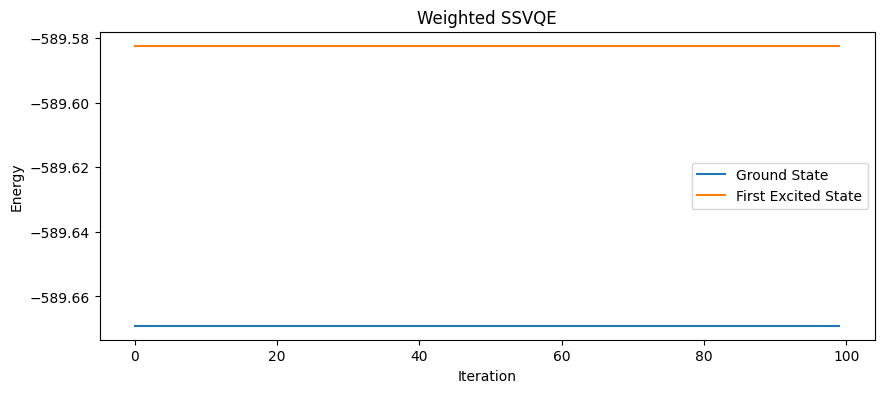

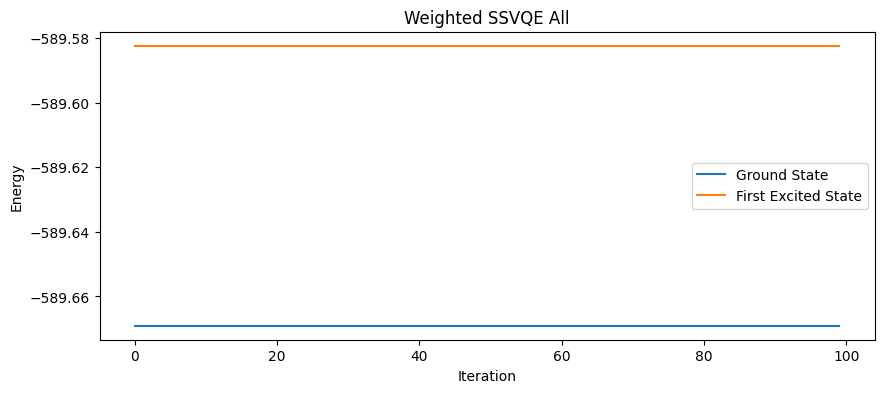

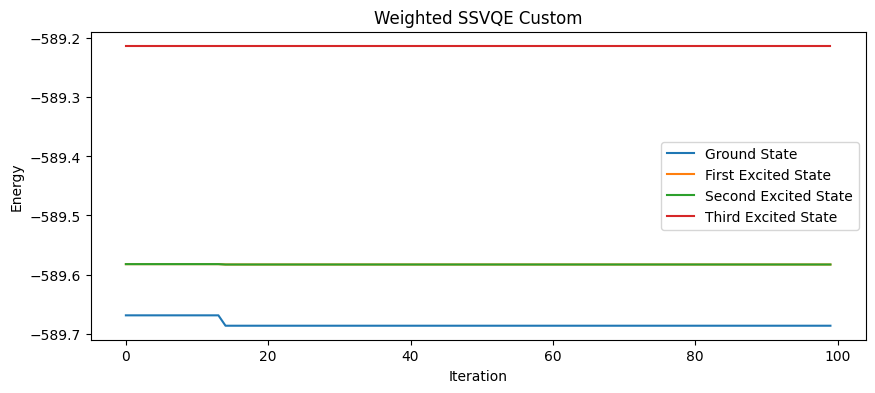

In [76]:
# Graph plot:
Iterations = [*range(0, 100)]
Iterations2 = [*range(0, 100)]

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE')
plt.plot(Iterations, energies_G_1, label='Ground State')
plt.plot(Iterations, energies_1_1, label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE All')
plt.plot(Iterations, energies_all[0][1], label='Ground State')
plt.plot(Iterations, energies_all[1][1], label='First Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.title('Weighted SSVQE Custom')
plt.plot(Iterations2, energies_custom[0][1], label='Ground State')
plt.plot(Iterations2, energies_custom[1][1], label='First Excited State')
plt.plot(Iterations2, energies_custom[2][1], label='Second Excited State')
plt.plot(Iterations2, energies_custom[3][1], label='Third Excited State')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

Avec l'UCCSD je pense qu'on peut s'arrêter à 100 itérations

In [85]:
energies_all[1][1][97]

np.float64(-589.5823974609375)

In [86]:
energies_all[1][1][98]

np.float64(-589.5823974609375)

In [87]:
energies_all[1][1][99]

np.float64(-589.5823974609375)

In [88]:
energies_all[1][1][-1]

np.float64(-589.5823974609375)

In [89]:
energies_custom[1][1][97]

np.float64(-589.5830078125)

In [90]:
energies_custom[1][1][98]

np.float64(-589.5830078125)

In [91]:
energies_custom[1][1][99]

np.float64(-589.5830078125)

In [92]:
energies_custom[1][1][-1]

np.float64(-589.5830078125)

In [93]:
#Energies d'excitation
E_S0 = energies_custom[0][0]
E_S1 = energies_custom[1][0]
E_S2 = energies_custom[2][0]

exc_S1 = (E_S1 - E_S0) * 27.2114


print(f"Énergie fondamentale S0 : {E_S0:.6f} Ha")
print(f"Énergie excitée S1 : {E_S1:.6f} Ha → ΔE = {exc_S1:.2f} eV")


Énergie fondamentale S0 : -589.686646 Ha
Énergie excitée S1 : -589.583008 Ha → ΔE = 2.82 eV
